# Analisando dados do TCGA


##### 1. Importação das bibliotecas
##### 2. Importação dos dados do drive
###### 2.1. Montando o drive
###### 2.2. Importando o csv
##### 3. Pré processamento
###### 3.1. Verificando a descrição dos dados
###### 3.2. Identificando os tipos das colunas
###### 3.2.1. Verificando valores nulos
###### 3.2.2. Verificando os valores únicos de cada variável
###### 3.3. Verificando algumas medidas estatísticas
###### 3.4. Avaliando a quantidade de pessoas em cada classe
###### 3.5. Preenchimento dos dados faltantes
###### 3.6. Ajustando as colunas dummies
###### 3.7. Verificando as novas colunas
###### 3.8. Realizando a divisão do conjunto de dados entre treino e teste
###### 3.9. Seperando o conjunto de dados em treino e teste
##### 4. Balanceamento dos dados de treino
###### 4.1. SMOTE - criando instâncias sintáticas
###### 4.2. RandomUnderSamples - cortando instâncias
###### 4.3. Mostrando os resultados
##### 5. Normalização
##### 6. Modelos de ML
###### 6.1. Random Forest
###### 6.2. Treinando o modelo Regressão logística
###### 6.3. Treinando o modelo KNN
###### 6.4. Treinando o modelo Árvore de decisão
###### 6.5. Teste com o SVM (SVC)
##### 7. Validação cruzada
##### 8. SHAP
##### 9. Curva de aprendizado

# 1. Importações necessárias

In [1]:
print('Realizando algumas importações...',end=' ')
#Necessário para importar o csv ou xlsx
import pandas as pd
#Necessário para ignorar algumas mensagens de warning
import warnings
#Geração de gráficos
import matplotlib.pyplot as plt
#Geração de gráficos
import seaborn as sns
import time
#Cálculos matemáticos
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from imblearn import under_sampling, over_sampling
from imblearn.over_sampling import SMOTE
#Outra opção de Smote (gera na borda das classes)
from imblearn.over_sampling import BorderlineSMOTE
#Balanceamento
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, accuracy_score
from sklearn import metrics
#Identificar acodificação do arquivo
import chardet
#Para imputação de dados faltantes
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OrdinalEncoder
#Modelo de classificação
from sklearn.ensemble import RandomForestClassifier
#Regressão logística
from sklearn.linear_model import LogisticRegression
#DecisionTreeClassifier
from sklearn.tree import DecisionTreeClassifier
#KNN
from sklearn.neighbors import KNeighborsClassifier
#SVM
from sklearn.svm import SVC
#Algumas configurações do pandas
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.options.display.float_format = '{:.4f}'.format
#Necessário para curva de aprendizado
from sklearn.model_selection import learning_curve
# Necessário para validação cruzada
from sklearn.model_selection import cross_val_score, KFold
# Necessário para calcular métricas
from sklearn.metrics import classification_report
# Para gerar a matriz de confusão
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# Para calcular a correlação
from sklearn.feature_selection import SelectKBest, chi2, f_classif
# Para curva ROC
from sklearn.metrics import roc_curve, roc_auc_score

print('[ok]')

Realizando algumas importações... [ok]


# Configurações para tamanho das fontes dos gráficos

In [2]:
plt.rc('font', size=14)  # Tamanho padrão para textos
plt.rc('axes', titlesize=16)  # Tamanho do título
plt.rc('axes', labelsize=14)  # Tamanho dos rótulos dos eixos
plt.rc('xtick', labelsize=12)  # Tamanho dos ticks no eixo X
plt.rc('ytick', labelsize=12)  # Tamanho dos ticks no eixo Y

# 2. Importação dos dados

### 2.2. Carregando os dados do drive...

In [3]:
todos = True
#
print("Importando os dados ...",end=' ')
df_original = pd.read_excel('./dados.xlsx')
print("[ok]")
df_original.head()

Importando os dados ... [ok]


cause_of_death  age_at_index_calc  days_to_death  \
0            NaN            65.0000       822.0000   
1            NaN            74.4137            NaN   
2            NaN            58.2603            NaN   
3            NaN                NaN            NaN   
4            NaN            52.0000       826.0000   

  sobrevida_curta_longa_5_anos               ethnicity  gender   race  \
0                        curta  not hispanic or latino    male  white   
1                        longa                     NaN    male  white   
2                        longa                     NaN    male  asian   
3                        longa                     NaN    male  other   
4                        curta                     NaN  female  white   

  vital_status  year_of_birth  year_of_death ajcc_clinical_m ajcc_clinical_n  \
0         Dead      1936.0000      2003.0000             NaN             NaN   
1        Alive      1943.0000            NaN              M0             NaN   
2        Alive      1959.0000            NaN              M0             NaN   
3        Alive            NaN            NaN             NaN             NaN   
4         Dead      1948.0000      2002.0000             NaN             NaN   

  ajcc_clinical_stage ajcc_clinical_t ajcc_pathologic_m ajcc_pathologic_n  \
0                 NaN             NaN                M0                N0   
1                 NaN             NaN                M0                N0   
2                 NaN             NaN                MX                N2   
3                 NaN             NaN                M0                N0   
4                 NaN             NaN                M1                N1   

  ajcc_pathologic_stage ajcc_pathologic_t ajcc_staging_system_edition  \
0              Stage IB                T2                         NaN   
1              Stage IA               T1a                         7th   
2            Stage IIIA               T2a                         7th   
3              Stage IB                T2                         6th   
4              Stage IV                T4                         6th   

  classification_of_tumor  days_to_last_follow_up  days_to_recurrence  \
0                     NaN                822.0000                 NaN   
1                     NaN               1743.0000                 NaN   
2                     NaN                422.0000                 NaN   
3                     NaN               2595.0000                 NaN   
4                     NaN                     NaN                 NaN   

  icd_10_code last_known_disease_status method_of_diagnosis morphology  \
0       C34.9                       NaN                 NaN     8070/3   
1         NaN                       NaN                 NaN     8070/3   
2         NaN                Tumor free                 NaN     8140/3   
3       C34.1                       NaN                 NaN     8230/3   
4       C34.2                       NaN                 NaN     8140/3   

              primary_diagnosis prior_malignancy prior_treatment  \
0  Squamous cell carcinoma, NOS               no              No   
1  Squamous cell carcinoma, NOS              NaN             NaN   
2           Adenocarcinoma, NOS              NaN             NaN   
3          Solid carcinoma, NOS              yes              No   
4           Adenocarcinoma, NOS               no              No   

  progression_or_recurrence residual_disease site_of_resection_or_biopsy  \
0                       NaN              NaN                   Lung, NOS   
1                        no               R0            Lower lobe, lung   
2                        no               R0                   Lung, NOS   
3                       NaN              NaN            Upper lobe, lung   
4                       NaN              NaN           Middle lobe, lung   

  synchronous_malignancy tissue_or_organ_of_origin tumor_grade  \
0                     No               

## Contagem de instâncias do dataset

In [4]:
df_original.shape

(2773, 41)

# 3. Pré-processamento

### 3.1 Verificando a descrição dos dados

In [5]:
df_original.describe(include='all')

cause_of_death  age_at_index_calc  days_to_death  \
count              164          2693.0000      1026.0000   
unique               5                NaN            NaN   
top     Cancer Related                NaN            NaN   
freq               135                NaN            NaN   
mean               NaN            65.3708       808.8372   
std                NaN            10.4379       778.9161   
min                NaN            12.0164         0.0000   
25%                NaN            59.0000       281.0000   
50%                NaN            67.0000       562.0000   
75%                NaN            73.0000      1114.7500   
max                NaN            90.0000      5287.0000   

       sobrevida_curta_longa_5_anos               ethnicity gender   race  \
count                          2773                    1825   2773   2773   
unique                            2                       2      2      6   
top                           longa  not hispanic or latino   male  white   
freq                           1847                    1770   1717   1911   
mean                            NaN                     NaN    NaN    NaN   
std                             NaN                     NaN    NaN    NaN   
min                             NaN                     NaN    NaN    NaN   
25%                             NaN                     NaN    NaN    NaN   
50%                             NaN                     NaN    NaN    NaN   
75%                             NaN                     NaN    NaN    NaN   
max                             NaN                     NaN    NaN    NaN   

       vital_status  year_of_birth  year_of_death ajcc_clinical_m  \
count          2773      2441.0000       708.0000             358   
unique            2            NaN            NaN               5   
top           Alive            NaN            NaN              M0   
freq           1578            NaN            NaN             230   
mean            NaN      1943.5776      2007.6427             NaN   
std             NaN        11.9428         5.7989             NaN   
min             NaN      1915.0000      1992.0000             NaN   
25%             NaN      1935.0000      2004.0000             NaN   
50%             NaN      1942.0000      2007.0000             NaN   
75%             NaN      1950.0000      2010.0000             NaN   
max             NaN      2003.0000      2022.0000             NaN   

       ajcc_clinical_n ajcc_clinical_stage ajcc_clinical_t ajcc_pathologic_m  \
count               64                 101              64              2652   
unique               5                  10               8                 5   
top                 NX            Stage IV              TX                M0   
freq                24                  47              16              1891   
mean               NaN                 NaN             NaN               NaN   
std                NaN                 NaN             NaN               NaN   
min                NaN                 NaN             NaN               NaN   
25%                NaN                 NaN             NaN               NaN   
50%                NaN                 NaN             NaN               NaN   
75%                NaN                 NaN             NaN               NaN   
max                NaN                 NaN             NaN               NaN   

       ajcc_pathologic_n ajcc_pathologic_stage ajcc_pathologic_t  \
count               2677                  2668              2672   
unique                 5                    13                11   
top                   N0              Stage IB                T2   
freq                1688                   728               719   
mean                 NaN                   NaN               NaN   
std                  NaN                   NaN               NaN   
min                  NaN                   NaN               NaN   
25%                  NaN    

### 3.2. Identificando os tipos das colunas

#### 3.2.1. Verificando valores nulos

In [6]:
#Verificando informações
df_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2773 entries, 0 to 2772
Data columns (total 41 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   cause_of_death                164 non-null    object 
 1   age_at_index_calc             2693 non-null   float64
 2   days_to_death                 1026 non-null   float64
 3   sobrevida_curta_longa_5_anos  2773 non-null   object 
 4   ethnicity                     1825 non-null   object 
 5   gender                        2773 non-null   object 
 6   race                          2773 non-null   object 
 7   vital_status                  2773 non-null   object 
 8   year_of_birth                 2441 non-null   float64
 9   year_of_death                 708 non-null    float64
 10  ajcc_clinical_m               358 non-null    object 
 11  ajcc_clinical_n               64 non-null     object 
 12  ajcc_clinical_stage           101 non-null    object 
 13  ajc

In [7]:
#Verificando valores nulos
print(df_original.isnull().sum())

cause_of_death                  2609
age_at_index_calc                 80
days_to_death                   1747
sobrevida_curta_longa_5_anos       0
ethnicity                        948
gender                             0
race                               0
vital_status                       0
year_of_birth                    332
year_of_death                   2065
ajcc_clinical_m                 2415
ajcc_clinical_n                 2709
ajcc_clinical_stage             2672
ajcc_clinical_t                 2709
ajcc_pathologic_m                121
ajcc_pathologic_n                 96
ajcc_pathologic_stage            105
ajcc_pathologic_t                101
ajcc_staging_system_edition      448
classification_of_tumor         2579
days_to_last_follow_up           676
days_to_recurrence              2757
icd_10_code                      588
last_known_disease_status       2446
method_of_diagnosis             2560
morphology                         6
primary_diagnosis                  0
p

#### 3.2.2. Verificando os valores únicos de cada variável

In [8]:
valores_unicos = []
for i in df_original.columns[0:43].tolist():
  print(i,':',len(df_original[i].astype(str).value_counts()))
  valores_unicos.append(len(df_original[i].astype(str).value_counts()))

cause_of_death : 6
age_at_index_calc : 382
days_to_death : 468
sobrevida_curta_longa_5_anos : 2
ethnicity : 3
gender : 2
race : 6
vital_status : 2
year_of_birth : 64
year_of_death : 30
ajcc_clinical_m : 6
ajcc_clinical_n : 6
ajcc_clinical_stage : 11
ajcc_clinical_t : 9
ajcc_pathologic_m : 6
ajcc_pathologic_n : 6
ajcc_pathologic_stage : 14
ajcc_pathologic_t : 12
ajcc_staging_system_edition : 7
classification_of_tumor : 4
days_to_last_follow_up : 857
days_to_recurrence : 17
icd_10_code : 17
last_known_disease_status : 4
method_of_diagnosis : 9
morphology : 28
primary_diagnosis : 34
prior_malignancy : 3
prior_treatment : 4
progression_or_recurrence : 3
residual_disease : 5
site_of_resection_or_biopsy : 9
synchronous_malignancy : 3
tissue_or_organ_of_origin : 11
tumor_grade : 6
year_of_diagnosis : 29
therapeutic_agents : 17
treatment_intent_type : 6
treatment_or_therapy : 3
treatment_outcome : 4
treatment_type : 9


### 3.3. Verificando algumas medidas estatísticas

In [9]:
df_original.describe()

age_at_index_calc  days_to_death  year_of_birth  year_of_death  \
count          2693.0000      1026.0000      2441.0000       708.0000   
mean             65.3708       808.8372      1943.5776      2007.6427   
std              10.4379       778.9161        11.9428         5.7989   
min              12.0164         0.0000      1915.0000      1992.0000   
25%              59.0000       281.0000      1935.0000      2004.0000   
50%              67.0000       562.0000      1942.0000      2007.0000   
75%              73.0000      1114.7500      1950.0000      2010.0000   
max              90.0000      5287.0000      2003.0000      2022.0000   

       days_to_last_follow_up  days_to_recurrence  year_of_diagnosis  
count               2097.0000             16.0000          2544.0000  
mean                 945.5117            489.8125          2009.1073  
std                  894.2519            311.1412             5.0205  
min                  -11.0000             72.0000          1991.0000  
25%                  366.0000            216.7500          2006.0000  
50%                  684.0000            377.0000          2010.0000  
75%                 1361.0000            775.7500          2012.0000  
max                 7248.0000           1016.0000          2018.0000

### 3.4. Avaliando a quantidade de pessoas em cada classe

In [10]:
df_original.groupby(['sobrevida_curta_longa_5_anos']).size()

sobrevida_curta_longa_5_anos
curta     926
longa    1847
dtype: int64

###### Fica muito desbalanceado para uma classe, o que pode deixar o modelo com vies de aprendizado

<Axes: title={'center': 'Sobrevida'}, xlabel='sobrevida_curta_longa_5_anos'>

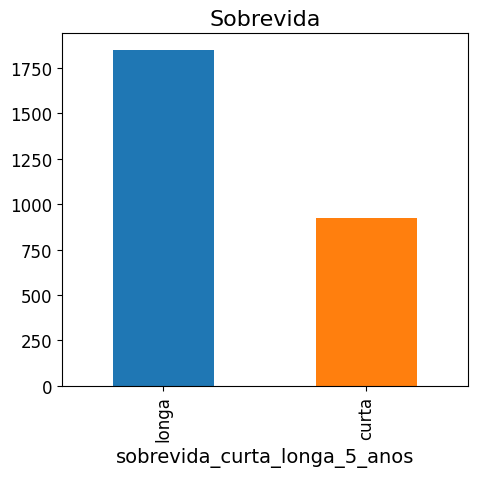

In [11]:
#Montando um gráfico
#df_original.sobrevida_curta_loga_5_anos.value_counts().plot(kind='bar',title='Sobrevida 5 anos', color=['#219ebc','#023047'])

plt.rcParams['figure.figsize'] = [5.00,5.00]
plt.rcParams['figure.autolayout'] = True
df_original.sobrevida_curta_longa_5_anos.value_counts().plot(kind='bar', title='Sobrevida',color=['#1F77B4','#FF7F0E'])

### 3.5. Listando colunas para remover


In [12]:
remover = [
           'days_to_death',
           'ethnicity', 
           'vital_status', 
           'year_of_birth', 
           'year_of_death', 
           'ajcc_clinical_m',
           'ajcc_clinical_n',
           'ajcc_clinical_t',
           'ajcc_staging_system_edition', 
           'classification_of_tumor', 
           'icd_10_code', 
           'last_known_disease_status', 
           'prior_malignancy', 
           'prior_treatment', 
           'progression_or_recurrence', 
           'year_of_diagnosis', 
           'treatment_intent_type', 
           'cause_of_death',
           'ethnicity',
           'race',
           'ajcc_clinical_stage',
           'ajcc_pathologic_stage',
           'morphology',
           'method_of_diagnosis',
           'therapeutic_agents',
           'treatment_or_therapy',
           'treatment_outcome',
           'treatment_type',
           'days_to_recurrence',
           'residual_disease',
           'tumor_grade'
           ]
df_original.drop(columns=remover, inplace=True)
#Verificando informações
df_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2773 entries, 0 to 2772
Data columns (total 11 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   age_at_index_calc             2693 non-null   float64
 1   sobrevida_curta_longa_5_anos  2773 non-null   object 
 2   gender                        2773 non-null   object 
 3   ajcc_pathologic_m             2652 non-null   object 
 4   ajcc_pathologic_n             2677 non-null   object 
 5   ajcc_pathologic_t             2672 non-null   object 
 6   days_to_last_follow_up        2097 non-null   float64
 7   primary_diagnosis             2773 non-null   object 
 8   site_of_resection_or_biopsy   2773 non-null   object 
 9   synchronous_malignancy        2061 non-null   object 
 10  tissue_or_organ_of_origin     2773 non-null   object 
dtypes: float64(2), object(9)
memory usage: 238.4+ KB


### 3.5. Etapa de imputação de dados faltantes

In [13]:
print('Ajustando as colunas do dataset')

# Verifica se a coluna 'cause_of_death' existe no DataFrame
if 'cause_of_death' in df_original.columns:
    print('Preenchendo a coluna cause_of_death com o valor ', end=' ')

    # Preencher os valores nulos com o valor mais frequente
    df_original.loc[df_original['cause_of_death'].isna(), 'ethnicity'] = 'not_reported'
    # df_original['ethnicity'].fillna('not_reported', inplace=True)
    print('not_reported [ok]')
else:
    print("A coluna 'cause_of_death' não existe no DataFrame.")
##
#Verificando se a coluna 'ethnicity' existe
if 'ethnicity' in df_original.columns:
  print('Preenchendo a coluna ethnicity com o valor ', end=' ')

  # Preencher os valores nulos com o valor mais frequente
  df_original.loc[df_original['ethnicity'].isna(), 'ethnicity'] = 'not_reported'
  #df_original['ethnicity'].fillna('not_reported', inplace=True)

  print('not_reported [ok]')
else:
  print("A coluna 'ethnicity' não existe no DataFrame.")
##
#Verficando se a coluna 'gender' existe
if 'gender' in df_original.columns:
  print('Preenchendo a coluna gender com o valor ', end=' ')

  # Preencher os valores nulos com o valor mais frequente
  df_original.loc[df_original['gender'].isna(), 'gender'] = 'not_reported'
  #df_original['gender'].fillna('not_reported', inplace=True)

  print('not_reported [ok]')
else:
  print("A coluna 'gender' não existe no DataFrame.")
##
#Verificando se a coluna 'race' exite
if 'race' in df_original.columns:
  print('Preenchendo a coluna race com o valor ', end=' ')

  # Preencher os valores nulos com o valor mais frequente
  df_original.loc[df_original['race'].isna(), 'race'] = 'not_reported'
  #df_original['race'].fillna('not_reported', inplace=True)

  print('not_reported [ok]')
else:
  print("A coluna 'race' não existe no DataFrame.")
##

#Verificando se a coluna 'ajcc_clinical_m' exite
if 'ajcc_clinical_m' in df_original.columns:
  print('Preenchendo a coluna ajcc_clinical_m com o valor ', end=' ')
  # Preencher os valores nulos com not_reported
  df_original.loc[df_original['ajcc_clinical_m'].isna(), 'ajcc_clinical_m'] = 'not_reported'
  #df_original['ajcc_clinical_m'].fillna('MX', inplace=True)

  print('not_reported [ok]')
else:
  print("A coluna 'ajcc_clinical_m' não existe no DataFrame.")
##

#Verificando se a coluna 'ajcc_clinical_n' existe
if 'ajcc_clinical_n' in df_original.columns:
  print('Preenchendo a coluna ajcc_clinical_n com o valor ', end=' ')

  # Preencher os valores nulos com not_reported
  df_original.loc[df_original['ajcc_clinical_n'].isna(), 'ajcc_clinical_n'] = 'not_reported'
  #df_original['ajcc_clinical_n'].fillna('NX', inplace=True)

  print('not_reported [ok]')
else:
  print("A coluna 'ajcc_clinical_n' não existe no DataFrame.")
##

#Verificando se a coluna 'ajcc_clinical_stage' existe
if 'ajcc_clinical_stage' in df_original.columns:
  print('Preenchendo a coluna ajcc_clinical_stage com o valor ', end=' ')

  # Preencher os valores nulos com o valor mais frequente
  df_original.loc[df_original['ajcc_clinical_stage'].isna(), 'ajcc_clinical_stage'] = 'not_reported'
  #df_original['ajcc_clinical_stage'].fillna('not_reported', inplace=True)

  print('not_reported [ok]')
else:
  print("A coluna 'ajcc_clinical_stage' não existe no DataFrame.")
##

#Verificando se a coluna 'ajcc_clinical_t' existe
if 'ajcc_clinical_t' in df_original.columns:
  print('Preenchendo a coluna ajcc_clinical_t com o valor ', end=' ')

  # Preencher os valores nulos com not_reported
  df_original.loc[df_original['ajcc_clinical_t'].isna(), 'ajcc_clinical_t'] = 'not_reported'
  #df_original['ajcc_clinical_t'].fillna('TX', inplace=True)

  print('not_reported [ok]')
else:
  print("A coluna 'ajcc_clinical_t' não existe no DataFrame.")
##

#Verificando se a coluna ajcc_pathologic_m existe
if 'ajcc_pathologic_m' in df_original.columns:
  print('Preenchendo a coluna ajcc_pathologic_m com o valor ', end=' ')

  # Preencher os valores nulos com not_reported
  df_original.loc[df_original['ajcc_pathologic_m'].isna(), 'ajcc_pathologic_m'] = 'not_reported'
  #df_original['ajcc_pathologic_m'].fillna('MX', inplace=True)

  print('not_reported [ok]')
else:
  print("A coluna 'ajcc_pathologic_m' não existe no DataFrame.")
##

#Verificando se a coluna 'ajcc_pathologic_n existe
if 'ajcc_pathologic_n' in df_original.columns:
  print('Preenchendo a coluna ajcc_pathologic_n com o valor ', end=' ')

  # Preencher os valores nulos com not_reported
  df_original.loc[df_original['ajcc_pathologic_n'].isna(), 'ajcc_pathologic_n'] = 'not_reported'
  #df_original['ajcc_pathologic_n'].fillna('NX', inplace=True)

  print('not_reported [ok]')
else:
  print("A coluna 'ajcc_pathologic_n' não existe no DataFrame.")
##

#Verificando se a coluna 'ajcc_pathologic_stage'
if 'ajcc_pathologic_stage' in df_original.columns:
  print('Preenchendo a coluna ajcc_pathologic_stage com o valor ', end=' ')

  # Preencher os valores nulos com o valor mais frequente
  df_original.loc[df_original['ajcc_pathologic_stage'].isna(), 'ajcc_pathologic_stage'] = 'not_reported'
  #df_original['ajcc_pathologic_stage'].fillna('not_reported', inplace=True)

  print('not_reported [ok]')
else:
  print("A coluna 'ajcc_pathologic_stage' não existe no DataFrame.")
##

#Verificando se a coluba 'ajcc_pathologic_t'
if 'ajcc_pathologic_t' in df_original.columns:
  print('Preenchendo a coluna ajcc_pathologic_t com o valor ', end=' ')

  # Preencher os valores nulos com not_reported
  df_original.loc[df_original['ajcc_pathologic_t'].isna(), 'ajcc_pathologic_t'] = 'not_reported'
  #df_original['ajcc_pathologic_t'].fillna('TX', inplace=True)

  print('not_reported [ok]')
else:
  print("A coluna 'ajcc_pathologic_t' não existe no DataFrame.")
##

#Verificando se a coluna 'classification_of_tumor' existe
if 'classification_of_tumor' in df_original.columns:
  print('Preenchendo a coluna classification_of_tumor com o valor ', end=' ')

  # Preencher os valores nulos com not_reported
  df_original.loc[df_original['classification_of_tumor'].isna(), 'classification_of_tumor'] = 'not_reported'
  #df_original['classification_of_tumor'].fillna('not_reported', inplace=True)

  print('not_reported [ok]')
else:
  print("A coluna 'classification_of_tumor' não existe no DataFrame.")
##

#Verificando se a coluna 'method_of_diagnosis' existe
if 'method_of_diagnosis' in df_original.columns:
  print('Preenchendo a coluna method_of_diagnosis com o valor ', end=' ')

  # Preencher os valores nulos com o valor mais frequente
  df_original.loc[df_original['method_of_diagnosis'].isna(), 'method_of_diagnosis'] = 'not_reported'
  #df_original['method_of_diagnosis'].fillna('not_reported', inplace=True)

  print('not_reported [ok]')
else:
  print("A coluna 'method_of_diagnosis' não existe no DataFrame.")
##

#Verificando se a coluna 'morphology' existe
if 'morphology' in df_original.columns:
  print('Preenchendo a coluna morphology com o valor ', end=' ')

  # Preencher os valores nulos com o valor mais frequente
  df_original.loc[df_original['morphology'].isna(), 'morphology'] = 'not_reported'
  #df_original['morphology'].fillna('not_reported', inplace=True)

  print('not_reported [ok]')
else:
  print("A coluna 'morphology' não existe no DataFrame.")
##

#Verificando se a coluna 'morphology' existe
if 'primary_diagnosis' in df_original.columns:
  print('Preenchendo a coluna primary_diagnosis com o valor ', end=' ')

  # Preencher os valores nulos com o valor mais frequente
  df_original.loc[df_original['primary_diagnosis'].isna(), 'primary_diagnosis'] = 'not_reported'
  #df_original['morphology'].fillna('not_reported', inplace=True)

  print('not_reported [ok]')
else:
  print("A coluna 'primary_diagnosis' não existe no DataFrame.")
##

#Verificando se a coluna 'residual_disease'
if 'residual_disease' in df_original.columns:
  print('Preenchendo a coluna residual_disease com o valor ', end=' ')

  # Preencher os valores nulos com not_reported
  df_original.loc[df_original['residual_disease'].isna(), 'residual_disease'] = 'not_reported'
  #df_original['residual_disease'].fillna('RX', inplace=True)

  print('not_reported [ok]')
else:
  print("A coluna 'residual_disease' não existe no DataFrame.")
##

#Verificando se a coluna 'site_of_resection_or_biopsy' existe
if 'site_of_resection_or_biopsy' in df_original.columns:
  print('Preenchendo a coluna site_of_resection_or_biopsy com o valor ', end=' ')

  # Preencher os valores nulos com o valor mais frequente
  df_original.loc[df_original['site_of_resection_or_biopsy'].isna(), 'site_of_resection_or_biopsy'] = 'not_reported'
  #df_original['site_of_resection_or_biopsy'].fillna('not_reported', inplace=True)

  print('not_reported [ok]')
else:
  print("A coluna 'site_of_resection_or_biopsy' não existe no DataFrame.")
##

#Verificando se a coluna 'tissue_or_organ_of_origin'  existe
if 'tissue_or_organ_of_origin' in df_original.columns:
  print('Preenchendo a coluna tissue_or_organ_of_origin com o valor ', end=' ')

  # Preencher os valores nulos com o valor mais frequente
  df_original.loc[df_original['tissue_or_organ_of_origin'].isna(), 'tissue_or_organ_of_origin'] = 'not_reported'
  #df_original['tissue_or_organ_of_origin'].fillna('not_reported', inplace=True)

  print('not_reported [ok]')
else:
  print("A coluna 'tissue_or_organ_of_origin' não existe no DataFrame.")
##

#Verificando se a coluna tumor_grade existe
if 'tumor_grade' in df_original.columns:
  print('Preenchendo a coluna tumor_grade com o valor ', end=' ')

  # Preencher os valores nulos com not_reported
  df_original.loc[df_original['tumor_grade'].isna(), 'tumor_grade'] = 'not_reported'
  #df_original['tumor_grade'].fillna('RX', inplace=True)

  print('not_reported [ok]')
else:
  print("A coluna 'tumor_grade' não existe no DataFrame.")
##

#Verficando se a coluna 'therapeutic_agents' existe
if 'therapeutic_agents' in df_original.columns:
  print('Preenchendo a coluna therapeutic_agents com o valor ', end=' ')

  # Preencher os valores nulos com not_reported
  df_original.loc[df_original['therapeutic_agents'].isna(), 'therapeutic_agents'] = 'not_reported'
  #df_original['therapeutic_agents'].fillna('not_reported', inplace=True)

  print('not_reported [ok]')
else:
  print("A coluna 'therapeutic_agents' não existe no DataFrame.")
##

#Verificando se a coluna treatment_outcome existe
if 'treatment_outcome' in df_original.columns:
  print('Preenchendo a coluna treatment_outcome com o valor ', end=' ')

  # Preencher os valores nulos com not_reported
  df_original.loc[df_original['treatment_outcome'].isna(), 'treatment_outcome'] = 'not_reported'
  #df_original['treatment_outcome'].fillna('not_reported', inplace=True)

  print('not_reported [ok]')
else:
  print("A coluna 'treatment_outcome' não existe no DataFrame.")
##

#Verificando se a coluna treatment_type existe
if 'treatment_type' in df_original.columns:
  print('Preenchendo a coluna treatment_type com o valor ', end=' ')

  # Preencher os valores nulos com not_reported
  df_original.loc[df_original['treatment_type'].isna(), 'treatment_type'] = 'not_reported'
  #df_original['treatment_type'].fillna('not_reported', inplace=True)

  print('not_reported [ok]')
else:
  print("A coluna 'treatment_type' não existe no DataFrame.")
##

#Verificando se a coluna age_at_index_calc existe
if 'age_at_index_calc' in df_original.columns:
  print('Preenchendo a coluna numérica age_at_index_calc com o valor ', end=' ')

  #Calculando a mediana para preenchimento
  mediana = df_original['age_at_index_calc'].median()

  #Preenchendo os nulos com a mediana calculada
  df_original.loc[df_original['age_at_index_calc'].isna(), 'age_at_index_calc'] = mediana
  #df_original['age_at_index_calc'].fillna(mediana, inplace=True)

  print(mediana,'[ok]')
else:
  print("A coluna 'age_at_index_calc' não existe no DataFrame.")
##

#Verificando se a coluna days_to_last_follow_up existe
if 'days_to_last_follow_up' in df_original.columns:

  print('Preenchendo a coluna numérica days_to_last_follow_up com o valor ', end=' ')

  #Calculando a mediana para preenchimento
  mediana = df_original['days_to_last_follow_up'].median();
  #Preenchendo os nulos com a mediana calculada
  df_original.loc[df_original['days_to_last_follow_up'].isna(), 'days_to_last_follow_up'] = mediana
  #df_original['days_to_last_follow_up'].fillna(mediana, inplace=True)

  print(mediana,'[ok]')
else:
  print("A coluna 'days_to_last_follow_up' não existe no DataFrame.")
##

#Verificando se a coluna days_to_recurrence existe
if 'days_to_recurrence' in df_original.columns:
  print('Preenchendo a coluna numérica days_to_recurrence com o valor ', end=' ')

  #Calculando a mediana para preenchimento
  mediana = df_original['days_to_recurrence'].median();

  #Preenchendo os nulos com a mediana calculada
  df_original.loc[df_original['days_to_recurrence'].isna(), 'days_to_recurrence'] = mediana
  #df_original['days_to_recurrence'].fillna(mediana, inplace=True)

  print(mediana,'[ok]')
else:
  print("A coluna 'days_to_recurrence' não existe no DataFrame.")
##

#Verificando se a coluna synchronous_malignancy existe
if 'synchronous_malignancy' in df_original.columns:
  print('Preenchendo a coluna binária synchronous_malignancy com o valor ', end=' ')

  #Preenchendo a coluna synchronous_malignancy com No
  df_original.loc[df_original['synchronous_malignancy'].isna(), 'synchronous_malignancy'] = 'No'
  #df_original['synchronous_malignancy'].fillna('No', inplace=True)

  print('No [ok]')
else:
  print("A coluna 'synchronous_malignancy' não existe no DataFrame.")
##

#Verificando se a coluna treatment_or_therapy existe
if 'treatment_or_therapy' in df_original.columns:
  print('Preenchendo a coluna binária treatment_or_therapy com o valor ', end=' ')

  #Preenchendo a coluna synchronous_malignancy com No
  df_original.loc[df_original['treatment_or_therapy'].isna(), 'treatment_or_therapy'] = 'No'
  #df_original['treatment_or_therapy'].fillna('No', inplace=True)

  print('No [ok]')
else:
  print("A coluna 'treatment_or_therapy' não existe no DataFrame.")
##


Ajustando as colunas do dataset
A coluna 'cause_of_death' não existe no DataFrame.
A coluna 'ethnicity' não existe no DataFrame.
Preenchendo a coluna gender com o valor  not_reported [ok]
A coluna 'race' não existe no DataFrame.
A coluna 'ajcc_clinical_m' não existe no DataFrame.
A coluna 'ajcc_clinical_n' não existe no DataFrame.
A coluna 'ajcc_clinical_stage' não existe no DataFrame.
A coluna 'ajcc_clinical_t' não existe no DataFrame.
Preenchendo a coluna ajcc_pathologic_m com o valor  not_reported [ok]
Preenchendo a coluna ajcc_pathologic_n com o valor  not_reported [ok]
A coluna 'ajcc_pathologic_stage' não existe no DataFrame.
Preenchendo a coluna ajcc_pathologic_t com o valor  not_reported [ok]
A coluna 'classification_of_tumor' não existe no DataFrame.
A coluna 'method_of_diagnosis' não existe no DataFrame.
A coluna 'morphology' não existe no DataFrame.
Preenchendo a coluna primary_diagnosis com o valor  not_reported [ok]
A coluna 'residual_disease' não existe no DataFrame.
Preen

In [14]:
#Verificando valores nulos
print(df_original.isnull().sum())

age_at_index_calc               0
sobrevida_curta_longa_5_anos    0
gender                          0
ajcc_pathologic_m               0
ajcc_pathologic_n               0
ajcc_pathologic_t               0
days_to_last_follow_up          0
primary_diagnosis               0
site_of_resection_or_biopsy     0
synchronous_malignancy          0
tissue_or_organ_of_origin       0
dtype: int64


In [15]:
# Lista de atributos (copiada da sua descrição)
atributos = [
    "age_at_index_calc",
    "sobrevida_curta_longa_5_anos",
    "gender",
    "ajcc_pathologic_m",
    "ajcc_pathologic_n",
    "ajcc_pathologic_t",
    "days_to_last_follow_up",
    "primary_diagnosis",
    "site_of_resection_or_biopsy",
    "synchronous_malignancy",
    "tissue_or_organ_of_origin"
]

# Iterar sobre os atributos e exibir valores únicos e contagens
for atributo in atributos:
    print(f"\nAnalisando a coluna: {atributo}")
    print(df_original[atributo].value_counts())  # Valores únicos e suas contagens
    print(f"\nTotal de valores únicos na coluna '{atributo}': {df_original[atributo].nunique()}")


Analisando a coluna: age_at_index_calc
age_at_index_calc
67.0000    170
70.0000    121
68.0000    106
73.0000    105
74.0000     95
71.0000     92
69.0000     91
65.0000     90
59.0000     86
66.0000     83
60.0000     81
72.0000     80
63.0000     77
64.0000     76
75.0000     75
76.0000     73
61.0000     71
62.0000     66
77.0000     55
58.0000     55
57.0000     53
52.0000     51
56.0000     51
79.0000     44
54.0000     39
81.0000     39
78.0000     37
55.0000     34
51.0000     28
80.0000     28
53.0000     22
84.0000     21
50.0000     21
83.0000     19
49.0000     18
12.0164     18
46.0000     16
40.0000     15
47.0000     15
41.0000     12
45.0000     12
48.0000     12
42.0000     10
85.0000      9
44.0000      8
82.0000      8
65.4712      6
72.3918      5
39.0000      4
82.8110      4
87.0000      4
83.6986      4
72.6849      4
53.6493      3
66.6740      3
53.5096      3
67.7096      3
58.0658      2
67.8877      2
43.0000      2
88.0000      2
74.8493      2
71.0082     

### 3.6. Ajustando colunas dummies (colunas categóricas nominais), ajustando as colunas categóricas ordinais

In [16]:
if 'cause_of_death' in df_original.columns:
  print('Ajustando a coluna cause_of_death', end=' ')

  # Criar colunas dummy usando one-hot encoding
  # .rename(columns=lambda x: x.replace(' ', '_')) faz com que os valores que possuam espaço na coluna tenham estes espaços trocados por _
  # .rename(columns=lambda x: x.replace(' ', '_').replace('(', '').replace(')', '').replace(',', ''))
  encoded_columns = pd.get_dummies(df_original['cause_of_death'], prefix='cause_of_death').rename(columns=lambda x: x.replace(' ', '_').replace('(', '').replace(')', '').replace(',', ''))

  # Concatenar as colunas dummy com o dataset original
  df_original = pd.concat([df_original, encoded_columns], axis=1)

  # Remover a coluna original 'cause_of_death'
  df_original.drop('cause_of_death', axis=1, inplace=True)

  print('[ok]')
else:
  print("A coluna 'cause_of_death' não existe no DataFrame.")
##

if 'ethnicity' in df_original.columns:
  print('Ajustando a coluna ethnicity', end=' ')

  # Criar colunas dummy usando one-hot encoding
  # .rename(columns=lambda x: x.replace(' ', '_')) faz com que os valores que possuam espaço na coluna tenham estes espaços trocados por _
  encoded_columns = pd.get_dummies(df_original['ethnicity'], prefix='ethnicity').rename(columns=lambda x: x.replace(' ', '_').replace('(', '').replace(')', '').replace(',', ''))

  # Concatenar as colunas dummy com o dataset original
  df_original = pd.concat([df_original, encoded_columns], axis=1)

  # Remover a coluna original 'ethnicity'
  df_original.drop('ethnicity', axis=1, inplace=True)

  print('[ok]')
else:
  print("A coluna 'ethnicity' não existe no DataFrame.")
##

if 'gender' in df_original.columns:
  print('Ajustando a coluna gender', end=' ')
  ##
  # Criar colunas dummy usando one-hot encoding
  encoded_columns = pd.get_dummies(df_original['gender'], prefix='gender').rename(columns=lambda x: x.replace(' ', '_').replace('(', '').replace(')', '').replace(',', ''))

  # Concatenar as colunas dummy com o dataset original
  df_original = pd.concat([df_original, encoded_columns], axis=1)

  # Remover a coluna original 'gender'
  df_original.drop('gender', axis=1, inplace=True)

  print('[ok]')
else:
  print("A coluna 'gender' não existe no DataFrame.")
##

if 'race' in df_original.columns:
  print('Ajustando a coluna race', end=' ')

  # Criar colunas dummy usando one-hot encoding
  encoded_columns = pd.get_dummies(df_original['race'], prefix='race').rename(columns=lambda x: x.replace(' ', '_').replace('(', '').replace(')', '').replace(',', ''))

  # Concatenar as colunas dummy com o dataset original
  df_original = pd.concat([df_original, encoded_columns], axis=1)

  # Remover a coluna original 'race'
  df_original.drop('race', axis=1, inplace=True)

  print('[ok]')
else:
  print("A coluna 'race' não existe no DataFrame.")
##

if 'ajcc_clinical_m' in df_original.columns:
  print('Ajustando a coluna ajcc_clinical_m', end=' ')

  #ordem_categorias = {'M0':0, 'M1':1, 'not_reported':2, 'M1a':3, 'M1b':4,'MX':5}
  ordem_categorias = {'M0':0, 'MX':1, 'not_reported':2, 'M1':3, 'M1a':4, 'M1b':5}

  # Mapear os valores da coluna para números
  df_original['ajcc_clinical_m'] = df_original['ajcc_clinical_m'].map(ordem_categorias)

  print('[ok]')
else:
  print("A coluna 'ajcc_clinical_m' não existe no DataFrame.")
##

if 'ajcc_clinical_n' in df_original.columns:
  print('Ajustando a coluna ajcc_clinical_n', end=' ')

  if todos:
    #ordem_categorias = {'N0':0, 'N1':1, 'not_reported':2, 'N2':3, 'N3':4, 'NX':5}
    ordem_categorias = {'N0':0, 'NX':1, 'not_reported':2, 'N1':3, 'N2':4, 'N3':5}
  else:
    #ordem_categorias = {'N0':0, 'N2':1, 'not_reported':2, 'N3':3, 'NX':4}
    ordem_categorias = {'N0':0, 'NX':1, 'not_reported':2, 'N2':3, 'N3':4}

  # Mapear os valores da coluna para números
  df_original['ajcc_clinical_n'] = df_original['ajcc_clinical_n'].map(ordem_categorias)

  print('[ok]')
else:
  print("A coluna 'ajcc_clinical_n' não existe no DataFrame.")
##

if 'ajcc_clinical_stage' in df_original.columns:
  print('Ajustando a coluna ajcc_clinical_stage', end=' ')
  # Criar colunas dummy usando one-hot encoding
  encoded_columns = pd.get_dummies(df_original['ajcc_clinical_stage'], prefix='ajcc_clinical_stage').rename(columns=lambda x: x.replace(' ', '_').replace('(', '').replace(')', '').replace(',', ''))

  # Concatenar as colunas dummy com o dataset original
  df_original = pd.concat([df_original, encoded_columns], axis=1)

  # Remover a coluna original 'ajcc_clinical_stage'
  df_original.drop('ajcc_clinical_stage', axis=1, inplace=True)

  print('[ok]')
else:
  print("A coluna 'ajcc_clinical_stage' não existe no DataFrame.")
##

if 'ajcc_clinical_t' in df_original.columns:
  print('Ajustando a coluna ajcc_clinical_t', end=' ')
  if todos:
    ordem_categorias = {'T1':0, 'TX':1, 'T1a':2, 'not_reported':3,'T2':4, 'T2a':5, 'T2b':6, 'T3':7, 'T4':8}
  else:
    ordem_categorias = {'T1':0, 'TX':1, 'T2':2, 'not_reported':3, 'T2a':4, 'T2b':5, 'T3':6, 'T4':7}

  # Mapear os valores da coluna para números
  df_original['ajcc_clinical_t'] = df_original['ajcc_clinical_t'].map(ordem_categorias)

  print('[ok]')
else:
  print("A coluna 'ajcc_clinical_t' não existe no DataFrame.")
##

if 'ajcc_pathologic_m' in df_original.columns:
  print('Ajustando a coluna ajcc_pathologic_m', end=' ')

  ordem_categorias = {'M0':0, 'MX':1, 'not_reported':2, 'M1':3, 'M1a':4, 'M1b':5}

  # Mapear os valores da coluna para números
  df_original['ajcc_pathologic_m'] = df_original['ajcc_pathologic_m'].map(ordem_categorias)
  print('[ok]')
else:
  print("A coluna 'ajcc_pathologic_m' não existe no DataFrame.")
##

if 'ajcc_pathologic_n' in df_original.columns:
  print('Ajustando a coluna ajcc_pathologic_n', end=' ')

  # Preencher os valores nulos com not_reported

  ordem_categorias = {'N0':0, 'NX':1, 'N1':2, 'not_reported':3, 'N2':4, 'N3':5}

  # Mapear os valores da coluna para números
  df_original['ajcc_pathologic_n'] = df_original['ajcc_pathologic_n'].map(ordem_categorias)

  print('[ok]')
else:
  print("A coluna 'ajcc_pathologic_n' não existe no DataFrame.")
##

if 'ajcc_pathologic_stage' in df_original.columns:
  print('Ajustando a coluna ajcc_pathologic_stage', end=' ')

  ordem_categorias = {'Stage 1':0, 'Stage IA':1, 'Stage IA2':2, 'Stage IA3':3, 'Stage IB':4, 'not_reported':5, 'Stage II':6, 'Stage IIA':7, 'Stage IIB':8, 'Stage III':9, 'Stage IIA':10, 'Stage IIB':11}

  # Mapear os valores da coluna para números
  df_original['ajcc_pathologic_stage'] = df_original['ajcc_pathologic_stage'].map(ordem_categorias)

  print('[ok]')
else:
  print("A coluna 'ajcc_pathologic_stage' não existe no DataFrame.")
##

if 'ajcc_pathologic_t' in df_original.columns:
  print('Ajustando a coluna ajcc_pathologic_t', end=' ')

  ordem_categorias = {'T1':0, 'TX':1, 'T1a':2, 'T1b':3, 'T1c':4, 'not_reported':5, 'T2':6, 'T2a':7, 'T2b':8, 'T3':9, 'T3a':10, 'T4':11}

  # Mapear os valores da coluna para números
  df_original['ajcc_pathologic_t'] = df_original['ajcc_pathologic_t'].map(ordem_categorias)

  print('[ok]')
else:
  print("A coluna 'ajcc_pathologic_t' não existe no DataFrame.")
##

if 'classification_of_tumor' in df_original.columns:
  print('Ajustando a coluna classification_of_tumor', end=' ')

  ordem_categorias = {'not reported':0, 'primary':1, 'Prior primary':2, 'metastasis':3}

  # Mapear os valores da coluna para números
  df_original['classification_of_tumor'] = df_original['classification_of_tumor'].map(ordem_categorias)

  print('[ok]')
else:
  print("A coluna 'classification_of_tumor' não existe no DataFrame.")
##

if 'method_of_diagnosis' in df_original.columns:
  print('Ajustando a coluna method_of_diagnosis', end=' ')

  # Criar colunas dummy usando one-hot encoding
  encoded_columns = pd.get_dummies(df_original['method_of_diagnosis'], prefix='method_of_diagnosis').rename(columns=lambda x: x.replace(' ', '_').replace('(', '').replace(')', '').replace(',', ''))

  # Concatenar as colunas dummy com o dataset original
  df_original = pd.concat([df_original, encoded_columns], axis=1)

  # Remover a coluna original 'method_of_diagnosis'
  df_original.drop('method_of_diagnosis', axis=1, inplace=True)

  print('[ok]')
else:
  print("A coluna 'method_of_diagnosis' não existe no DataFrame.")
##

if 'morphology' in df_original.columns:
  print('Ajustando a coluna morphology', end=' ')

  # Criar colunas dummy usando one-hot encoding
  encoded_columns = pd.get_dummies(df_original['morphology'], prefix='morphology').rename(columns=lambda x: x.replace(' ', '_').replace('(', '').replace(')', '').replace(',', ''))

  # Concatenar as colunas dummy com o dataset original
  df_original = pd.concat([df_original, encoded_columns], axis=1)

  # Remover a coluna original 'morphology'
  df_original.drop('morphology', axis=1, inplace=True)

  print('[ok]')
else:
  print("A coluna 'morphology' não existe no DataFrame.")
##

if 'primary_diagnosis' in df_original.columns:
  print('Ajustando a coluna primary_diagnosis', end=' ')

  # Criar colunas dummy usando one-hot encoding
  encoded_columns = pd.get_dummies(df_original['primary_diagnosis'], prefix='primary_diagnosis').rename(columns=lambda x: x.replace(' ', '_').replace('(', '').replace(')', '').replace(',', ''))

  # Concatenar as colunas dummy com o dataset original
  df_original = pd.concat([df_original, encoded_columns], axis=1)

  # Remover a coluna original 'morphology'
  df_original.drop('primary_diagnosis', axis=1, inplace=True)

  print('[ok]')
else:
  print("A coluna 'morphology' não existe no DataFrame.")
##

if 'residual_disease' in df_original.columns:
  print('Ajustando a coluna residual_disease', end=' ')

  ordem_categorias = {'R0':0, 'RX':1, 'not_reported':2, 'R1':3, 'R2':4}

  # Mapear os valores da coluna para números
  df_original['residual_disease'] = df_original['residual_disease'].map(ordem_categorias)

  print('[ok]')
else:
  print("A coluna 'residual_disease' não existe no DataFrame.")
##

if 'site_of_resection_or_biopsy' in df_original.columns:
  print('Ajustando a coluna site_of_resection_or_biopsy', end=' ')

  # Criar colunas dummy usando one-hot encoding
  encoded_columns = pd.get_dummies(df_original['site_of_resection_or_biopsy'], prefix='site_of_resection_or_biopsy').rename(columns=lambda x: x.replace(' ', '_').replace('(', '').replace(')', '').replace(',', ''))

  # Concatenar as colunas dummy com o dataset original
  df_original = pd.concat([df_original, encoded_columns], axis=1)

  # Remover a coluna original 'site_of_resection_or_biopsy'
  df_original.drop('site_of_resection_or_biopsy', axis=1, inplace=True)

  print('[ok]')
else:
  print("A coluna 'site_of_resection_or_biopsy' não existe no DataFrame.")
##

if 'tissue_or_organ_of_origin' in df_original.columns:
  print('Ajustando a coluna tissue_or_organ_of_origin', end=' ')

  # Criar colunas dummy usando one-hot encoding
  encoded_columns = pd.get_dummies(df_original['tissue_or_organ_of_origin'], prefix='tissue_or_organ_of_origin').rename(columns=lambda x: x.replace(' ', '_').replace('(', '').replace(')', '').replace(',', ''))
  # Concatenar as colunas dummy com o dataset original
  df_original = pd.concat([df_original, encoded_columns], axis=1)

  # Remover a coluna original 'tissue_or_organ_of_origin'
  df_original.drop('tissue_or_organ_of_origin', axis=1, inplace=True)

  print('[ok]')
else:
  print("A coluna 'tissue_or_organ_of_origin' não existe no DataFrame.")
##

if 'tumor_grade' in df_original.columns:
  print('Ajustando a coluna tumor_grade', end=' ')

  ordem_categorias = {'G1':0, 'GX':1, 'not_reported':2, 'G2':3, 'G3':4}

  # Mapear os valores da coluna para números
  df_original['tumor_grade'] = df_original['tumor_grade'].map(ordem_categorias)

  # Remover a coluna original 'therapeutic_agents'
  df_original.drop('tumor_grade', axis=1, inplace=True)

  print('[ok]')
else:
  print("A coluna 'tumor_grade' não existe no DataFrame.")
##

if 'therapeutic_agents' in df_original.columns:
  print('Ajustando a coluna therapeutic_agents', end=' ')

  # Criar colunas dummy usando one-hot encoding
  encoded_columns = pd.get_dummies(df_original['therapeutic_agents'], prefix='therapeutic_agents').rename(columns=lambda x: x.replace(' ', '_').replace('(', '').replace(')', '').replace(',', ''))

  # Concatenar as colunas dummy com o dataset original
  df_original = pd.concat([df_original, encoded_columns], axis=1)

  # Remover a coluna original 'therapeutic_agents'
  df_original.drop('therapeutic_agents', axis=1, inplace=True)

  print('[ok]')
else:
  print("A coluna 'therapeutic_agents' não existe no DataFrame.")
##

if 'treatment_outcome' in df_original.columns:
  print('Ajustando a coluna treatment_outcome', end=' ')

  # Criar colunas dummy usando one-hot encoding
  encoded_columns = pd.get_dummies(df_original['treatment_outcome'], prefix='treatment_outcome').rename(columns=lambda x: x.replace(' ', '_').replace('(', '').replace(')', '').replace(',', ''))

  # Concatenar as colunas dummy com o dataset original
  df_original = pd.concat([df_original, encoded_columns], axis=1)

  # Remover a coluna original 'treatment_outcome'
  df_original.drop('treatment_outcome', axis=1, inplace=True)

  print('[ok]')
else:
  print("A coluna 'treatment_outcome' não existe no DataFrame.")
##

if 'treatment_type' in df_original.columns:
  print('Ajustando a coluna treatment_type', end=' ')

  # Criar colunas dummy usando one-hot encoding
  encoded_columns = pd.get_dummies(df_original['treatment_type'], prefix='treatment_type').rename(columns=lambda x: x.replace(' ', '_').replace('(', '').replace(')', '').replace(',', ''))

  # Concatenar as colunas dummy com o dataset original
  df_original = pd.concat([df_original, encoded_columns], axis=1)

  # Remover a coluna original 'treatment_type'
  df_original.drop('treatment_type', axis=1, inplace=True)

  print('[ok]')
else:
  print("A coluna 'treatment_type' não existe no DataFrame.")
##


if 'synchronous_malignancy' in df_original.columns:
  print('Ajustando a coluna binária synchronous_malignancy', end=' ')

  # Mapeando os valores 'Yes' para 1 e 'No' para 0
  df_original['synchronous_malignancy'] = df_original['synchronous_malignancy'].map({'Yes': 1, 'No': 0})

  print('[ok]')
else:
  print("A coluna 'synchronous_malignancy' não existe no DataFrame.")
##

if 'treatment_or_therapy' in df_original.columns:
  print('Ajustando a coluna binária treatment_or_therapy', end=' ')

  # Mapeando os valores 'Yes' para 1 e 'No' para 0
  df_original['treatment_or_therapy'] = df_original['treatment_or_therapy'].map({'Yes': 1, 'No': 0})

  print('[ok]')
else:
  print("A coluna 'treatment_or_therapy' não existe no DataFrame.")
##

A coluna 'cause_of_death' não existe no DataFrame.
A coluna 'ethnicity' não existe no DataFrame.
Ajustando a coluna gender [ok]
A coluna 'race' não existe no DataFrame.
A coluna 'ajcc_clinical_m' não existe no DataFrame.
A coluna 'ajcc_clinical_n' não existe no DataFrame.
A coluna 'ajcc_clinical_stage' não existe no DataFrame.
A coluna 'ajcc_clinical_t' não existe no DataFrame.
Ajustando a coluna ajcc_pathologic_m [ok]
Ajustando a coluna ajcc_pathologic_n [ok]
A coluna 'ajcc_pathologic_stage' não existe no DataFrame.
Ajustando a coluna ajcc_pathologic_t [ok]
A coluna 'classification_of_tumor' não existe no DataFrame.
A coluna 'method_of_diagnosis' não existe no DataFrame.
A coluna 'morphology' não existe no DataFrame.
Ajustando a coluna primary_diagnosis [ok]
A coluna 'residual_disease' não existe no DataFrame.
Ajustando a coluna site_of_resection_or_biopsy [ok]
Ajustando a coluna tissue_or_organ_of_origin [ok]
A coluna 'tumor_grade' não existe no DataFrame.
A coluna 'therapeutic_agent

##### ajustando a colunas alvo

In [17]:
print('Ajustando as colunas de classe_sobrevida', end=' ')

# Mapeando os valores 'Longa' para 1 e 'Curta' para 0
df_original['sobrevida_curta_longa_5_anos'] = df_original['sobrevida_curta_longa_5_anos'].map({'longa': 1, 'curta': 0})

print('[ok]')

Ajustando as colunas de classe_sobrevida [ok]


### 3.7. Verificando as novas colunas

In [18]:
#Verificando valores nulos
print(df_original.isnull().sum())

age_at_index_calc                                                           0
sobrevida_curta_longa_5_anos                                                0
ajcc_pathologic_m                                                           0
ajcc_pathologic_n                                                           0
ajcc_pathologic_t                                                           0
days_to_last_follow_up                                                      0
synchronous_malignancy                                                      0
gender_female                                                               0
gender_male                                                                 0
primary_diagnosis_Acinar_cell_carcinoma                                     0
primary_diagnosis_Adenocarcinoma_with_mixed_subtypes                        0
primary_diagnosis_Adenocarcinoma_NOS                                        0
primary_diagnosis_Adenosquamous_carcinoma                       

---

### 3.8. Realizando separação das colunas de treinamento (x) e da coluna alvo (y)

In [19]:
print('Separando as colunas para análise e a coluna alvo', end=' ')
# Definindo X como todas as colunas exceto 'sobrevida_curta_longa_5_anos'
x = df_original.drop(columns=['sobrevida_curta_longa_5_anos'])

y = df_original['sobrevida_curta_longa_5_anos']
#y = df_original['sobrevida_curta_loga_2_anos']
print('[ok]')

Separando as colunas para análise e a coluna alvo [ok]


In [20]:
df_original.head(n=10)

age_at_index_calc  sobrevida_curta_longa_5_anos  ajcc_pathologic_m  \
0            65.0000                             0                  0   
1            74.4137                             1                  0   
2            58.2603                             1                  1   
3            67.0000                             1                  0   
4            52.0000                             0                  3   
5            73.0000                             0                  0   
6            70.0000                             1                  0   
7            68.0000                             0                  0   
8            69.9123                             0                  1   
9            67.0000                             1                  0   

   ajcc_pathologic_n  ajcc_pathologic_t  days_to_last_follow_up  \
0                  0                  6                822.0000   
1                  0                  2               1743.0000   
2                  4                  7                422.0000   
3                  0                  6               2595.0000   
4                  2                 11                684.0000   
5                  0                  6                684.0000   
6                  0                 11               1492.0000   
7                  4                 11               1160.0000   
8                  1                  7                533.0000   
9                  0                  9                684.0000   

   synchronous_malignancy  gender_female  gender_male  \
0                       0          False         True   
1                       0          False         True   
2                       0          False         True   
3                       0          False         True   
4                       0           True        False   
5                       0          False         True   
6                       0          False         True   
7                       0          False         True   
8                       0          False         True   
9                       0          False         True   

   primary_diagnosis_Acinar_cell_carcinoma  \
0                                    False   
1                                    False   
2                                    False   
3                                    False   
4                                    False   
5                                    False   
6                                    False   
7                                    False   
8                                    False   
9                                    False   

   primary_diagnosis_Adenocarcinoma_with_mixed_subtypes  \
0                                              False      
1                                              False      
2                                              False      
3                                              False      
4                                              False      
5                                              False      
6                                              False      
7                                               True      
8                                              False      
9                                              False      

   primary_diagnosis_Adenocarcinoma_NOS  \
0                                 False   
1                                 False   
2                                  True   
3                                 False   
4                                  True   
5                                 False   
6                                 False   
7                                 False   
8                                 False   
9                                  True   

   primary_diagnosis_Adenosquamous_carcinoma  \
0                                      False   
1                                      False   
2                                      False   
3         

###### Deixar 30% para treino e o restante para teste

### ???. Calculando a correlação

####Feature: Nome da variável (coluna do conjunto de dados).
####Score: Medida de relevância da feature em relação ao alvo. Valores mais altos indicam maior relevância.
####P-Value: Mostra a significância estatística da relação entre a feature e o alvo. Geralmente, p-value < 0.05 indica que a relação é estatisticamente significativa.

In [ ]:
# Supondo que X é o DataFrame com os dados e y é o alvo
selector = SelectKBest(score_func=f_classif, k='all')  # k='all' avalia todas as colunas
selector.fit(x, y)

# Acessar os scores e p-values
scores = selector.scores_  # Pontuações das features
p_values = selector.pvalues_  # Valores p associados às features

# Criar um DataFrame para organizar as informações
features_df = pd.DataFrame({
    'Feature': x.columns,
    'Score': scores,
    'P-Value': p_values
})

# Ordenar por Score (maior é melhor)
features_df = features_df.sort_values(by='Score', ascending=False)

print(features_df)

#### Martiz de correlação

In [ ]:
# Supondo que X é o DataFrame com os dados e y é o alvo
data = pd.concat([x, y], axis=1)

# Calcular a correlação
correlation_matrix = data.corr()  # Matriz de correlação padrão (Pearson)

# Exibir apenas a correlação com o alvo
correlation_with_target = correlation_matrix[y.name].drop(y.name)

# Plotar a matriz completa para análise visual (opcional)
plt.figure(figsize=(100, 100))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Matriz de Correlação")
plt.show()

# Exibir as correlações ordenadas
print(correlation_with_target.sort_values(ascending=False))

In [21]:
print('Separando o dataset em treino e teste =0.4 deixa 40% para teste e 60% para treinamento')
# Dividindo o dataset
x_treino, x_test, y_treino, y_test = train_test_split(x, y, test_size=0.4, random_state=42, stratify=y)
print('Instâncias de treino', x_treino.shape)
print('Instâncias de teste', x_test.shape)


#Contagem de instâncias de teste agrupando por classe
classes_treino, counts_treino = np.unique(y_treino, return_counts=True)
classes_teste, counts_teste = np.unique(y_test, return_counts=True)

# Exibir resultados
print("Instâncias de treino por classe:")
for classe, count in zip(classes_treino, counts_treino):
    print(f"Classe {classe}: {count}")

print("\nInstâncias de teste por classe:")
for classe, count in zip(classes_teste, counts_teste):
    print(f"Classe {classe}: {count}")

print('[ok]')
#Usado para o cross validation
y_treino_n_balanceado = y_treino

Separando o dataset em treino e teste =0.4 deixa 40% para teste e 60% para treinamento
Instâncias de treino (1663, 62)
Instâncias de teste (1110, 62)
Instâncias de treino por classe:
Classe 0: 555
Classe 1: 1108

Instâncias de teste por classe:
Classe 0: 371
Classe 1: 739
[ok]


# 4. Balanceando os dados de treino criando instâncias sintéticas (escolha entre uma das opções)


### 4.1. SMOTE - criando instâncias sintáticas



In [ ]:
# seed para produzir o mesmo resultado
seed = 100

# Criando um balanceador SMOTE
balanceador = SMOTE(random_state=seed)

# Aplicando o balanceador
x_res, y_res = balanceador.fit_resample(x_treino, y_treino)

print(x_res.shape)
print(y_res.shape)
y_treino = y_res

### 4.1.1. BorderSMOTE - criando instâncias sintáticas

In [ ]:
# Seed para reprodutibilidade
seed = 100

# Criando um balanceador Borderline-SMOTE
balanceador = BorderlineSMOTE(random_state=seed, kind="borderline-1")  # Pode usar 'borderline-2' para outra abordagem

# Aplicando o balanceador
x_res, y_res = balanceador.fit_resample(x_treino, y_treino)

# Resultados
print(x_res.shape)
print(y_res.shape)

# Atualizando y_treino
y_treino = y_res

### 4.2. RandomUnderSamples - cortando instâncias

In [ ]:
from imblearn.under_sampling import RandomUnderSampler

# Definindo a semente para reprodutibilidade
seed = 100

# Criando um balanceador RandomUnderSampler
balanceador = RandomUnderSampler(random_state=seed)

# Aplicando o balanceador
x_res, y_res = balanceador.fit_resample(x_treino, y_treino)

print(x_res.shape)
print(y_res.shape)

#Mantendo a compatibilidade, os dados são esperados dentro de y_treino
y_treino = y_res

### 4.4. Modelo híbrido, cortando instâncias da classe majoritária e depois aplicando o smote gerando instâncias para igualar (OPÇÃO APLICADA NOS TESTES)

In [22]:
from imblearn.under_sampling import ClusterCentroids
from collections import Counter

seed = 100

# Criando o undersample com Cluster Centroids
undersample = ClusterCentroids(sampling_strategy=0.7, random_state=seed)

# Aplicando o Cluster Centroids
x_unsers, y_unsers = undersample.fit_resample(x_treino, y_treino)

# Verificando o novo balanço das classes
print(f"Distribuição original: {Counter(y_treino)}")
print(f"Distribuição após Cluster Centroids: {Counter(y_unsers)}")

# Criando o smote para gerar 30% das instâncias
smote = SMOTE(random_state=seed)
# Aplicando o smote
x_res, y_res = smote.fit_resample(x_unsers, y_unsers )

print(x_res.shape)
print(y_res.shape)

# Mantendo a compatibilidade
y_treino = y_res


# Verificando o novo balanço das classes
from collections import Counter
print(f"Distribuição original: {Counter(y_treino)}")
print(f"Distribuição após SMOTE: {Counter(y_res)}")

Distribuição original: Counter({1: 1108, 0: 555})
Distribuição após Cluster Centroids: Counter({1: 792, 0: 555})
(1584, 62)
(1584,)
Distribuição original: Counter({0: 792, 1: 792})
Distribuição após SMOTE: Counter({0: 792, 1: 792})


In [ ]:
from imblearn.under_sampling import TomekLinks

# Aplicando Tomek Links
tomek = TomekLinks(sampling_strategy='auto')
x_res, y_res = tomek.fit_resample(x_treino, y_treino)

print(x_res.shape)
print(y_res.shape)

# Mantendo a compatibilidade
y_treino = y_res

### 4.3. Mostrando os resultados

<Axes: title={'center': 'Sobrevida'}, xlabel='sobrevida_curta_longa_5_anos'>

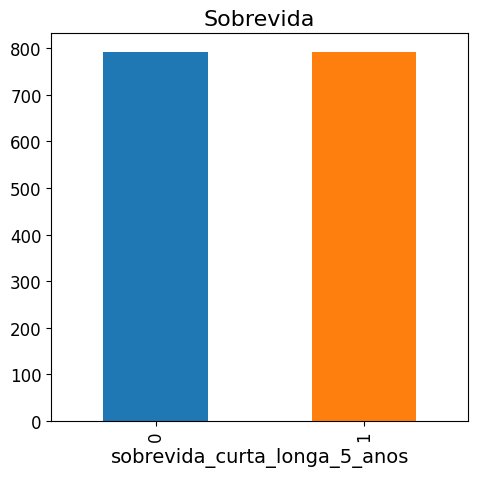

In [23]:
plt.rcParams['figure.figsize'] = [5.00,5.00]
plt.rcParams['figure.autolayout'] = True
y_treino.value_counts().plot(kind='bar', title='Sobrevida',color=['#1F77B4','#FF7F0E'])

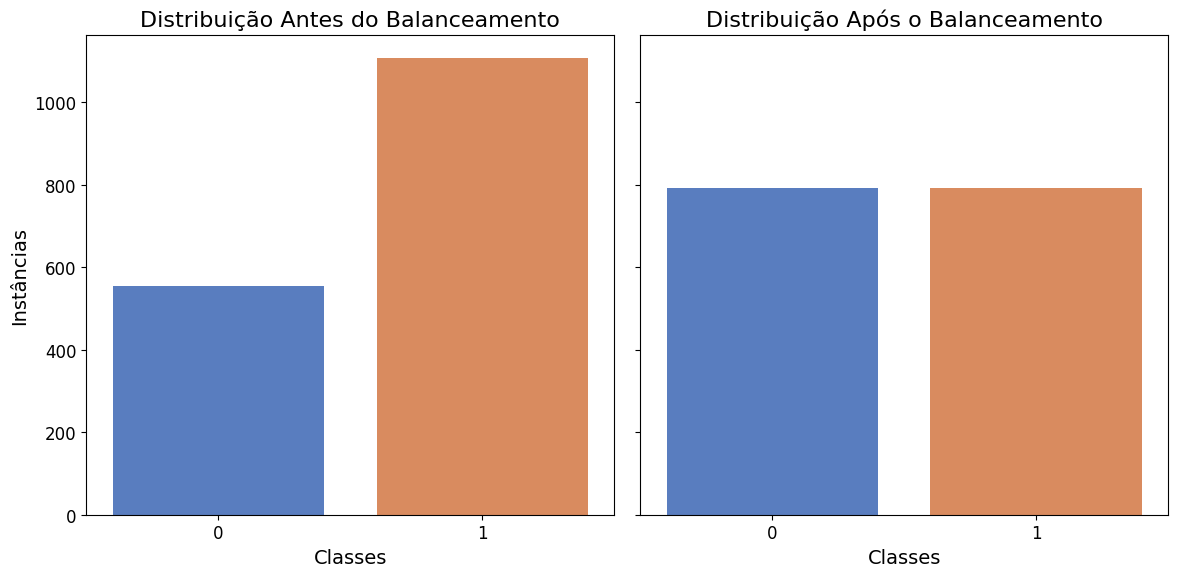

In [24]:
from collections import Counter
# Contagem das classes
count_original = Counter(y_treino_n_balanceado)
count_balanced = Counter(y_treino)

# Criando o gráfico
fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

# Antes do balanceamento
sns.barplot(
    x=list(count_original.keys()),
    y=list(count_original.values()),
    hue=list(count_original.keys()),  # Associa o x ao hue
    ax=axes[0],
    palette="muted",
    legend=False  # Remove a legenda
)
axes[0].set_title("Distribuição Antes do Balanceamento")
axes[0].set_xlabel("Classes")
axes[0].set_ylabel("Instâncias")

# Depois do balanceamento
sns.barplot(
    x=list(count_balanced.keys()),
    y=list(count_balanced.values()),
    hue=list(count_balanced.keys()),  # Associa o x ao hue
    ax=axes[1],
    palette="muted",
    legend=False  # Remove a legenda
)
axes[1].set_title("Distribuição Após o Balanceamento")
axes[1].set_xlabel("Classes")

plt.tight_layout()
plt.show()

# 5. Normalização

In [25]:
# Criar o escalonador e ajustá-lo apenas nos dados de treino balanceados
normalizador = MinMaxScaler()
x_treino_norm = normalizador.fit_transform(x_res)  # Ajusta e transforma o treino balanceado

# Aplicar a mesma transformação ao conjunto de teste
x_teste_norm = normalizador.transform(x_test)  # Apenas transforma o teste

# Normalizando o conjunto de dados não balanceado
x_treino_norm_n_balanceado = normalizador.fit_transform(x_treino)  # Ajusta e transforma o treino não balanceado

# Aplicar a mesma transformação ao conjunto de teste não balanceado
x_teste_norm_n_balanceado = normalizador.transform(x_test)  # Apenas transforma o teste


#### Teste com wrapper iterativos

In [ ]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.ensemble import RandomForestClassifier

x_treino_norm_df = pd.DataFrame(x_treino_norm, columns=x.columns)
y_treino_df = pd.Series(y_treino)

# Criar o seletor sequencial
sfs = SFS(RandomForestClassifier(),
          k_features=10,  # Número de características desejadas
          forward=True,   # Seleção forward
          scoring='accuracy',  # Métrica usada
          cv=5)           # Validação cruzada

# Ajustar o modelo com os dados normalizados
sfs.fit(x_treino_norm_df, y_treino_df)



# Obter os nomes das colunas selecionadas
selected_features = sfs.k_feature_names_

# Exibir como uma lista de colunas
print("Colunas Selecionadas:", list(selected_features))

# Modelos de AM

### 6.1. Random Forest

In [124]:
# Criando o classificador com RandomForest

#Parámetros calculados pelo 
clf = RandomForestClassifier()

# Construção do modelo
clf = clf.fit(x_treino_norm, y_treino)
print('[ok]')

[ok]


In [125]:
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier

#modelo = RandomForestClassifier(random_state=42)
rfe = RFE(estimator=clf, n_features_to_select=10)
rfe.fit(x_treino_norm, y_treino)
variaveis_selecionadas = x.columns[rfe.support_]
print("Variáveis Selecionadas:", list(variaveis_selecionadas))

Variáveis Selecionadas: ['age_at_index_calc', 'ajcc_pathologic_m', 'ajcc_pathologic_n', 'ajcc_pathologic_t', 'days_to_last_follow_up', 'gender_male', 'primary_diagnosis_Adenocarcinoma_NOS', 'primary_diagnosis_Squamous_cell_carcinoma_NOS', 'site_of_resection_or_biopsy_Lung_NOS', 'tissue_or_organ_of_origin_Upper_lobe_lung']


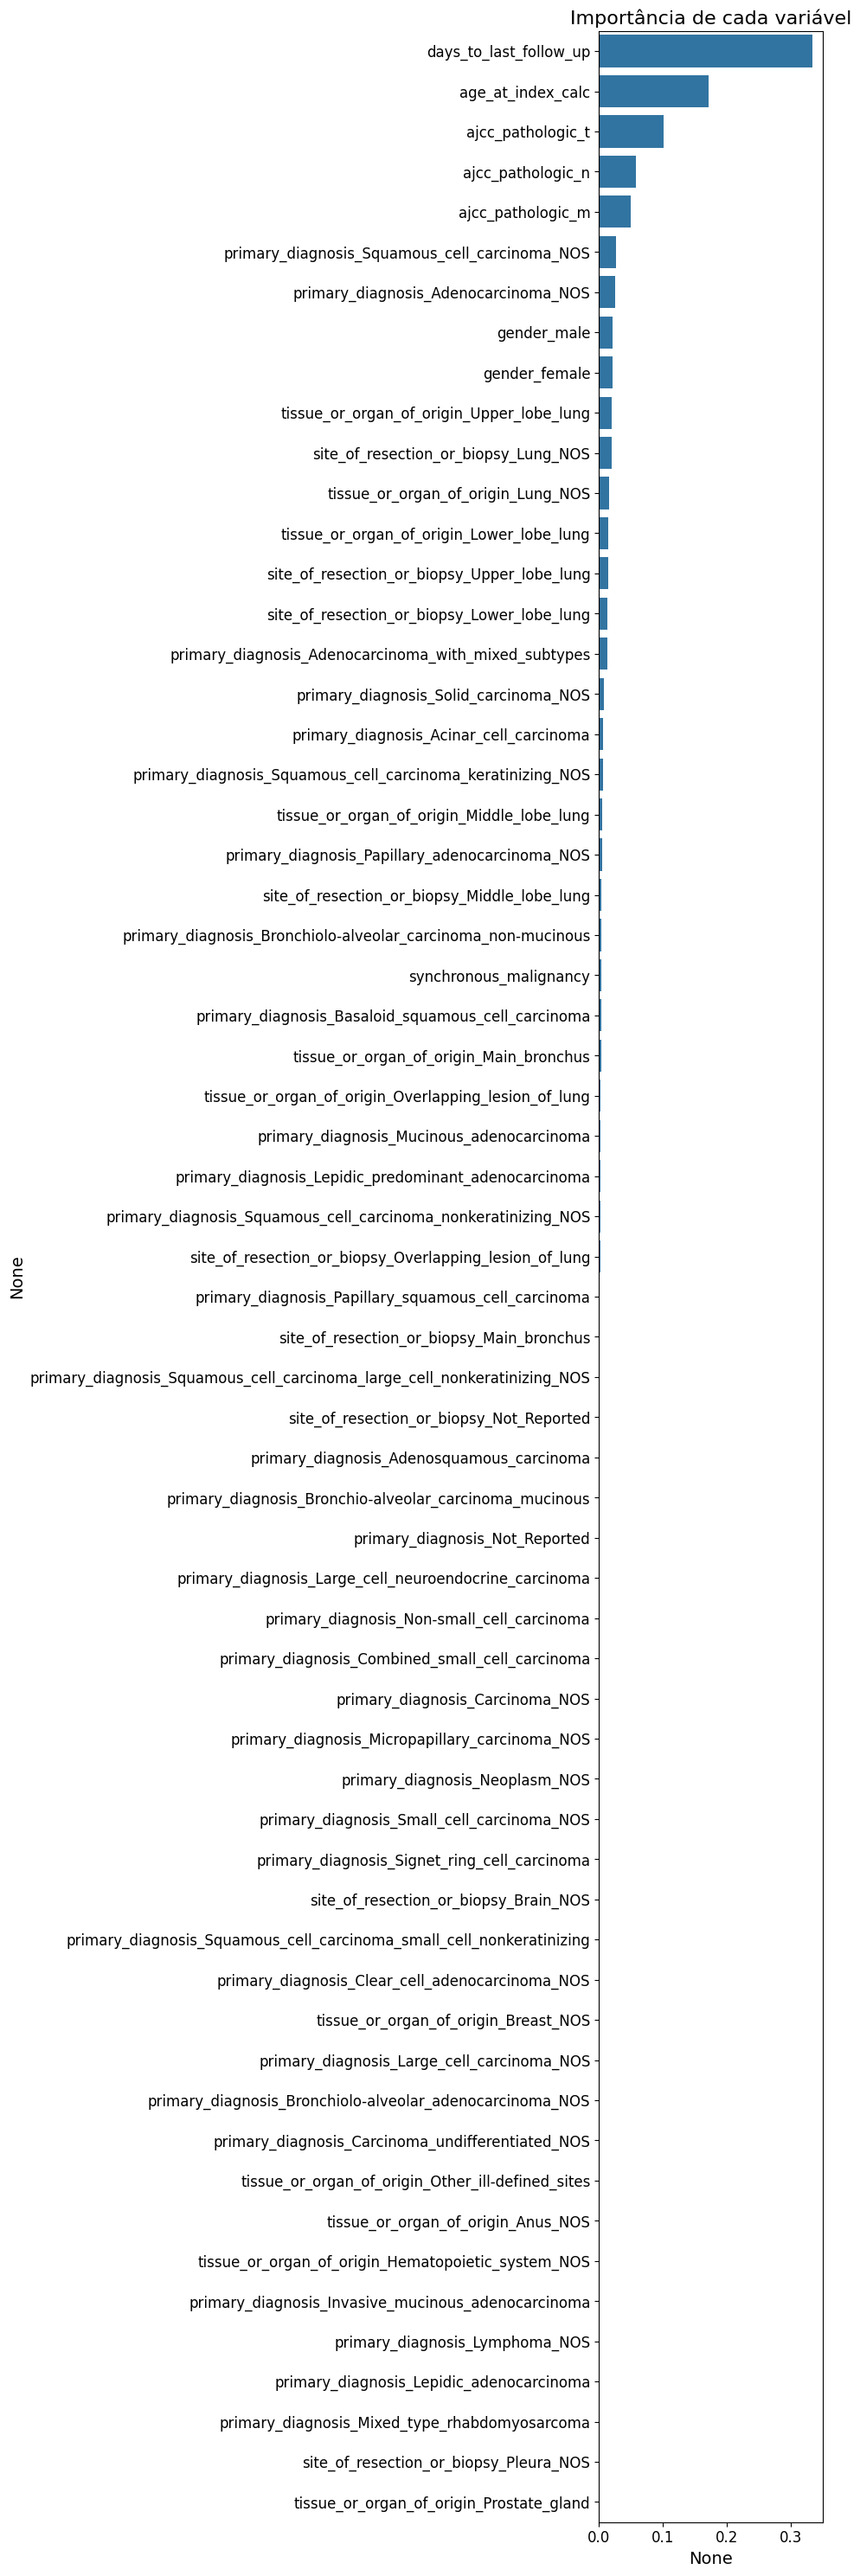

In [126]:
# exibindo a importência de cada variável no modelo preditivo
plt.rcParams['figure.figsize'] = [10.00,30.00]
plt.rcParams['figure.autolayout'] = True
#Importâncias para gráfico geral
importancias_rf = clf.feature_importances_
importances = pd.Series(data=clf.feature_importances_, index=x.columns)
importances = importances.sort_values(ascending = False)
sns.barplot(x=importances, y=importances.index, orient='h').set_title('Importância de cada variável')
plt.show()

In [127]:
#Apresentando o percentual de importância de cada variável
importances.sort_values(ascending = False)

days_to_last_follow_up                                                     0.33
age_at_index_calc                                                          0.17
ajcc_pathologic_t                                                          0.10
ajcc_pathologic_n                                                          0.06
ajcc_pathologic_m                                                          0.05
primary_diagnosis_Squamous_cell_carcinoma_NOS                              0.03
primary_diagnosis_Adenocarcinoma_NOS                                       0.03
gender_male                                                                0.02
gender_female                                                              0.02
tissue_or_organ_of_origin_Upper_lobe_lung                                  0.02
site_of_resection_or_biopsy_Lung_NOS                                       0.02
tissue_or_organ_of_origin_Lung_NOS                                         0.02
tissue_or_organ_of_origin_Lower_lobe_lun

In [128]:
#Simulando os dados de teste
scores= clf.score(x_treino_norm, y_treino)
scores

0.9993686868686869

#### Simulando com os dados de teste

In [129]:
print('Realizando previsões com o Random Forest',end=' ')
#Realizando a previsão com os dados de teste
#Realizando as previsões
y_pred = clf.predict(x_teste_norm)

#Para o conjunto de treino
y_pred_treino = clf.predict(x_treino_norm)
print('[ok]')

Realizando previsões com o Random Forest [ok]


In [130]:
#Gerando a matriz de confusão do algoritmo

print(confusion_matrix(y_test, y_pred))

[[299  72]
 [ 75 664]]


#### Calculando métricas

In [131]:
#Calculado métricas de avaliação do modelo
print('Resultados para Random Forest')

print("Relatório de Classificação - Treino")
print(classification_report(y_treino, y_pred_treino, digits=4))

print("Relatório de Classificação - Teste")
print(classification_report(y_test, y_pred, digits=4))

print('[ok]')
# Relatórios de classificação
relatorio_treino = classification_report(y_treino, y_pred_treino, output_dict=True)
relatorio_teste = classification_report(y_test, y_pred, output_dict=True)

# Transformar em DataFrames
df_treino = pd.DataFrame(relatorio_treino).transpose()
df_teste = pd.DataFrame(relatorio_teste).transpose()

# Remover a linha de 'accuracy' do corpo principal para exibi-la separadamente
acuracia_treino = df_treino.loc['accuracy', 'f1-score']
acuracia_teste = df_teste.loc['accuracy', 'f1-score']

df_treino = df_treino.drop('accuracy')
df_teste = df_teste.drop('accuracy')

# Exibir os resultados formatados
print('=== Resultados para Random Forest ===\n')

print('Relatório de Classificação - Treino')
print(f'Acurácia: {acuracia_treino:.4f}')
display(df_treino.style.format(precision=4).background_gradient(cmap='Blues'))

print('\nRelatório de Classificação - Teste')
print(f'Acurácia: {acuracia_teste:.4f}')
display(df_teste.style.format(precision=4).background_gradient(cmap='Greens'))

print('[ok]')

Resultados para Random Forest
Relatório de Classificação - Treino
              precision    recall  f1-score   support

           0     1.0000    0.9987    0.9994       792
           1     0.9987    1.0000    0.9994       792

    accuracy                         0.9994      1584
   macro avg     0.9994    0.9994    0.9994      1584
weighted avg     0.9994    0.9994    0.9994      1584

Relatório de Classificação - Teste
              precision    recall  f1-score   support

           0     0.7995    0.8059    0.8027       371
           1     0.9022    0.8985    0.9003       739

    accuracy                         0.8676      1110
   macro avg     0.8508    0.8522    0.8515      1110
weighted avg     0.8678    0.8676    0.8677      1110

[ok]
=== Resultados para Random Forest ===

Relatório de Classificação - Treino
Acurácia: 0.9994



Relatório de Classificação - Teste
Acurácia: 0.8676


[ok]


In [132]:
cm = confusion_matrix(y_test,y_pred)
print(cm)

[[299  72]
 [ 75 664]]


#### Calculando o G-Mean

In [133]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

# Calculando sensibilidade e especificidade
sensitivity = tp / (tp + fn)  # Recall para a classe positiva
specificity = tn / (tn + fp)  # Recall para a classe negativa

# Calculando o G-Mean
g_mean = np.sqrt(sensitivity * specificity)

print(f"Sensibilidade: {sensitivity:.4f}")
print(f"Especificidade: {specificity:.4f}")
print(f"G-Mean: {g_mean:.4f}")

Sensibilidade: 0.8985
Especificidade: 0.8059
G-Mean: 0.8510


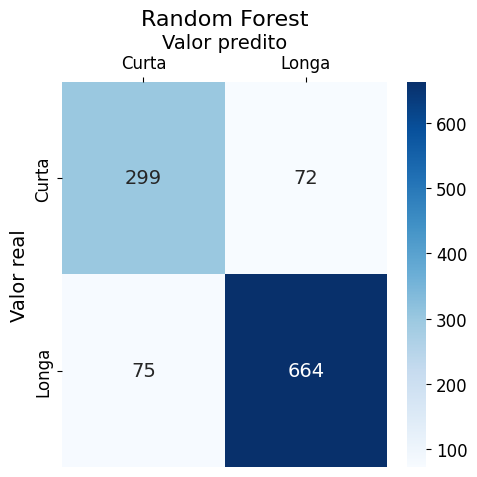

In [134]:
#Configure...
portugues = True
nome_algoritmo = 'Random Forest'

#Outra opção de matriz de confusão
pd.options.display.float_format = '{:.2f}'.format

plt.rcParams["figure.figsize"] = [5.00,5.00]
plt.rcParams["figure.autolayout"] = True

f, ax = plt.subplots(figsize=(5,5))

if portugues:
  sns.heatmap(cm,cmap='Blues',annot=True, cbar_kws={'orientation':'vertical'}, fmt='.0f',xticklabels=["Curta","Longa"],yticklabels=["Curta","Longa"])
  ax.set_xlabel('Valor predito')
  ax.set_ylabel('Valor real')
  #titulo = 'Previsões de sobrevida longa (1) ou curta (0) '+nome_algoritmo
  titulo = nome_algoritmo
  plt.title(titulo)
else:
  sns.heatmap(cm,cmap='Blues',annot=True, cbar_kws={'orientation':'vertical'}, fmt='.0f',xticklabels=["Short","Long"],yticklabels=["Short","Long"])
  ax.set_xlabel('Predicted value')
  ax.set_ylabel('True value')
  titulo = 'Predictions of Long (1) or Short (0) Survival '+nome_algoritmo
  plt.title(titulo)

ax.xaxis.set_ticks_position('top')
ax.xaxis.set_label_position('top')

plt.tick_params(axis='both',which='major', labelbottom = False, top = True, labeltop = True)
plt.show()

AUC: 0.9366


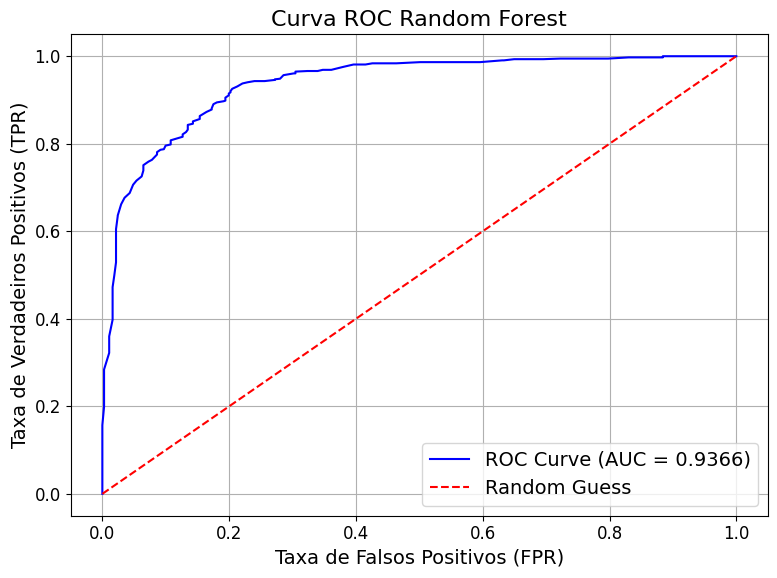

In [135]:
# Probabilidades previstas para a classe positiva (Classe 1)
y_pred_proba = clf.predict_proba(x_teste_norm)[:, 1]
# Obter valores de FPR (False Positive Rate), TPR (True Positive Rate) e thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Calcular a área sob a curva (AUC)
auc_score = roc_auc_score(y_test, y_pred_proba)

print(f"AUC: {auc_score:.4f}")
#Plot
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f"ROC Curve (AUC = {auc_score:.4f})")
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label="Random Guess")
plt.xlabel("Taxa de Falsos Positivos (FPR)")
plt.ylabel("Taxa de Verdadeiros Positivos (TPR)")
plt.title("Curva ROC Random Forest")
plt.legend(loc="lower right")
plt.grid()
plt.show()

### 6.2. Treinando o modelo Regressão logística

In [39]:
print('Treinando o modelo de regressão logística ...',end='')

# Instanciando o modelo
reglog = LogisticRegression()       

reglog.fit(x_treino_norm, y_treino)

Treinando o modelo de regressão logística ...

LogisticRegression()

In [ ]:
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier

#modelo = RandomForestClassifier(random_state=42)
rfe = RFE(estimator=reglog, n_features_to_select=10)
rfe.fit(x_treino_norm, y_treino)
variaveis_selecionadas = x.columns[rfe.support_]
print("Variáveis Selecionadas:", list(variaveis_selecionadas))

#### Realizando previsões

In [40]:
print('Realizando previsões',end=' ')
#previsão para nosso conjunto de teste
y_prev = reglog.predict(x_teste_norm)

#Para o conjunto de dados de treino
y_prev_treino = reglog.predict(x_treino_norm)
print('[ok]')

Realizando previsões [ok]


#### Avaliando o modelo

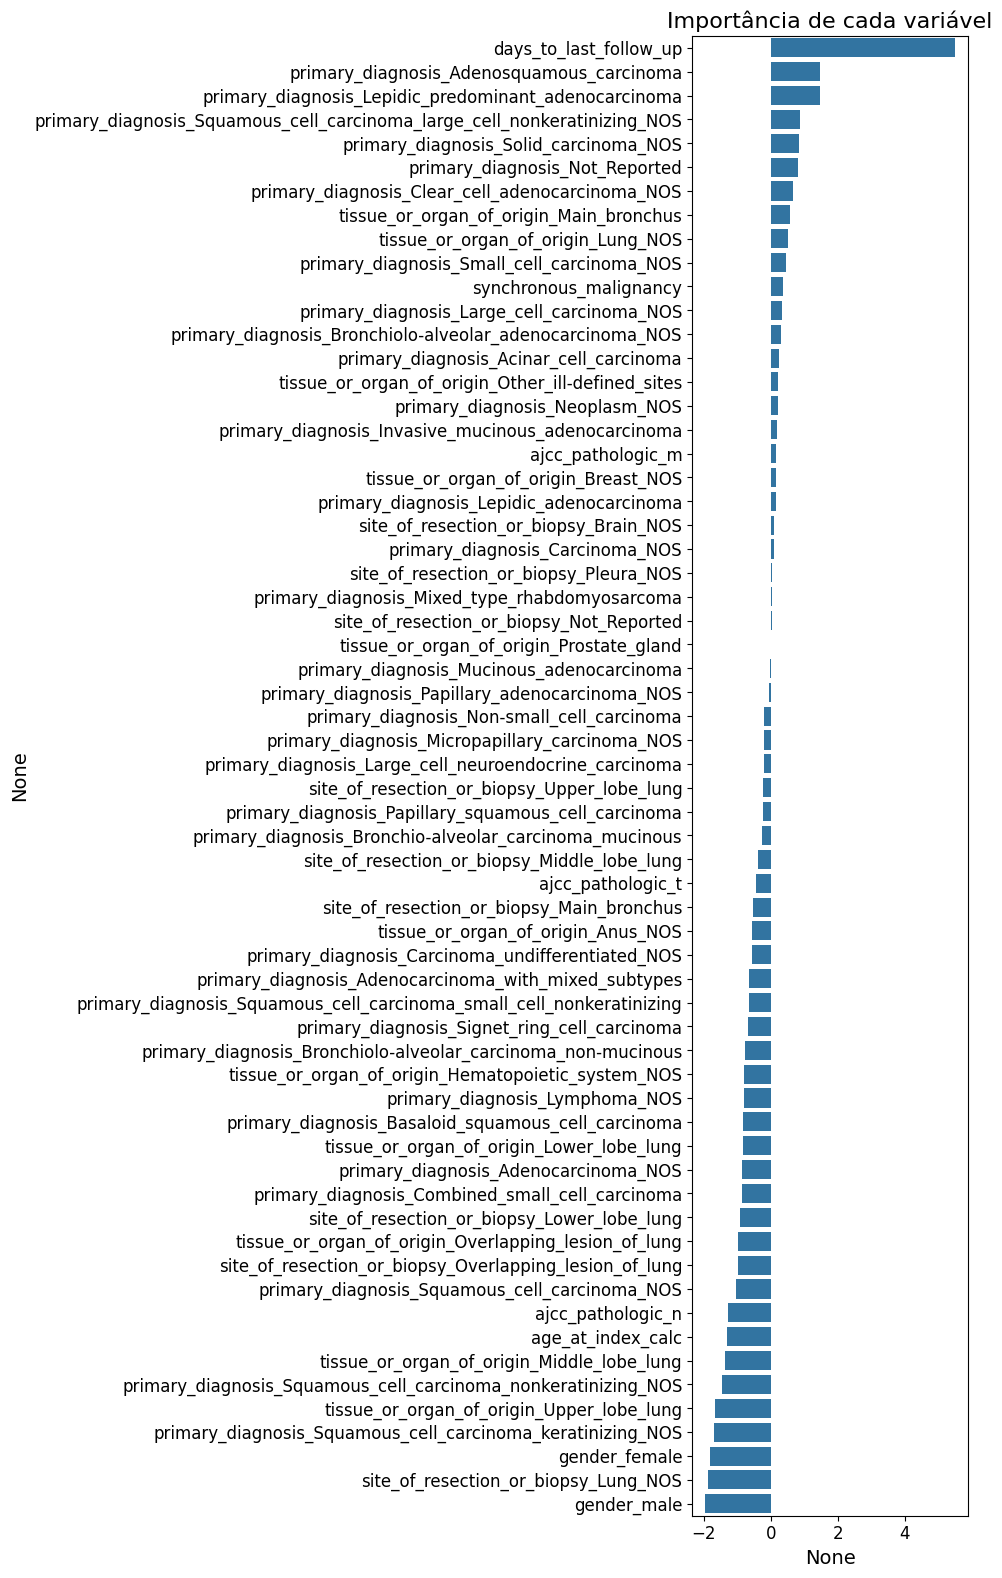

In [41]:
# exibindo a importância de cada variável no modelo preditivo
plt.rcParams['figure.figsize'] = [10.00,16.00]
plt.rcParams['figure.autolayout'] = True
#Importâncias para gráfico geral
importancias_rl = reglog.coef_[0]
importances = pd.Series(data=reglog.coef_[0], index=x.columns)
importances = importances.sort_values(ascending = False)
sns.barplot(x=importances, y=importances.index, orient='h').set_title('Importância de cada variável')
plt.show()

In [42]:
#Matriz de confusão
cm = confusion_matrix(y_test,y_prev)
print(cm)

[[222 149]
 [189 550]]


#### Calculando o G-Mean

In [43]:
tn, fp, fn, tp = confusion_matrix(y_test, y_prev).ravel()

# Calculando sensibilidade e especificidade
sensitivity = tp / (tp + fn)  # Recall para a classe positiva
specificity = tn / (tn + fp)  # Recall para a classe negativa

# Calculando o G-Mean
g_mean = np.sqrt(sensitivity * specificity)

print(f"Sensibilidade: {sensitivity:.4f}")
print(f"Especificidade: {specificity:.4f}")
print(f"G-Mean: {g_mean:.4f}")

Sensibilidade: 0.7442
Especificidade: 0.5984
G-Mean: 0.6673


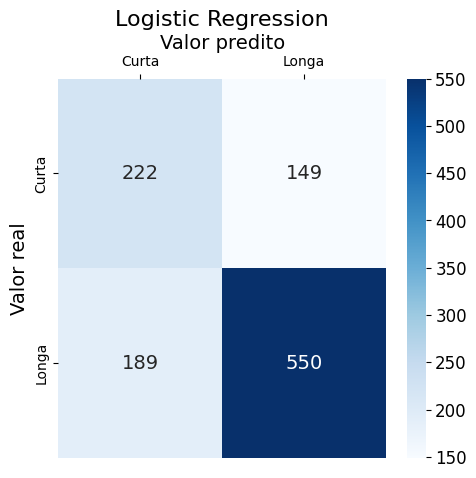

In [44]:
#Configure...
portugues = True
nome_algoritmo = 'Logistic Regression'

#Outra opção de matriz de confusão
pd.options.display.float_format = '{:.2f}'.format

plt.rcParams["figure.figsize"] = [5.00,5.00]
plt.rcParams["figure.autolayout"] = True

f, ax = plt.subplots(figsize=(5,5))

if portugues:
  sns.heatmap(cm,cmap='Blues',annot=True, cbar_kws={'orientation':'vertical'}, fmt='.0f',xticklabels=["Curta","Longa"],yticklabels=["Curta","Longa"])
  ax.set_xlabel('Valor predito')
  ax.set_ylabel('Valor real')
  #titulo = 'Sobrevida longa (1) ou curta (0) '+nome_algoritmo
  titulo = nome_algoritmo
  plt.title(titulo)
else:
  sns.heatmap(cm,cmap='Blues',annot=True, cbar_kws={'orientation':'vertical'}, fmt='.0f',xticklabels=["Short","Long"],yticklabels=["Short","Long"])
  ax.set_xlabel('Predicted value')
  ax.set_ylabel('True value')
  titulo = 'Predictions of Long (1) or Short (0) Survival '+nome_algoritmo
  plt.title(titulo)

ax.xaxis.set_ticks_position('top')
ax.xaxis.set_label_position('top')

plt.tick_params(axis='both',which='major',labelsize=10, labelbottom = False, top = True, labeltop = True)
plt.show()

In [45]:

# Relatórios de classificação
relatorio_treino = classification_report(y_treino, y_prev_treino, output_dict=True)
relatorio_teste = classification_report(y_test, y_prev, output_dict=True)

# Transformar em DataFrames
df_treino = pd.DataFrame(relatorio_treino).transpose()
df_teste = pd.DataFrame(relatorio_teste).transpose()

# Remover a linha de 'accuracy' do corpo principal para exibi-la separadamente
acuracia_treino = df_treino.loc['accuracy', 'f1-score']
acuracia_teste = df_teste.loc['accuracy', 'f1-score']

df_treino = df_treino.drop('accuracy')
df_teste = df_teste.drop('accuracy')

# Exibir os resultados formatados
print('=== Resultados para Logistic Regression ===\n')

print('Relatório de Classificação - Treino')
print(f'Acurácia: {acuracia_treino:.4f}')
display(df_treino.style.format(precision=4).background_gradient(cmap='Blues'))

print('\nRelatório de Classificação - Teste')
print(f'Acurácia: {acuracia_teste:.4f}')
display(df_teste.style.format(precision=4).background_gradient(cmap='Greens'))

print('[ok]')

=== Resultados para Logistic Regression ===

Relatório de Classificação - Treino
Acurácia: 0.7235



Relatório de Classificação - Teste
Acurácia: 0.6955


[ok]


AUC: 0.7451


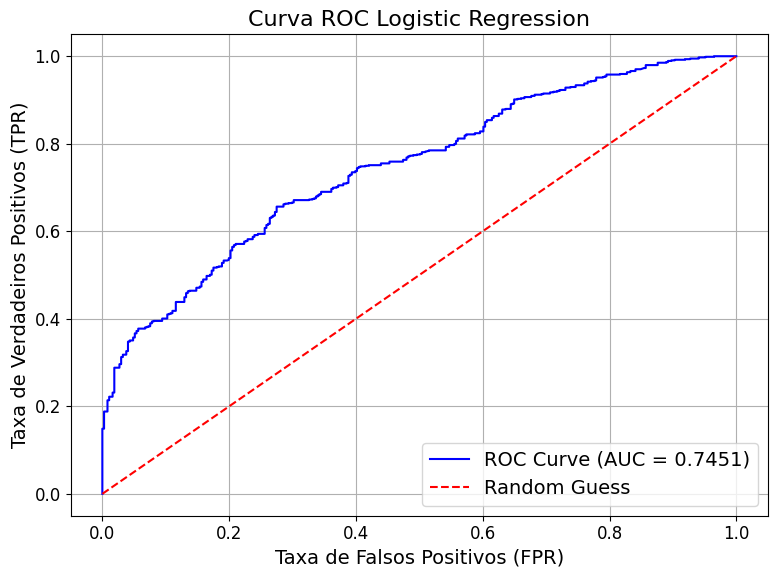

In [46]:
# Probabilidades previstas para a classe positiva (Classe 1)
y_pred_proba = reglog.predict_proba(x_teste_norm)[:, 1]
# Obter valores de FPR (False Positive Rate), TPR (True Positive Rate) e thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Calcular a área sob a curva (AUC)
auc_score = roc_auc_score(y_test, y_pred_proba)

print(f"AUC: {auc_score:.4f}")
#Plot
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f"ROC Curve (AUC = {auc_score:.4f})")
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label="Random Guess")
plt.xlabel("Taxa de Falsos Positivos (FPR)")
plt.ylabel("Taxa de Verdadeiros Positivos (TPR)")
plt.title("Curva ROC Logistic Regression")
plt.legend(loc="lower right")
plt.grid()
plt.show()

### 6.3. Treinando o modelo KNN

In [47]:
print('Treinando o knn ...', end='')

# Ajustando o modelo com os melhores parâmetros
knn = KNeighborsClassifier()

#Treinando
knn.fit(x_treino_norm,y_treino)
print('[ok]')

Treinando o knn ...[ok]


#### Realizando previsões

In [48]:
print('Realizando previsões ...', end='')
previsoes = knn.predict(x_teste_norm)

previsoes_treino = knn.predict(x_treino_norm)
print('[ok]')

Realizando previsões ...[ok]


In [49]:
#Acurácia (dados de teste x o que foi previsto pelo modelo)
acuracia = accuracy_score(y_test,previsoes)
print(acuracia*100)

68.46846846846847


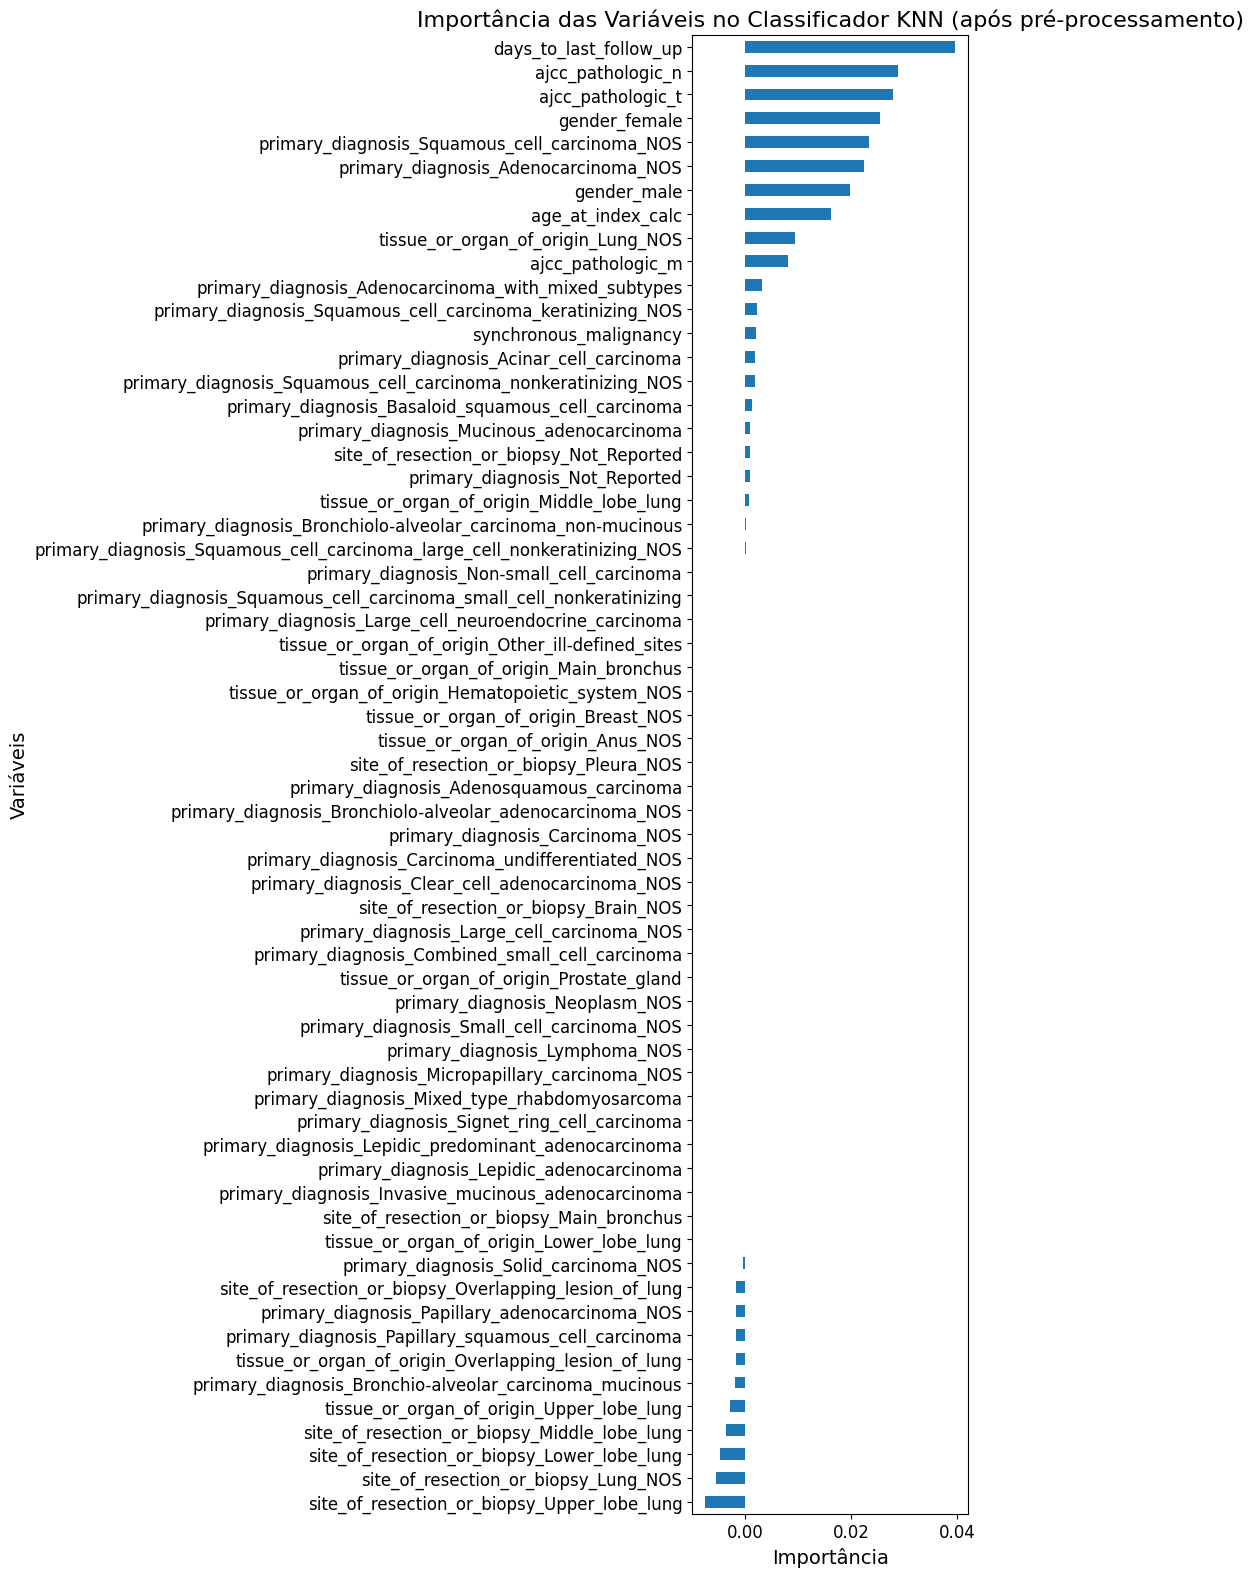

In [50]:
from sklearn.inspection import permutation_importance
# exibindo a importância de cada variável no modelo preditivo
plt.rcParams['figure.figsize'] = [10.00,16.00]
plt.rcParams['figure.autolayout'] = True
perm_importance = permutation_importance(knn, x_teste_norm, y_test, n_repeats=30, random_state=42)
# Converter importâncias para uma série do Pandas
importances = pd.Series(perm_importance.importances_mean, index=x.columns)
#importâncias para o gráfico geral
importancias_knn = importances
# Plotar as importâncias das variáveis
plt.figure(figsize=(10, 16))
importances.sort_values().plot(kind='barh')
plt.xlabel('Importância')
plt.ylabel('Variáveis')
plt.title('Importância das Variáveis no Classificador KNN (após pré-processamento)')
plt.show()

#### Matriz de confusão

In [51]:
#Matriz de confusão
cm = confusion_matrix(y_test,previsoes)
print(cm)

[[248 123]
 [227 512]]


#### Calculando o G-Mean

In [52]:
tn, fp, fn, tp = confusion_matrix(y_test, previsoes).ravel()

# Calculando sensibilidade e especificidade
sensitivity = tp / (tp + fn)  # Recall para a classe positiva
specificity = tn / (tn + fp)  # Recall para a classe negativa

# Calculando o G-Mean
g_mean = np.sqrt(sensitivity * specificity)

print(f"Sensibilidade: {sensitivity:.4f}")
print(f"Especificidade: {specificity:.4f}")
print(f"G-Mean: {g_mean:.4f}")

Sensibilidade: 0.6928
Especificidade: 0.6685
G-Mean: 0.6805


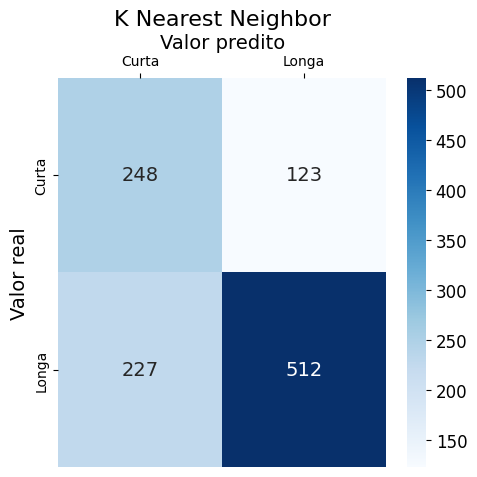

In [53]:
#Configure...
portugues = True
nome_algoritmo = 'K Nearest Neighbor'

#Outra opção de matriz de confusão
pd.options.display.float_format = '{:.2f}'.format

plt.rcParams["figure.figsize"] = [5.00,5.00]
plt.rcParams["figure.autolayout"] = True

f, ax = plt.subplots(figsize=(5,5))

if portugues:
  sns.heatmap(cm,cmap='Blues',annot=True, cbar_kws={'orientation':'vertical'}, fmt='.0f',xticklabels=["Curta","Longa"],yticklabels=["Curta","Longa"])
  ax.set_xlabel('Valor predito')
  ax.set_ylabel('Valor real')
  #titulo = 'Previsões de sobrevida longa (1) ou curta (0) '+nome_algoritmo
  titulo = nome_algoritmo
  plt.title(titulo)
else:
  sns.heatmap(cm,cmap='Blues',annot=True, cbar_kws={'orientation':'vertical'}, fmt='.0f',xticklabels=["Short","Long"],yticklabels=["Short","Long"])
  ax.set_xlabel('Predicted value')
  ax.set_ylabel('True value')
  titulo = 'Predictions of Long (1) or Short (0) Survival '+nome_algoritmo
  plt.title(titulo)

ax.xaxis.set_ticks_position('top')
ax.xaxis.set_label_position('top')

plt.tick_params(axis='both',which='major',labelsize=10, labelbottom = False, top = True, labeltop = True)
plt.show()

In [54]:
# Relatórios de classificação
relatorio_treino = classification_report(y_treino, previsoes_treino, output_dict=True)
relatorio_teste = classification_report(y_test, previsoes, output_dict=True)

# Transformar em DataFrames
df_treino = pd.DataFrame(relatorio_treino).transpose()
df_teste = pd.DataFrame(relatorio_teste).transpose()

# Remover a linha de 'accuracy' do corpo principal para exibi-la separadamente
acuracia_treino = df_treino.loc['accuracy', 'f1-score']
acuracia_teste = df_teste.loc['accuracy', 'f1-score']

df_treino = df_treino.drop('accuracy')
df_teste = df_teste.drop('accuracy')

# Exibir os resultados formatados
print('=== Resultados para KNN ===\n')

print('Relatório de Classificação - Treino')
print(f'Acurácia: {acuracia_treino:.4f}')
display(df_treino.style.format(precision=4).background_gradient(cmap='Blues'))

print('\nRelatório de Classificação - Teste')
print(f'Acurácia: {acuracia_teste:.4f}')
display(df_teste.style.format(precision=4).background_gradient(cmap='Greens'))

print('[ok]')

=== Resultados para KNN ===

Relatório de Classificação - Treino
Acurácia: 0.8131



Relatório de Classificação - Teste
Acurácia: 0.6847


[ok]


AUC: 0.7387


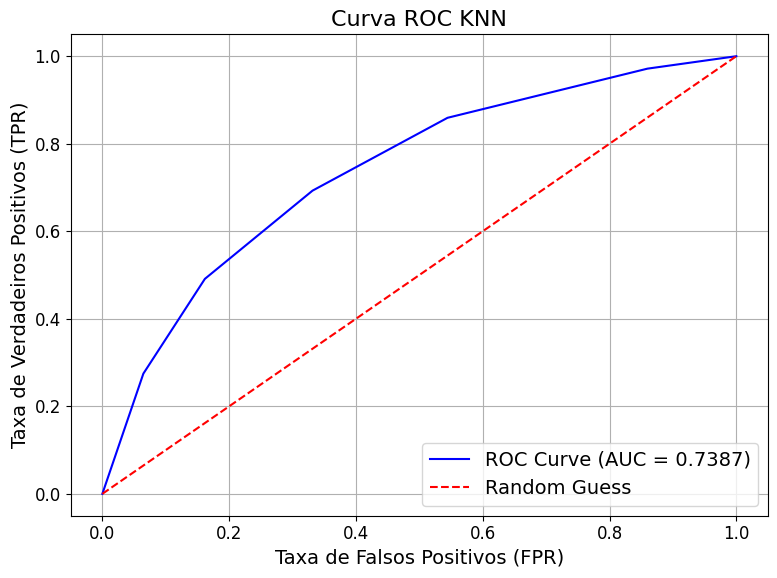

In [55]:
# Probabilidades previstas para a classe positiva (Classe 1)
y_pred_proba = knn.predict_proba(x_teste_norm)[:, 1]
# Obter valores de FPR (False Positive Rate), TPR (True Positive Rate) e thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Calcular a área sob a curva (AUC)
auc_score = roc_auc_score(y_test, y_pred_proba)

print(f"AUC: {auc_score:.4f}")
#Plot
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f"ROC Curve (AUC = {auc_score:.4f})")
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label="Random Guess")
plt.xlabel("Taxa de Falsos Positivos (FPR)")
plt.ylabel("Taxa de Verdadeiros Positivos (TPR)")
plt.title("Curva ROC KNN")
plt.legend(loc="lower right")
plt.grid()
plt.show()

### 6.4. Treinando o modelo Árvore de decisão


In [136]:
# Criando o modelo DecisionTreeClassifier
dt = DecisionTreeClassifier()

In [ ]:
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier

#modelo = RandomForestClassifier(random_state=42)
rfe = RFE(estimator=dt, n_features_to_select=10)
rfe.fit(x_treino_norm, y_treino)
variaveis_selecionadas = x.columns[rfe.support_]
print("Variáveis Selecionadas:", list(variaveis_selecionadas))

In [137]:
# Treinando o modelo
dt.fit(x_treino_norm, y_treino)

DecisionTreeClassifier()

In [138]:
# Fazendo previsões
y_pred_dt = dt.predict(x_teste_norm)

# Para os dados de treino
y_pred_dt_treino = dt.predict(x_treino_norm)

In [139]:
#Acurácia (dados de teste x o que foi previsto pelo modelo)
acuracia = accuracy_score(y_test,y_pred_dt)
print(acuracia*100)

86.93693693693693


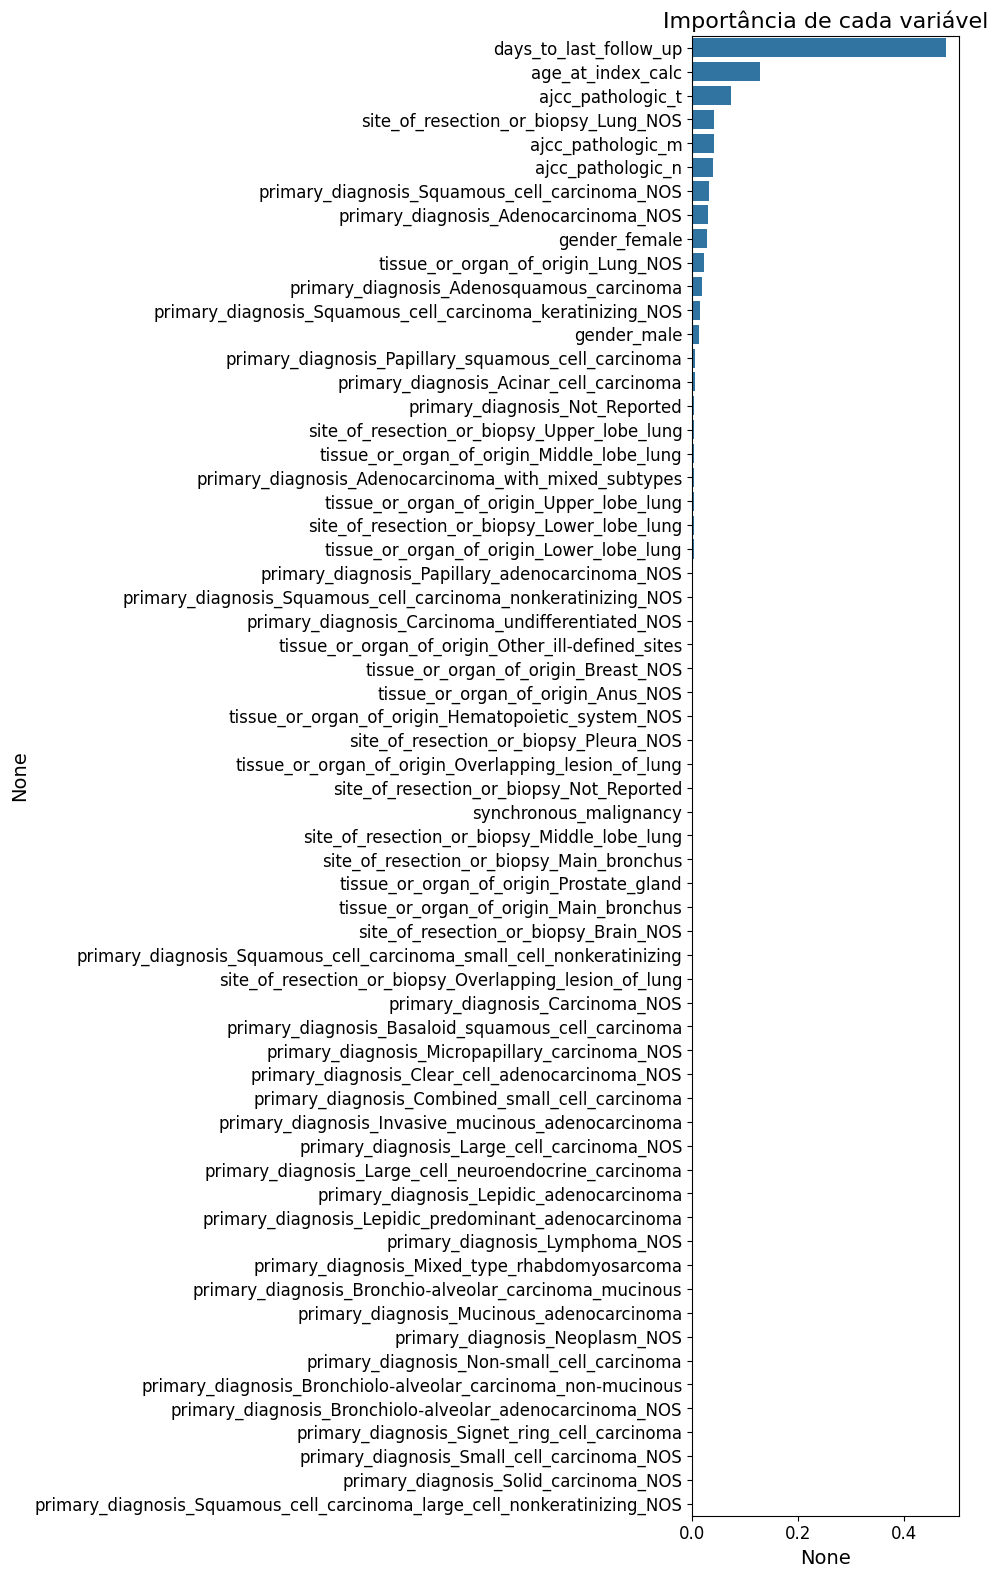

In [61]:
# exibindo a importância de cada variável no modelo preditivo
plt.rcParams['figure.figsize'] = [10.00,16.00]
plt.rcParams['figure.autolayout'] = True
importances = pd.Series(data=dt.feature_importances_, index=x.columns)
#importâncias para o gráfico geral
importancias_dt = importances
importances = importances.sort_values(ascending = False)
sns.barplot(x=importances, y=importances.index, orient='h').set_title('Importância de cada variável')
plt.show()

In [140]:
#Matriz de confusão
cm = confusion_matrix(y_test,y_pred_dt)
print(cm)

[[304  67]
 [ 78 661]]


#### Calculando o G-Mean

In [141]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_dt).ravel()

# Calculando sensibilidade e especificidade
sensitivity = tp / (tp + fn)  # Recall para a classe positiva
specificity = tn / (tn + fp)  # Recall para a classe negativa

# Calculando o G-Mean
g_mean = np.sqrt(sensitivity * specificity)

print(f"Sensibilidade: {sensitivity:.4f}")
print(f"Especificidade: {specificity:.4f}")
print(f"G-Mean: {g_mean:.4f}")

Sensibilidade: 0.8945
Especificidade: 0.8194
G-Mean: 0.8561


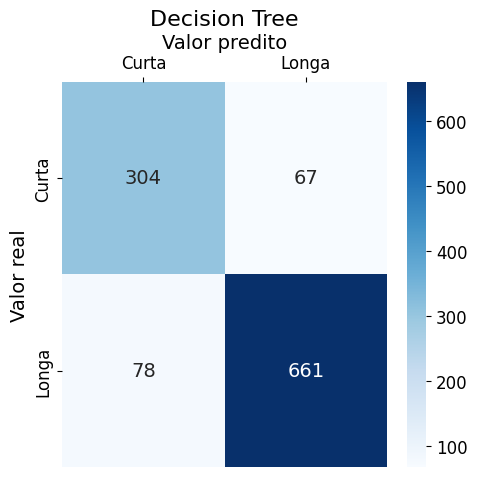

In [142]:
#Configure...
portugues = True
nome_algoritmo = 'Decision Tree'

#Outra opção de matriz de confusão
pd.options.display.float_format = '{:.2f}'.format

plt.rcParams["figure.figsize"] = [5.00,5.00]
plt.rcParams["figure.autolayout"] = True

f, ax = plt.subplots(figsize=(5,5))

if portugues:
  sns.heatmap(cm,cmap='Blues',annot=True, cbar_kws={'orientation':'vertical'}, fmt='.0f',xticklabels=["Curta","Longa"],yticklabels=["Curta","Longa"])
  ax.set_xlabel('Valor predito')
  ax.set_ylabel('Valor real')
  #titulo = 'Previsões de sobrevida longa (1) ou curta (0) '+nome_algoritmo
  titulo = nome_algoritmo
  plt.title(titulo)
else:
  sns.heatmap(cm,cmap='Blues',annot=True, cbar_kws={'orientation':'vertical'}, fmt='.0f',xticklabels=["Short","Long"],yticklabels=["Short","Long"])
  ax.set_xlabel('Predicted value')
  ax.set_ylabel('True value')
  titulo = 'Predictions of Long (1) or Short (0) Survival '+nome_algoritmo
  plt.title(titulo)

ax.xaxis.set_ticks_position('top')
ax.xaxis.set_label_position('top')

plt.tick_params(axis='both',which='major', labelbottom = False, top = True, labeltop = True)
plt.show()

In [144]:
# Relatórios de classificação
relatorio_treino = classification_report(y_treino, y_pred_dt_treino, output_dict=True)
relatorio_teste = classification_report(y_test, y_pred_dt, output_dict=True)

# Transformar em DataFrames
df_treino = pd.DataFrame(relatorio_treino).transpose()
df_teste = pd.DataFrame(relatorio_teste).transpose()

# Remover a linha de 'accuracy' do corpo principal para exibi-la separadamente
acuracia_treino = df_treino.loc['accuracy', 'f1-score']
acuracia_teste = df_teste.loc['accuracy', 'f1-score']

df_treino = df_treino.drop('accuracy')
df_teste = df_teste.drop('accuracy')

# Exibir os resultados formatados
print('=== Resultados para Decision Tree Classifier ===\n')

print('Relatório de Classificação - Treino')
print(f'Acurácia: {acuracia_treino:.4f}')
display(df_treino.style.format(precision=4).background_gradient(cmap='Blues'))

print('\nRelatório de Classificação - Teste')
print(f'Acurácia: {acuracia_teste:.4f}')
display(df_teste.style.format(precision=4).background_gradient(cmap='Greens'))

print('[ok]')

=== Resultados para Decision Tree Classifier ===

Relatório de Classificação - Treino
Acurácia: 0.9994



Relatório de Classificação - Teste
Acurácia: 0.8694


[ok]


AUC: 0.8570


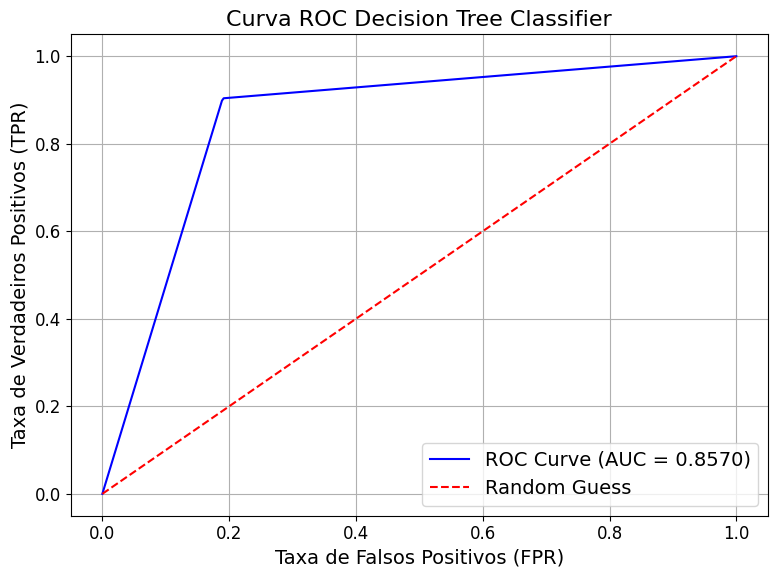

In [66]:
# Probabilidades previstas para a classe positiva (Classe 1)
y_pred_proba = dt.predict_proba(x_teste_norm)[:, 1]
# Obter valores de FPR (False Positive Rate), TPR (True Positive Rate) e thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Calcular a área sob a curva (AUC)
auc_score = roc_auc_score(y_test, y_pred_proba)

print(f"AUC: {auc_score:.4f}")
#Plot
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f"ROC Curve (AUC = {auc_score:.4f})")
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label="Random Guess")
plt.xlabel("Taxa de Falsos Positivos (FPR)")
plt.ylabel("Taxa de Verdadeiros Positivos (TPR)")
plt.title("Curva ROC Decision Tree Classifier")
plt.legend(loc="lower right")
plt.grid()
plt.show()

### 6.5. Teste com o SVM (SVC)

In [67]:
# Criar um modelo SVM com kernel RBF

from sklearn.svm import SVC

# Ajustando o modelo com os melhores parâmetros encontrados
svm = SVC(
    probability=True,     # Permite prever probabilidades (necessário para métricas como ROC-AUC)
)

In [68]:
# Treinar o modelo
svm.fit(x_treino_norm, y_treino)

SVC(probability=True)

In [69]:
# Fazendo previsões
y_pred_svm = svm.predict(x_teste_norm)
# Com os dados de treinamento
y_pred_svm_treino = svm.predict(x_treino_norm)

In [70]:
#Calculando a acurácia
accuracy = accuracy_score(y_test, y_pred_svm)
print(accuracy*100)

71.08108108108108


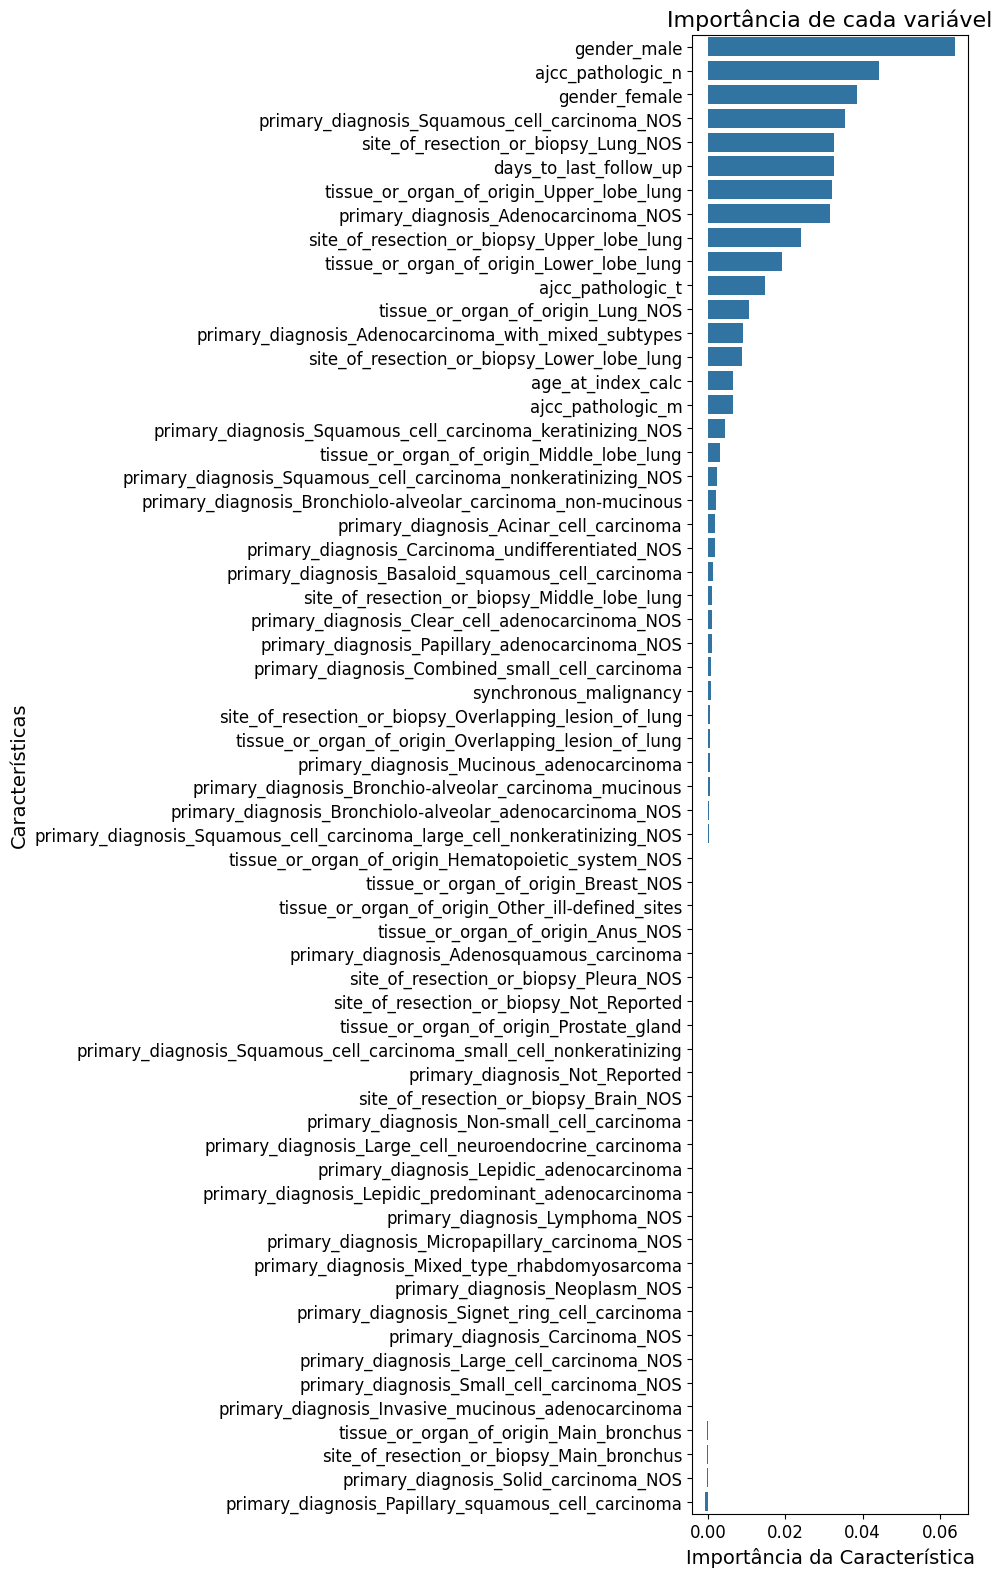

In [71]:
# Calcular a importância das características usando permutation importance
result = permutation_importance(svm, x_teste_norm, y_test, n_repeats=10, random_state=42)

# Obter as importâncias médias e os desvios padrão
importances_mean = result.importances_mean

# Obter os nomes das características
feature_names = x.columns

# Ajustar os parâmetros do matplotlib
plt.rcParams['figure.figsize'] = [10.00, 16.00]
plt.rcParams['figure.autolayout'] = True

# Criar uma série pandas para as importâncias e ordenar
importances = pd.Series(data=importances_mean, index=feature_names)
importances = importances.sort_values(ascending=False)
#importâncias para o gráfico geral
importancias_svm = importances
# Plotar o gráfico de barras usando seaborn
sns.barplot(x=importances, y=importances.index, orient='h').set_title('Importância de cada variável')
plt.xlabel('Importância da Característica')
plt.ylabel('Características')
plt.show()

In [72]:
#Matriz de confusão
cm = confusion_matrix(y_test,y_pred_svm)
print(cm)

[[219 152]
 [169 570]]


#### Calculando o G-Mean

In [73]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_svm).ravel()

# Calculando sensibilidade e especificidade
sensitivity = tp / (tp + fn)  # Recall para a classe positiva
specificity = tn / (tn + fp)  # Recall para a classe negativa

# Calculando o G-Mean
g_mean = np.sqrt(sensitivity * specificity)

print(f"Sensibilidade: {sensitivity:.4f}")
print(f"Especificidade: {specificity:.4f}")
print(f"G-Mean: {g_mean:.4f}")

Sensibilidade: 0.7713
Especificidade: 0.5903
G-Mean: 0.6748


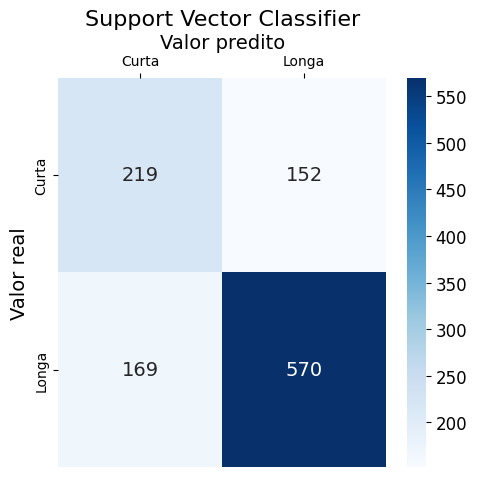

In [74]:
#Configure...
portugues = True
nome_algoritmo = 'Support Vector Classifier'

#Outra opção de matriz de confusão
pd.options.display.float_format = '{:.2f}'.format

plt.rcParams["figure.figsize"] = [5.00,5.00]
plt.rcParams["figure.autolayout"] = True

f, ax = plt.subplots(figsize=(5,5))

if portugues:
  sns.heatmap(cm,cmap='Blues',annot=True, cbar_kws={'orientation':'vertical'}, fmt='.0f',xticklabels=["Curta","Longa"],yticklabels=["Curta","Longa"])
  ax.set_xlabel('Valor predito')
  ax.set_ylabel('Valor real')
  #titulo = 'Previsões de sobrevida longa (1) ou curta (0) '+nome_algoritmo
  titulo = nome_algoritmo
  plt.title(titulo)
else:
  sns.heatmap(cm,cmap='Blues',annot=True, cbar_kws={'orientation':'vertical'}, fmt='.0f',xticklabels=["Short","Long"],yticklabels=["Short","Long"])
  ax.set_xlabel('Predicted value')
  ax.set_ylabel('True value')
  titulo = 'Predictions of Long (1) or Short (0) Survival '+nome_algoritmo
  plt.title(titulo)

ax.xaxis.set_ticks_position('top')
ax.xaxis.set_label_position('top')

plt.tick_params(axis='both',which='major',labelsize=10, labelbottom = False, top = True, labeltop = True)
plt.show()

In [75]:
# Relatórios de classificação
relatorio_treino = classification_report(y_treino, y_pred_svm_treino, output_dict=True)
relatorio_teste = classification_report(y_test, y_pred_svm, output_dict=True)

# Transformar em DataFrames
df_treino = pd.DataFrame(relatorio_treino).transpose()
df_teste = pd.DataFrame(relatorio_teste).transpose()

# Remover a linha de 'accuracy' do corpo principal para exibi-la separadamente
acuracia_treino = df_treino.loc['accuracy', 'f1-score']
acuracia_teste = df_teste.loc['accuracy', 'f1-score']

df_treino = df_treino.drop('accuracy')
df_teste = df_teste.drop('accuracy')

# Exibir os resultados formatados
print('=== Resultados para SVC ===\n')

print('Relatório de Classificação - Treino')
print(f'Acurácia: {acuracia_treino:.4f}')
display(df_treino.style.format(precision=4).background_gradient(cmap='Blues'))

print('\nRelatório de Classificação - Teste')
print(f'Acurácia: {acuracia_teste:.4f}')
display(df_teste.style.format(precision=4).background_gradient(cmap='Greens'))

print('[ok]')

=== Resultados para SVC ===

Relatório de Classificação - Treino
Acurácia: 0.7683



Relatório de Classificação - Teste
Acurácia: 0.7108


[ok]


AUC: 0.7478


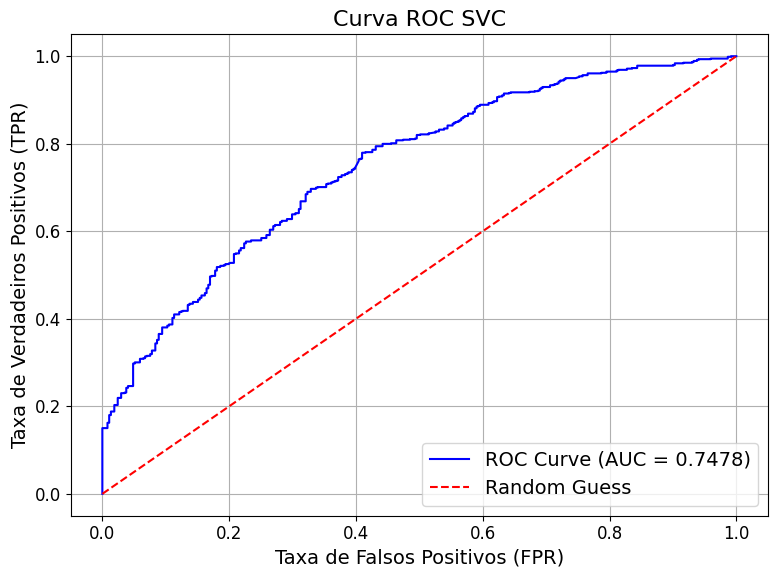

In [76]:
# Probabilidades previstas para a classe positiva (Classe 1)
y_pred_proba = svm.predict_proba(x_teste_norm)[:, 1]
# Obter valores de FPR (False Positive Rate), TPR (True Positive Rate) e thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Calcular a área sob a curva (AUC)
auc_score = roc_auc_score(y_test, y_pred_proba)

print(f"AUC: {auc_score:.4f}")
#Plot
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f"ROC Curve (AUC = {auc_score:.4f})")
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label="Random Guess")
plt.xlabel("Taxa de Falsos Positivos (FPR)")
plt.ylabel("Taxa de Verdadeiros Positivos (TPR)")
plt.title("Curva ROC SVC")
plt.legend(loc="lower right")
plt.grid()
plt.show()

# 7. Validação cruzada

In [77]:
#Confogirações iniciais
n_divisoes = 10

In [78]:
def validacao_cruzada(modelo, X, y, oversampling=False, folds=5):
  if isinstance(X, np.ndarray):
      X = pd.DataFrame(X)
  if isinstance(y, np.ndarray):
      y = pd.DataFrame(y)

  #Kfold do scikit-Learn
  kfold = KFold(n_splits=folds, shuffle=True)

  #Lista de acurácias de cada split
  acuracias_split = []

  #Iterar sobre os splits
  for idx,(idx_treino, idx_validacao) in enumerate(kfold.split(X)):
    X_split_treino = X.iloc[idx_treino,:]
    # Changed line: Use iloc with only one dimension for y
    y_split_treino = y.iloc[idx_treino] #<- Changed this line
    #Aplicar apenas a oversampling so no split de treinamento
    if oversampling:
      sm = SMOTE(random_state=42)
      X_split_treino, y_split_treino = sm.fit_resample(X_split_treino, y_split_treino)

    #Treinar os modelos com a parcela de dados balanaceda
    modelo.fit(X_split_treino, y_split_treino.values.flatten())

    #Separando o conjunto de validação
    X_split_validacao = X.iloc[idx_validacao,:]
    # Changed line: Use iloc with only one dimension for y
    y_split_validacao = y.iloc[idx_validacao] #<- Changed this line

    #Realizando previsões com o conjunto de teste
    predicao = modelo.predict(X_split_validacao)

    #Calcular a acurácia para o split atual
    acuracia_split = accuracy_score(y_split_validacao, predicao)

    #Adicionar a lista
    acuracias_split.append(acuracia_split)

    print(f'Acurácia do split {idx}: {acuracia_split:.4f}')

  #Calcular a acurácia média
  acuracia_media = np.mean(acuracias_split)
  print(f'Acurácia média {acuracia_media:.4f}')

  return acuracia_split

### Random Forest

In [79]:
print('Validação cruzada Random Forest não usando oversampling ')
print(validacao_cruzada(clf, x_treino_norm_n_balanceado, y_treino_n_balanceado, oversampling=False, folds=n_divisoes))

Validação cruzada Random Forest não usando oversampling 
Acurácia do split 0: 0.8084
Acurácia do split 1: 0.8683
Acurácia do split 2: 0.8862
Acurácia do split 3: 0.8916
Acurácia do split 4: 0.8855
Acurácia do split 5: 0.8795
Acurácia do split 6: 0.8855
Acurácia do split 7: 0.8855
Acurácia do split 8: 0.8855
Acurácia do split 9: 0.8494
Acurácia média 0.8726
0.8493975903614458


### Regressão Logística

In [80]:
print('Validação cruzada Regressão Logística não usando oversampling ')
print(validacao_cruzada(reglog, x_treino_norm_n_balanceado, y_treino_n_balanceado, oversampling=False, folds=n_divisoes))

Validação cruzada Regressão Logística não usando oversampling 
Acurácia do split 0: 0.7305
Acurácia do split 1: 0.7126
Acurácia do split 2: 0.6766
Acurácia do split 3: 0.6928
Acurácia do split 4: 0.6988
Acurácia do split 5: 0.6988
Acurácia do split 6: 0.6566
Acurácia do split 7: 0.8012
Acurácia do split 8: 0.7470
Acurácia do split 9: 0.7349
Acurácia média 0.7150
0.7349397590361446


### KNN

In [81]:
print('Validação cruzada KNN não usando oversampling ')
print(validacao_cruzada(knn, x_treino_norm_n_balanceado, y_treino_n_balanceado, oversampling=False, folds=n_divisoes))

Validação cruzada KNN não usando oversampling 
Acurácia do split 0: 0.7006
Acurácia do split 1: 0.6707
Acurácia do split 2: 0.6707
Acurácia do split 3: 0.6687
Acurácia do split 4: 0.6988
Acurácia do split 5: 0.6687
Acurácia do split 6: 0.7711
Acurácia do split 7: 0.6627
Acurácia do split 8: 0.7651
Acurácia do split 9: 0.6506
Acurácia média 0.6927
0.6506024096385542


### Decision Tree

In [82]:
print('Validação cruzada Decicion Tree não usando oversampling ')
print(validacao_cruzada(dt, x_treino_norm_n_balanceado, y_treino_n_balanceado, oversampling=False, folds=n_divisoes))

Validação cruzada Decicion Tree não usando oversampling 
Acurácia do split 0: 0.8862
Acurácia do split 1: 0.8263
Acurácia do split 2: 0.8263
Acurácia do split 3: 0.8253
Acurácia do split 4: 0.8253
Acurácia do split 5: 0.8735
Acurácia do split 6: 0.8916
Acurácia do split 7: 0.8675
Acurácia do split 8: 0.8614
Acurácia do split 9: 0.8855
Acurácia média 0.8569
0.8855421686746988


### SVC

In [83]:
print('Validação cruzada  Support Vector Classifier não usando oversampling ')
print(validacao_cruzada(svm, x_treino_norm_n_balanceado, y_treino_n_balanceado, oversampling=False, folds=n_divisoes))

Validação cruzada  Support Vector Classifier não usando oversampling 
Acurácia do split 0: 0.6287
Acurácia do split 1: 0.7246
Acurácia do split 2: 0.6467
Acurácia do split 3: 0.6386
Acurácia do split 4: 0.7048
Acurácia do split 5: 0.6687
Acurácia do split 6: 0.7349
Acurácia do split 7: 0.6988
Acurácia do split 8: 0.6867
Acurácia do split 9: 0.7108
Acurácia média 0.6843
0.7108433734939759


# 8. Shap


In [86]:
# Importar o módulo shap
import shap

# Nomes das colunas
feature_names = x.columns

# Explicador para RandomForestClassifier
explainer_rf = shap.Explainer(clf.predict_proba, x_teste_norm , feature_names=feature_names)
# Explicador para DecisionTreeClassifier
explainer_dt = shap.Explainer(dt.predict_proba, x_teste_norm , feature_names=feature_names)
# Explicador para LogisticRegression
explainer_lr = shap.Explainer(reglog.predict_proba, x_teste_norm , feature_names=feature_names)
# Explicador para KNN
explainer_knn = shap.Explainer(knn.predict_proba, x_teste_norm , feature_names=feature_names)
# Explicador para SVC (SVM)
explainer_svc = shap.Explainer(svm.predict_proba, x_teste_norm , feature_names=feature_names)

# Calculando os valores de SHAP para cada modelo
# RandomForestClassifier
shap_values_rf = explainer_rf(x_teste_norm)
# DecisionTreeClassifier
shap_values_dt = explainer_dt(x_teste_norm)
# LogisticRegression
shap_values_lr = explainer_lr(x_teste_norm)
# KNN
shap_values_knn = explainer_knn(x_teste_norm)
# SVC
shap_values_svc = explainer_svc(x_teste_norm)

#Obtém SHAP values para a classe 1 RandomForestClassifier
shap_values_rf_class1 = shap_values_rf[..., 1]
#Obtém SHAP values para a classe 1 DecisionTreeClassifier
shap_values_dt_class1 = shap_values_dt[..., 1]
#Obtém SHAP values para a classe 1 LogisticRegression
shap_values_lr_class1 = shap_values_lr[..., 1]
#Obtém SHAP values para a classe 1 KNN
shap_values_knn_class1 = shap_values_knn[..., 1]
#Obtém SHAP values para a classe 1 SVC
shap_values_svc_class1 = shap_values_svc[..., 1]




PermutationExplainer explainer: 1111it [02:46,  6.53it/s]                          
PermutationExplainer explainer: 1111it [00:14, 22.17it/s]                          
PermutationExplainer explainer: 1111it [00:17, 27.70it/s]                          
PermutationExplainer explainer: 1111it [02:23,  7.25it/s]                          
PermutationExplainer explainer: 1111it [25:59,  1.41s/it]                          


In [ ]:
print(x_teste_norm.shape)  # Número de linhas e colunas do dataset
print(len(feature_names))  # Comprimento da lista de nomes das features

#Obtém SHAP values para a classe 1 RandomForestClassifier
shap_values_rf_class1 = shap_values_rf[..., 1]
#Obtém SHAP values para a classe 1 DecisionTreeClassifier
shap_values_dt_class1 = shap_values_dt[..., 1]
#Obtém SHAP values para a classe 1 LogisticRegression
shap_values_lr_class1 = shap_values_lr[..., 1]
#Obtém SHAP values para a classe 1 KNN
shap_values_knn_class1 = shap_values_knn[..., 1]
#Obtém SHAP values para a classe 1 SVC
shap_values_svc_class1 = shap_values_svc[..., 1]

print("Shape de x_teste_norm:", x_teste_norm.shape)
print("Shape de shap_values_rf[:, 1]:", shap_values_rf[:, 1].shape)

print("Shape de x_teste_norm:", x_teste_norm.shape)
print("Shape de shap_values_rf_class1:", shap_values_rf_class1.shape)


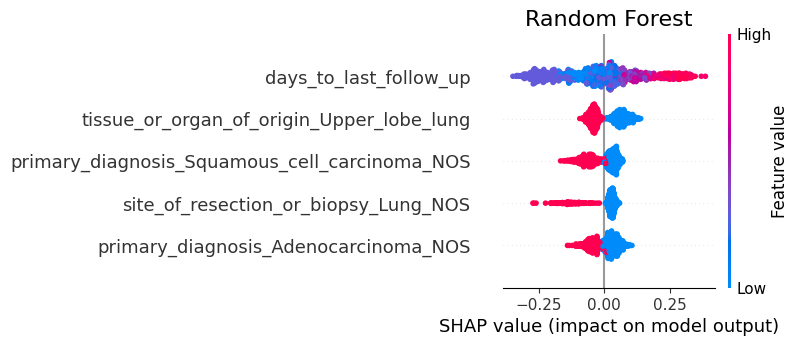

In [87]:
# Summary plot 
shap.summary_plot(shap_values_rf_class1, x_teste_norm, show=False, max_display=5)

# Ajustar o tamanho e o título do gráfico
plt.title("Random Forest")

# Exibir o gráfico ajustado
plt.show()

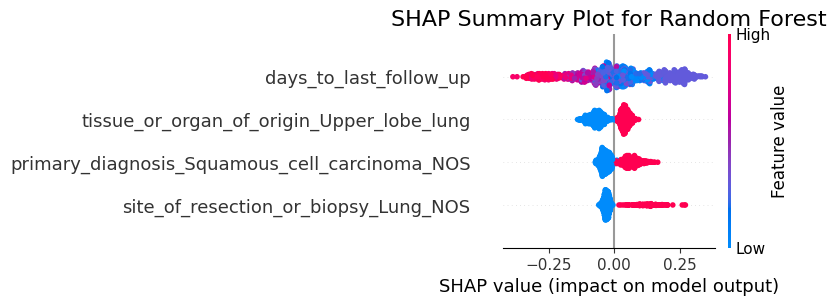

In [88]:
shap_values_rf_class0 = shap_values_rf[..., 0]
# Summary plot 
shap.summary_plot(shap_values_rf_class0, x_teste_norm, show=False, max_display=4)

# Ajustar o tamanho e o título do gráfico
plt.title("SHAP Summary Plot for Random Forest")

# Exibir o gráfico ajustado
plt.show()

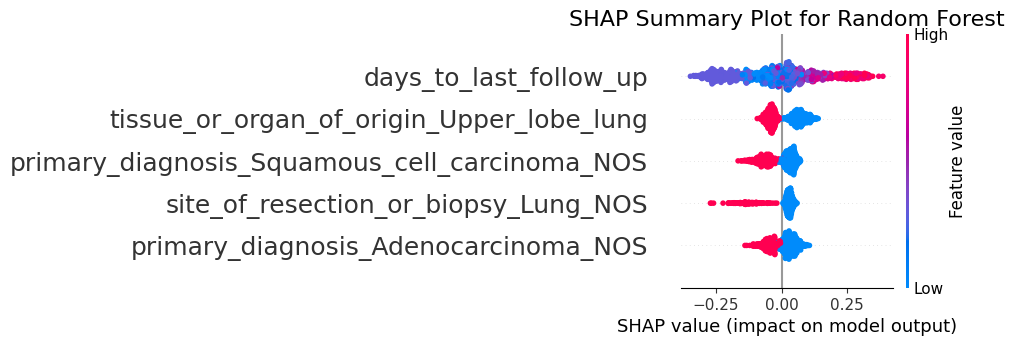

In [89]:
# Gerar o summary plot sem exibir
shap.summary_plot(shap_values_rf_class1, x_teste_norm, show=False, max_display=5)

# Ajustar o tamanho do gráfico
#plt.gcf().set_size_inches(20, 6)  # Largura x Altura
plt.title("SHAP Summary Plot for Random Forest")

# Aumentar o tamanho da fonte das features no eixo Y
ax = plt.gca()  # Obter o eixo atual
ax.tick_params(axis='y', labelsize=18)  # Ajustar o tamanho da fonte dos rótulos do eixo Y

# Exibir o gráfico ajustado
plt.show()

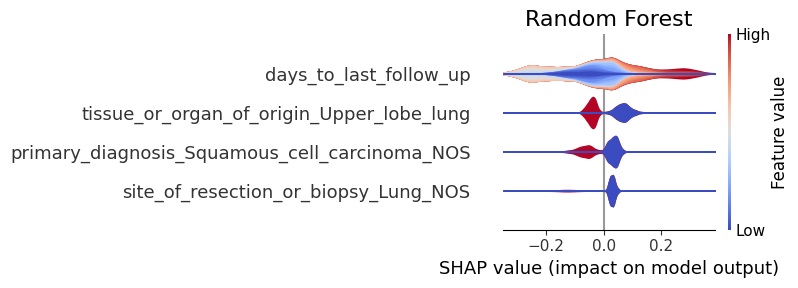

In [90]:
# Violin plot
shap.plots.violin(shap_values_rf_class1, features=x_teste_norm, feature_names=feature_names, plot_type="layered_violin", show=False, max_display=4)
plt.title("Random Forest")
plt.show()

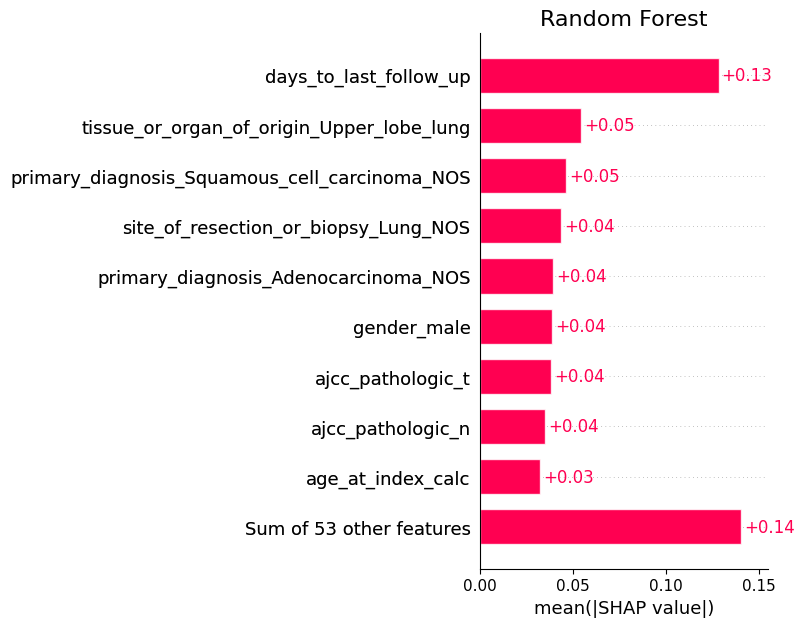

In [91]:
# importância das variáveis
shap.plots.bar(shap_values_rf_class1, show=False)
plt.title("Random Forest")
plt.show()

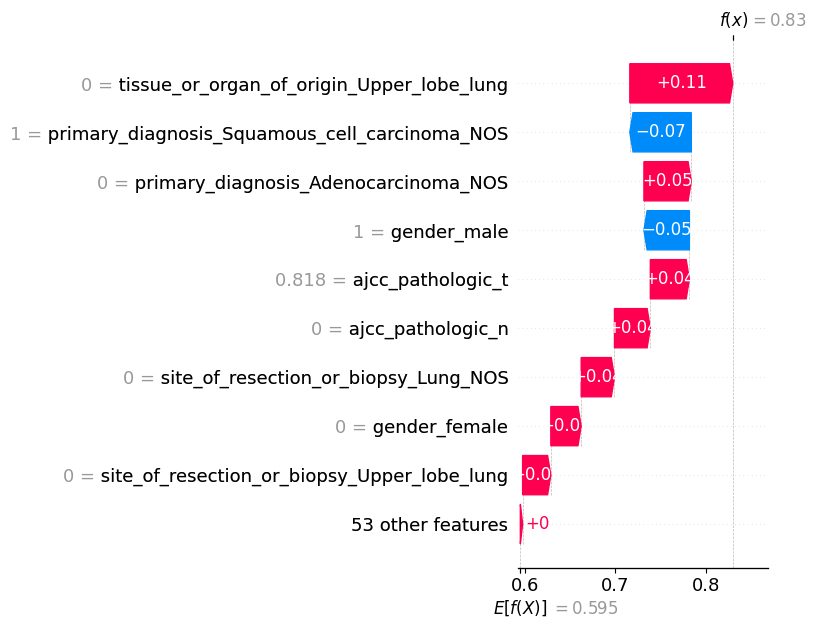

In [92]:
# Para a primeira observação no conjunto de teste
shap.waterfall_plot(shap_values_rf_class1[0])

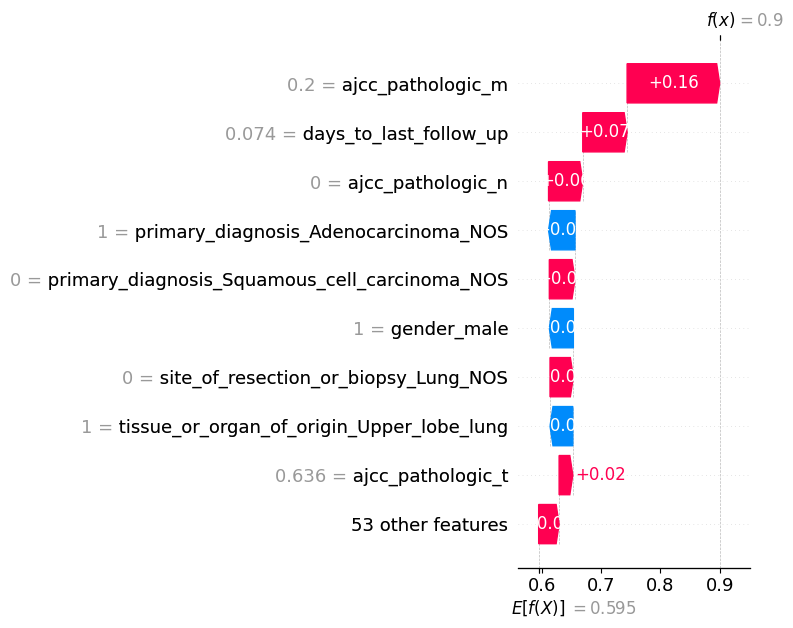

In [93]:
# Explica uma instância específica (índice)
shap.plots.waterfall(shap_values_rf_class1[3])

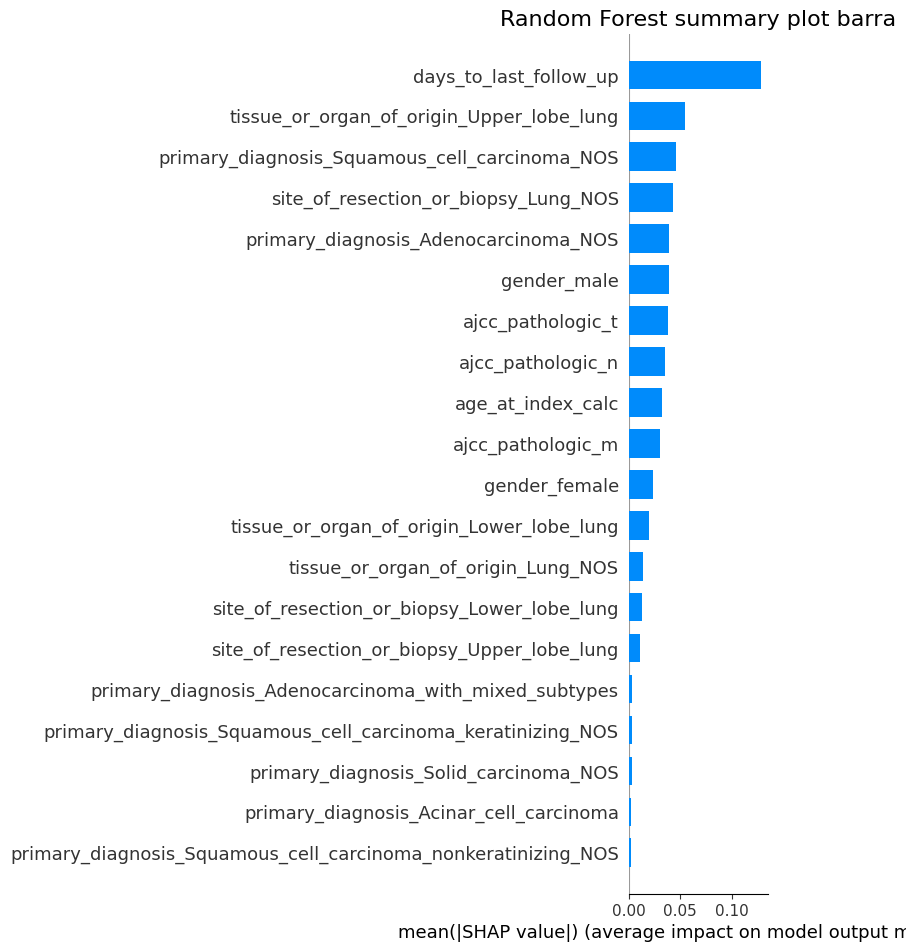

In [94]:
shap.summary_plot(shap_values_rf_class1, x_teste_norm, plot_type="bar", show=False)
plt.title("Random Forest summary plot barra")
plt.show()

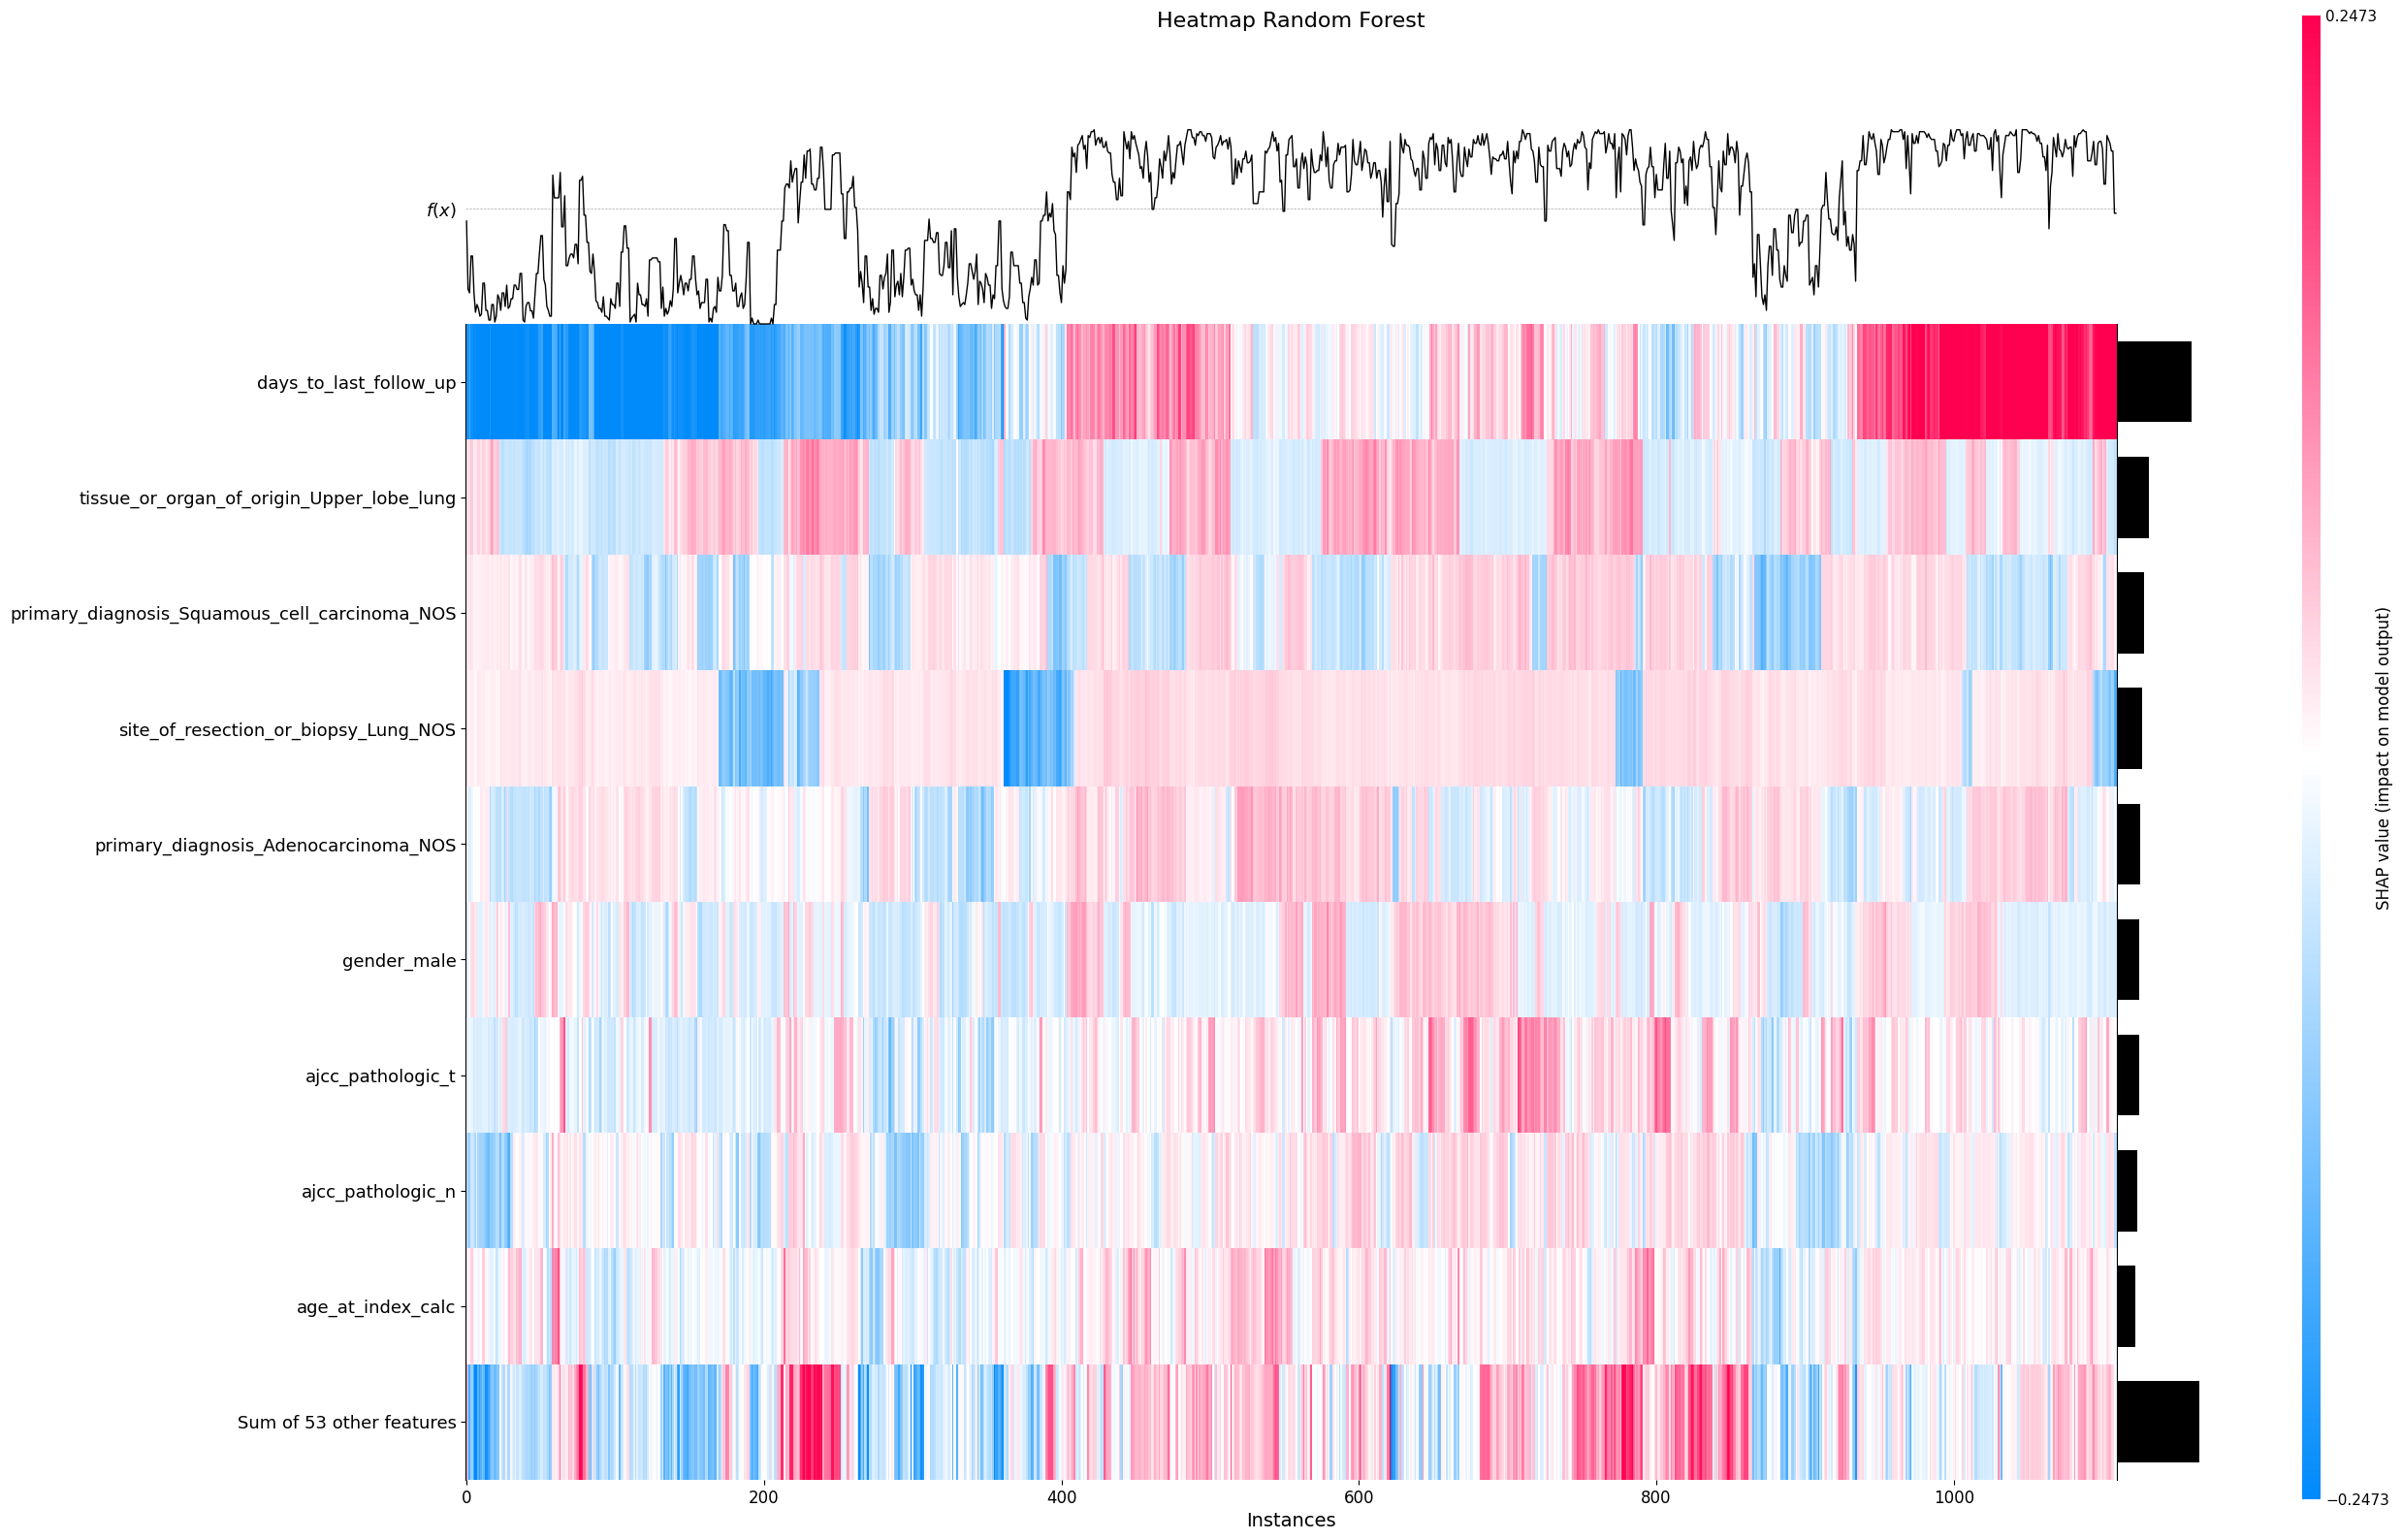

In [95]:
shap.plots.heatmap(shap_values_rf_class1, show=False)
plt.title("Heatmap Random Forest")
plt.gcf().set_size_inches(25, 25)
plt.show()

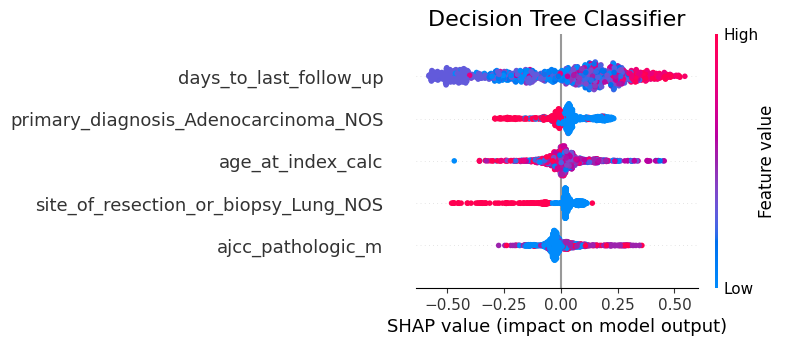

In [96]:
#Obtém SHAP values para a classe 1
shap_values_dt_class1 = shap_values_dt[..., 1]

shap.summary_plot(shap_values_dt_class1, x_teste_norm, show=False, max_display=5)

# Ajustar o tamanho e o título do gráfico
plt.title("Decision Tree Classifier")
# Exibir o gráfico ajustado
plt.show()

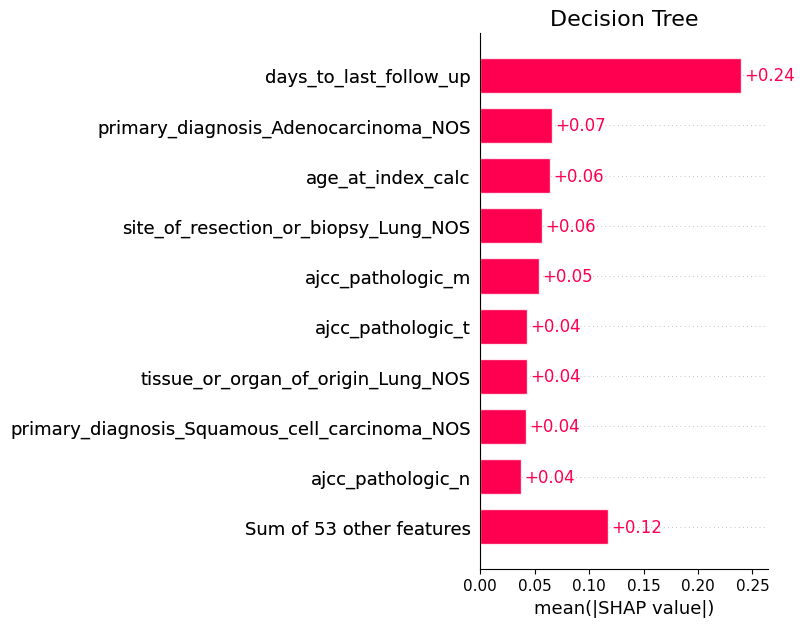

In [97]:
# importância das variáveis
shap.plots.bar(shap_values_dt_class1, show=False)
plt.title("Decision Tree")
plt.show()

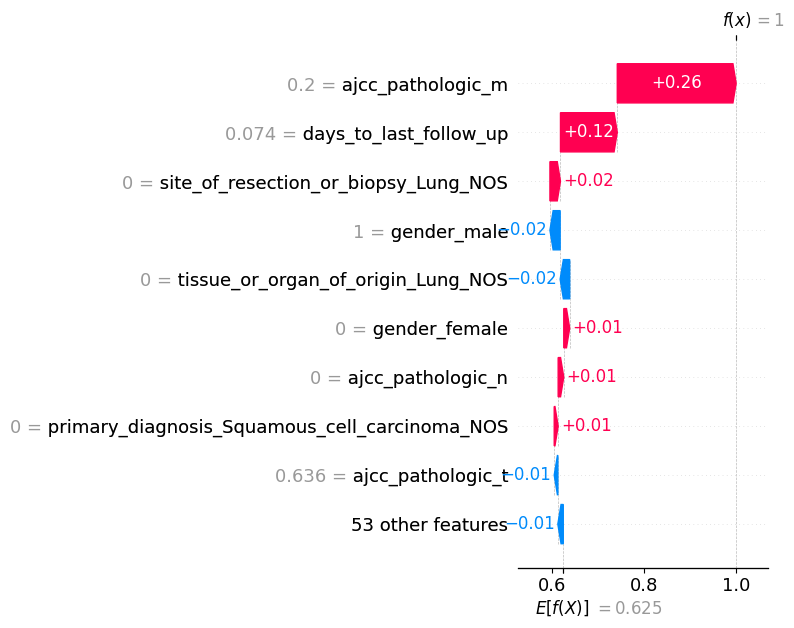

In [98]:
# Explica uma instância específica (índice)
shap.plots.waterfall(shap_values_dt_class1[3])

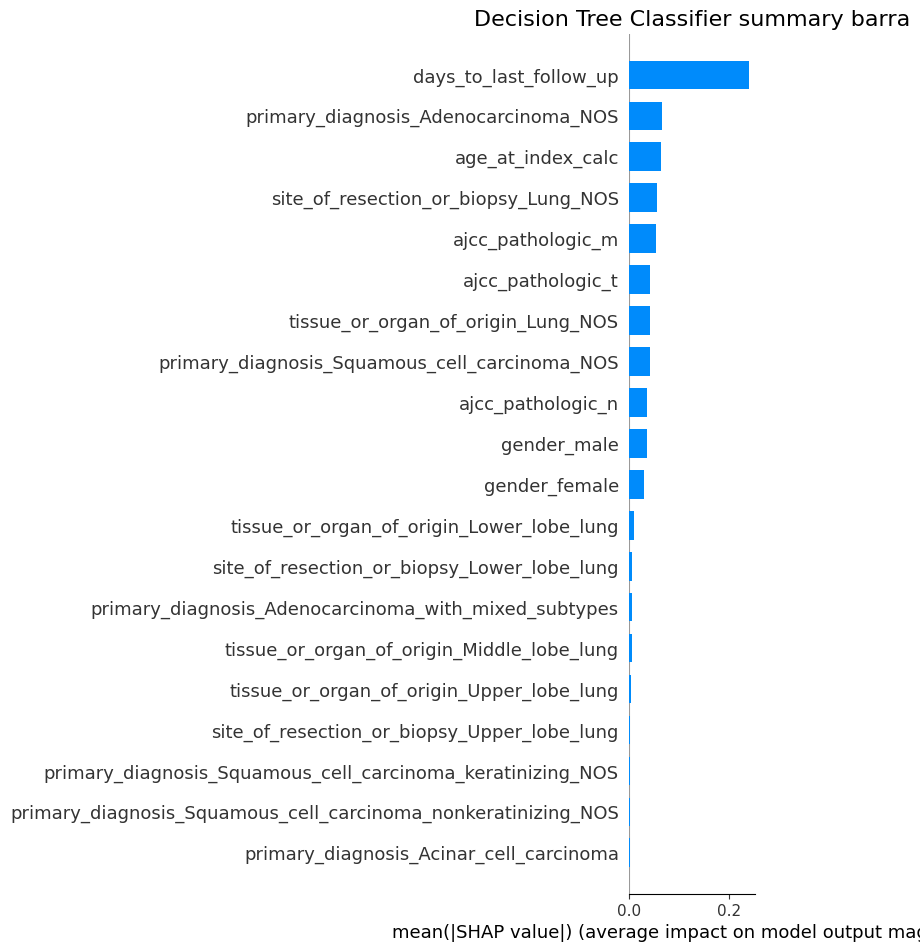

In [99]:
shap.summary_plot(shap_values_dt_class1, x_teste_norm, plot_type="bar", show=False)
plt.title("Decision Tree Classifier summary barra")
plt.show()

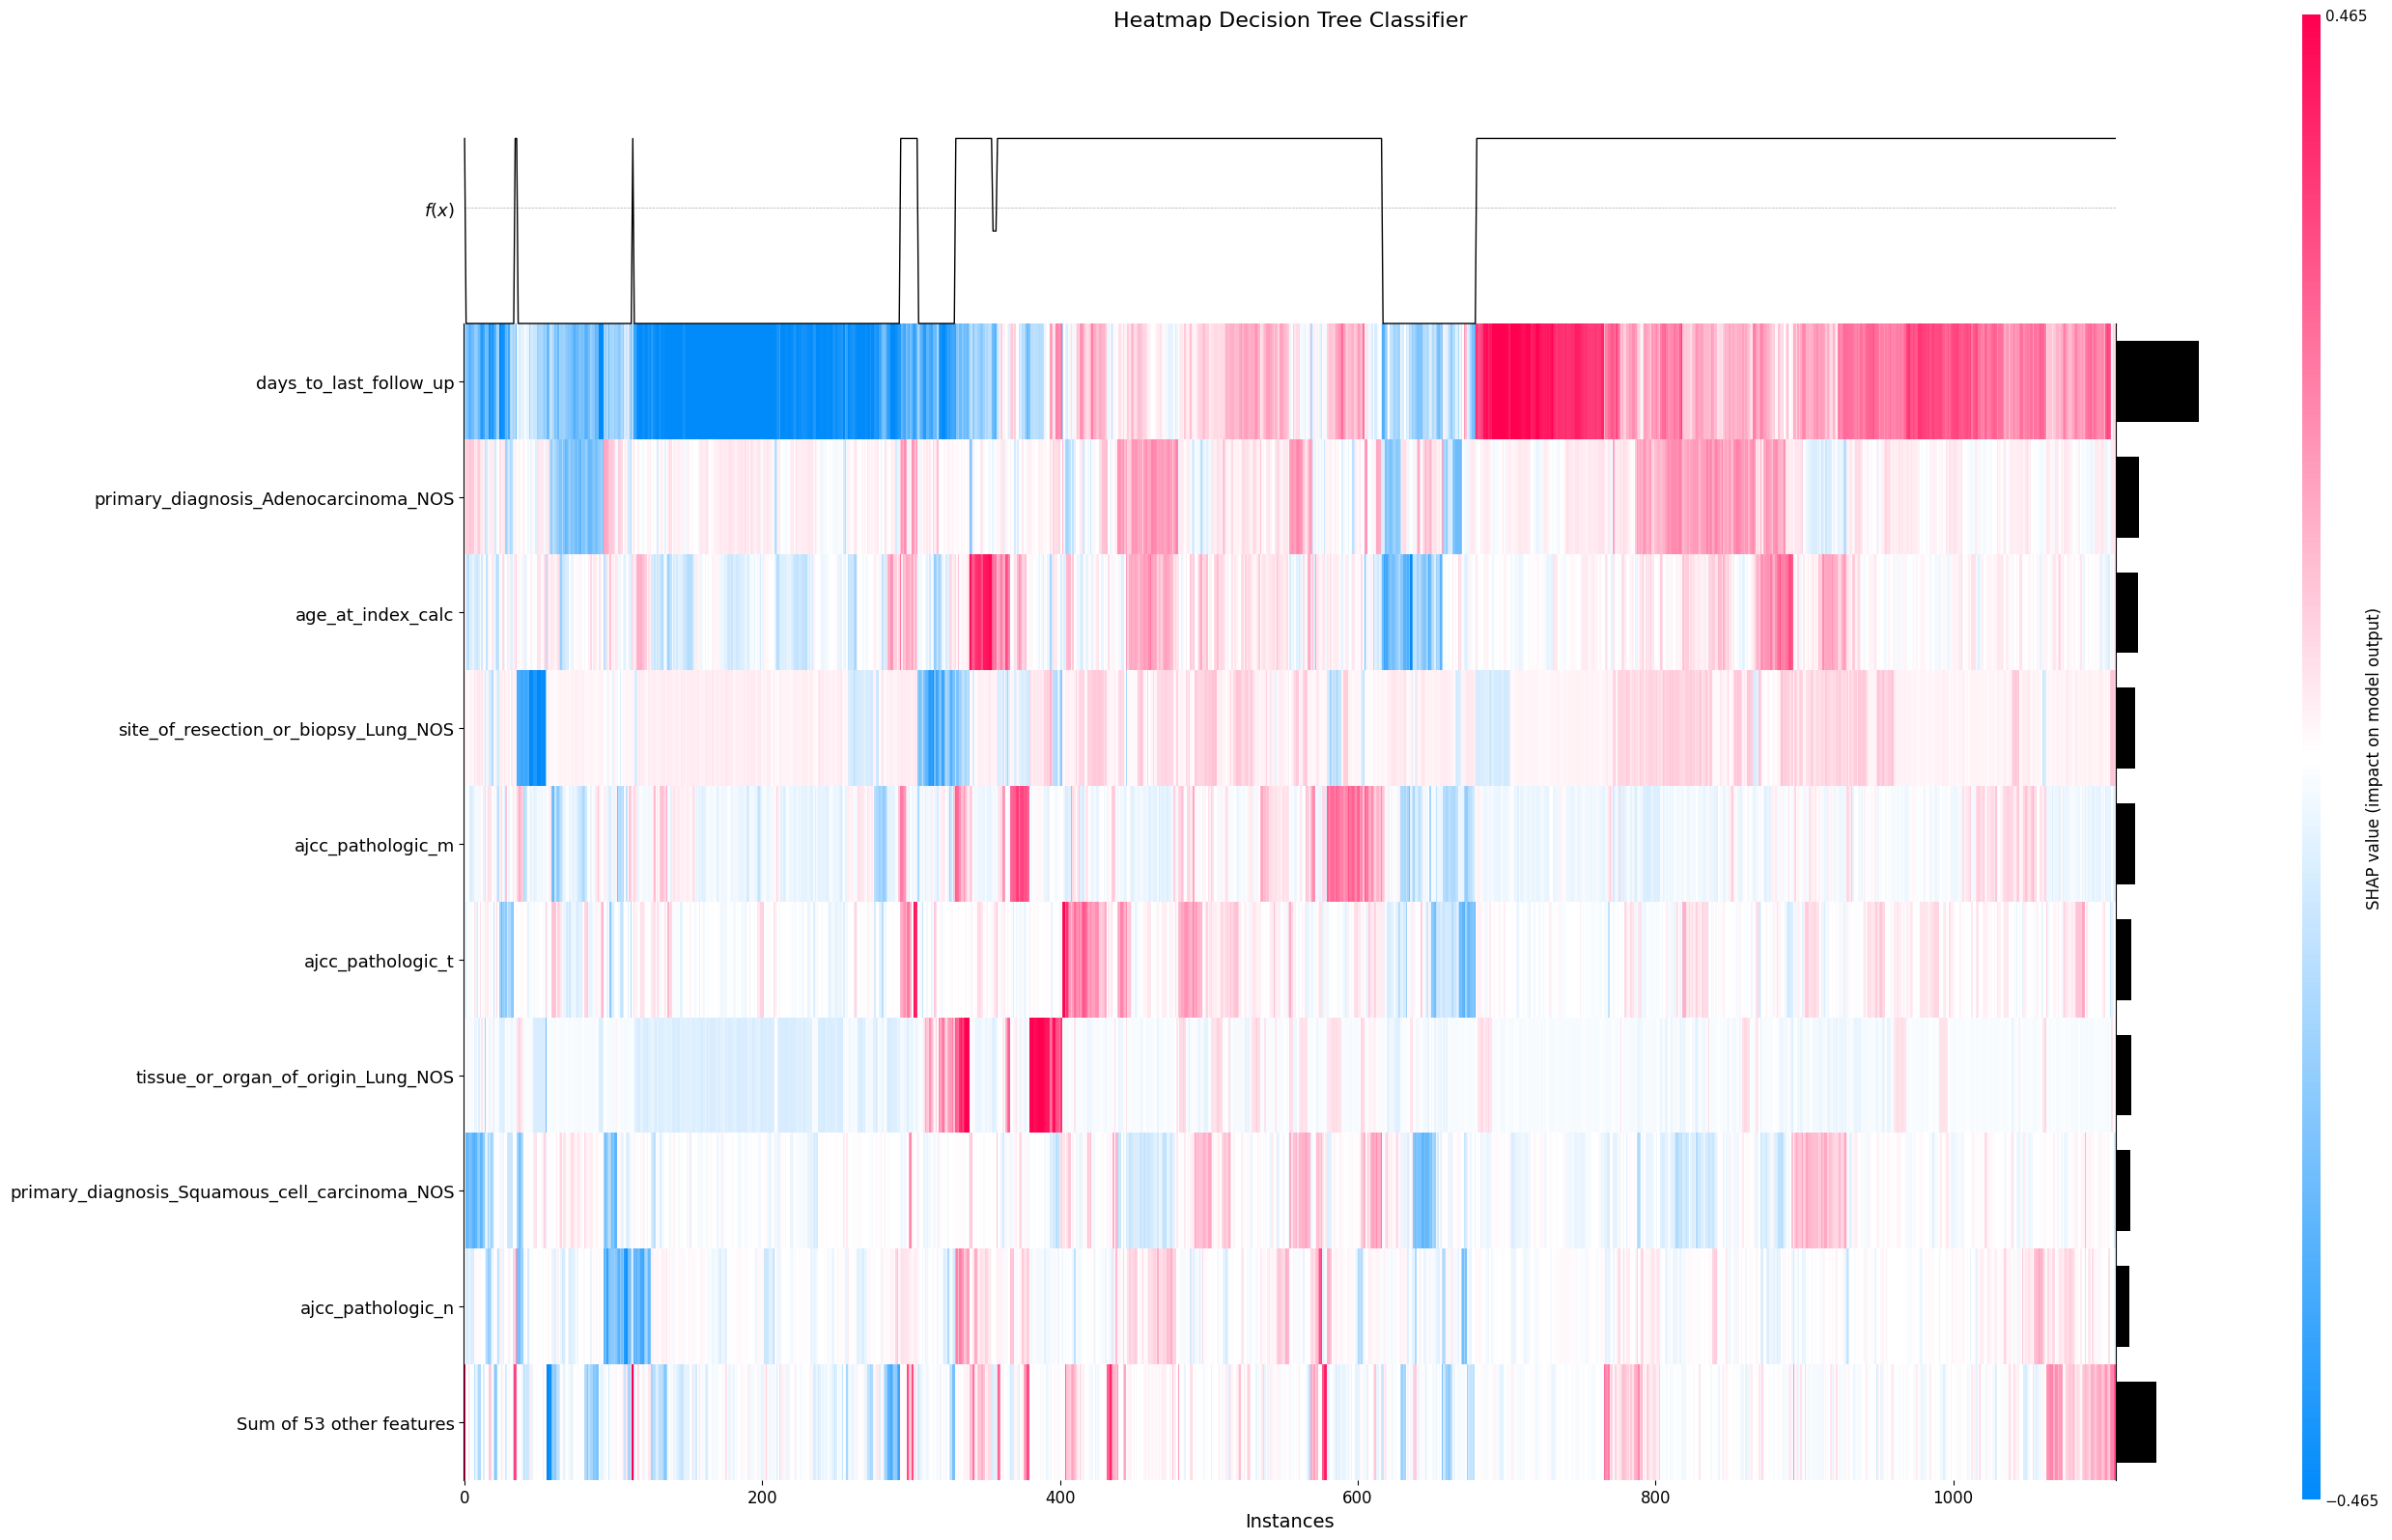

In [100]:
shap.plots.heatmap(shap_values_dt_class1, show=False)
plt.title("Heatmap Decision Tree Classifier")
plt.gcf().set_size_inches(25, 25)
plt.show()

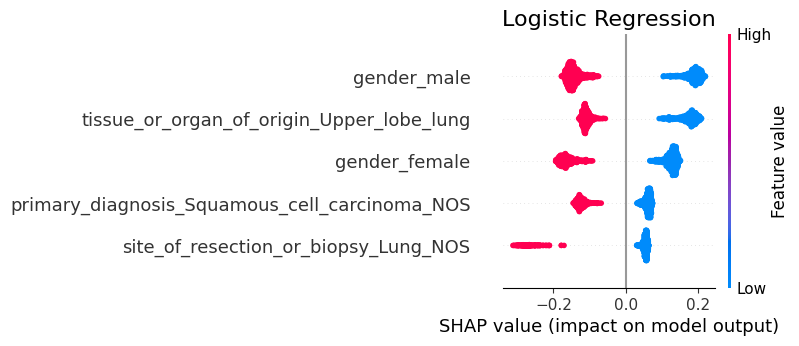

In [101]:
shap.summary_plot(shap_values_lr_class1, x_teste_norm, show=False, max_display=5)

plt.title("Logistic Regression")
# Ajustar o tamanho e o título do gráfico
plt.title("Logistic Regression")  # Define o título e o tamanho da fonte

# Exibir o gráfico ajustado
plt.show()

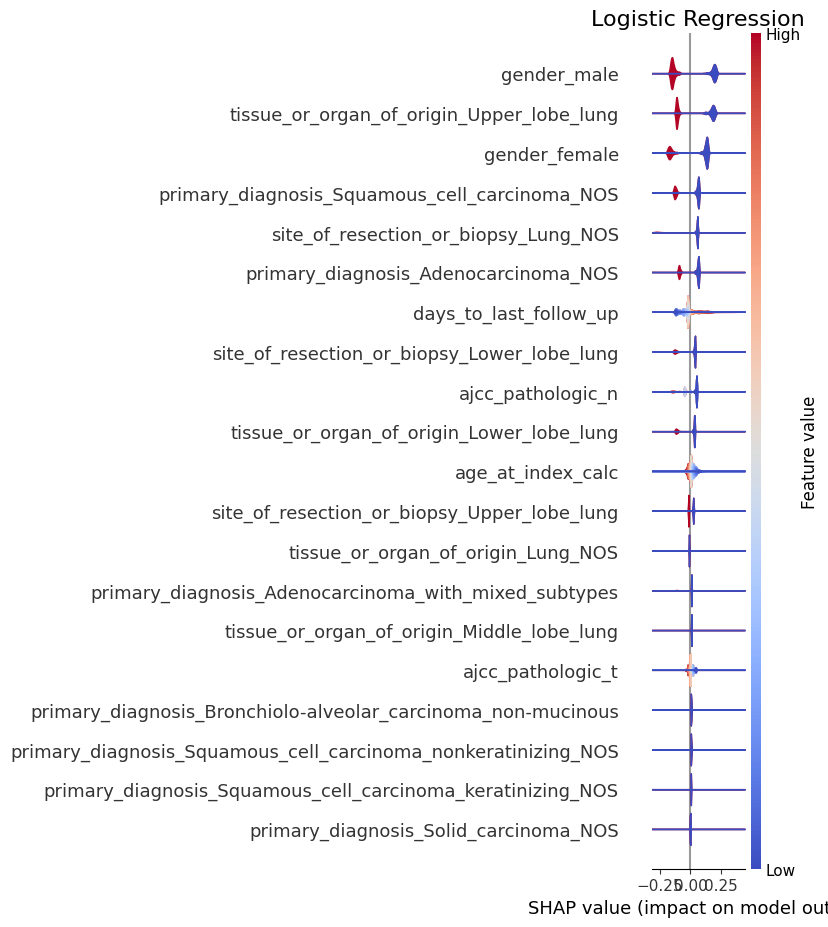

In [102]:
# Violin plot
shap.plots.violin(shap_values_lr_class1, features=x_teste_norm, feature_names=feature_names, plot_type="layered_violin", show=False)
plt.title("Logistic Regression")
plt.show()

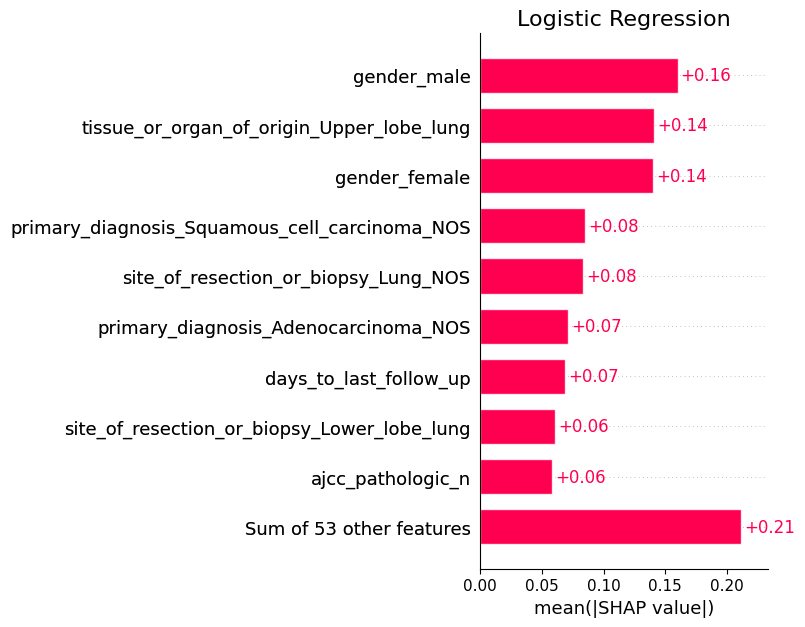

In [103]:
# importância das variáveis
shap.plots.bar(shap_values_lr_class1, show=False)
plt.title("Logistic Regression")
plt.show()

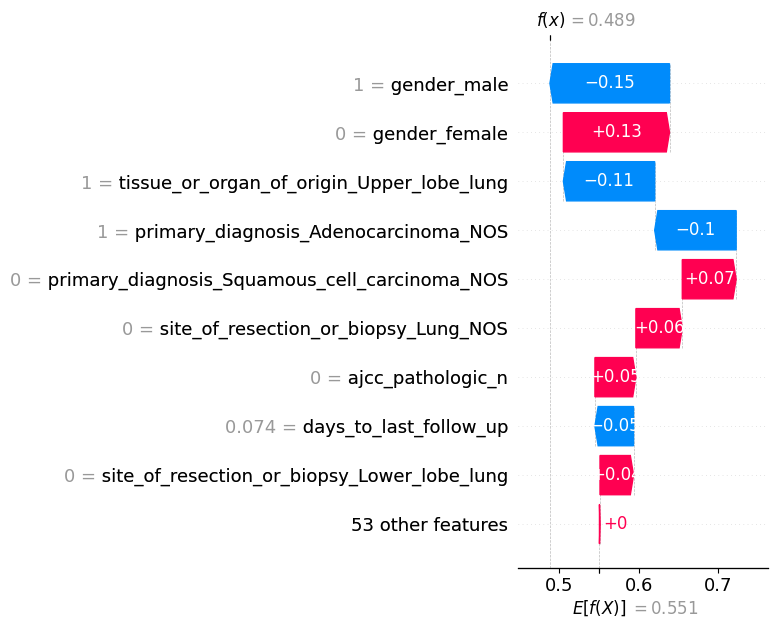

In [104]:
# Explica uma instância específica (índice)
shap.plots.waterfall(shap_values_lr_class1[3])

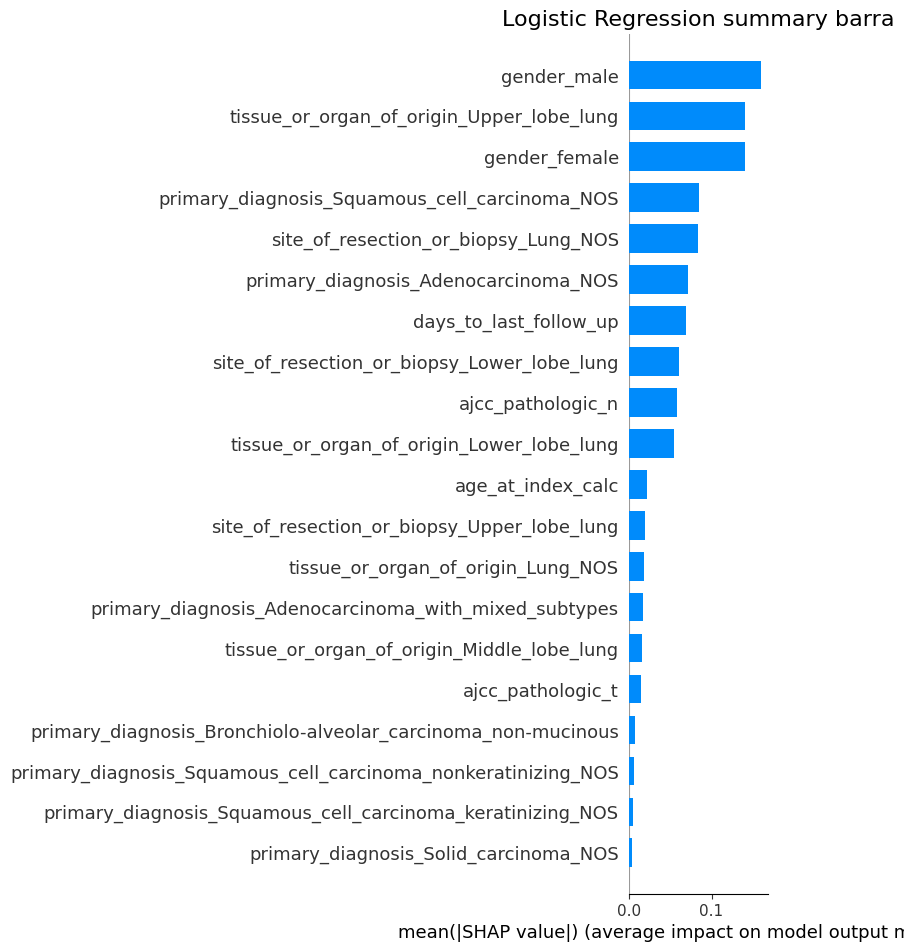

In [105]:
shap.summary_plot(shap_values_lr_class1, x_teste_norm, plot_type="bar", show=False)
plt.title("Logistic Regression summary barra")
plt.show()

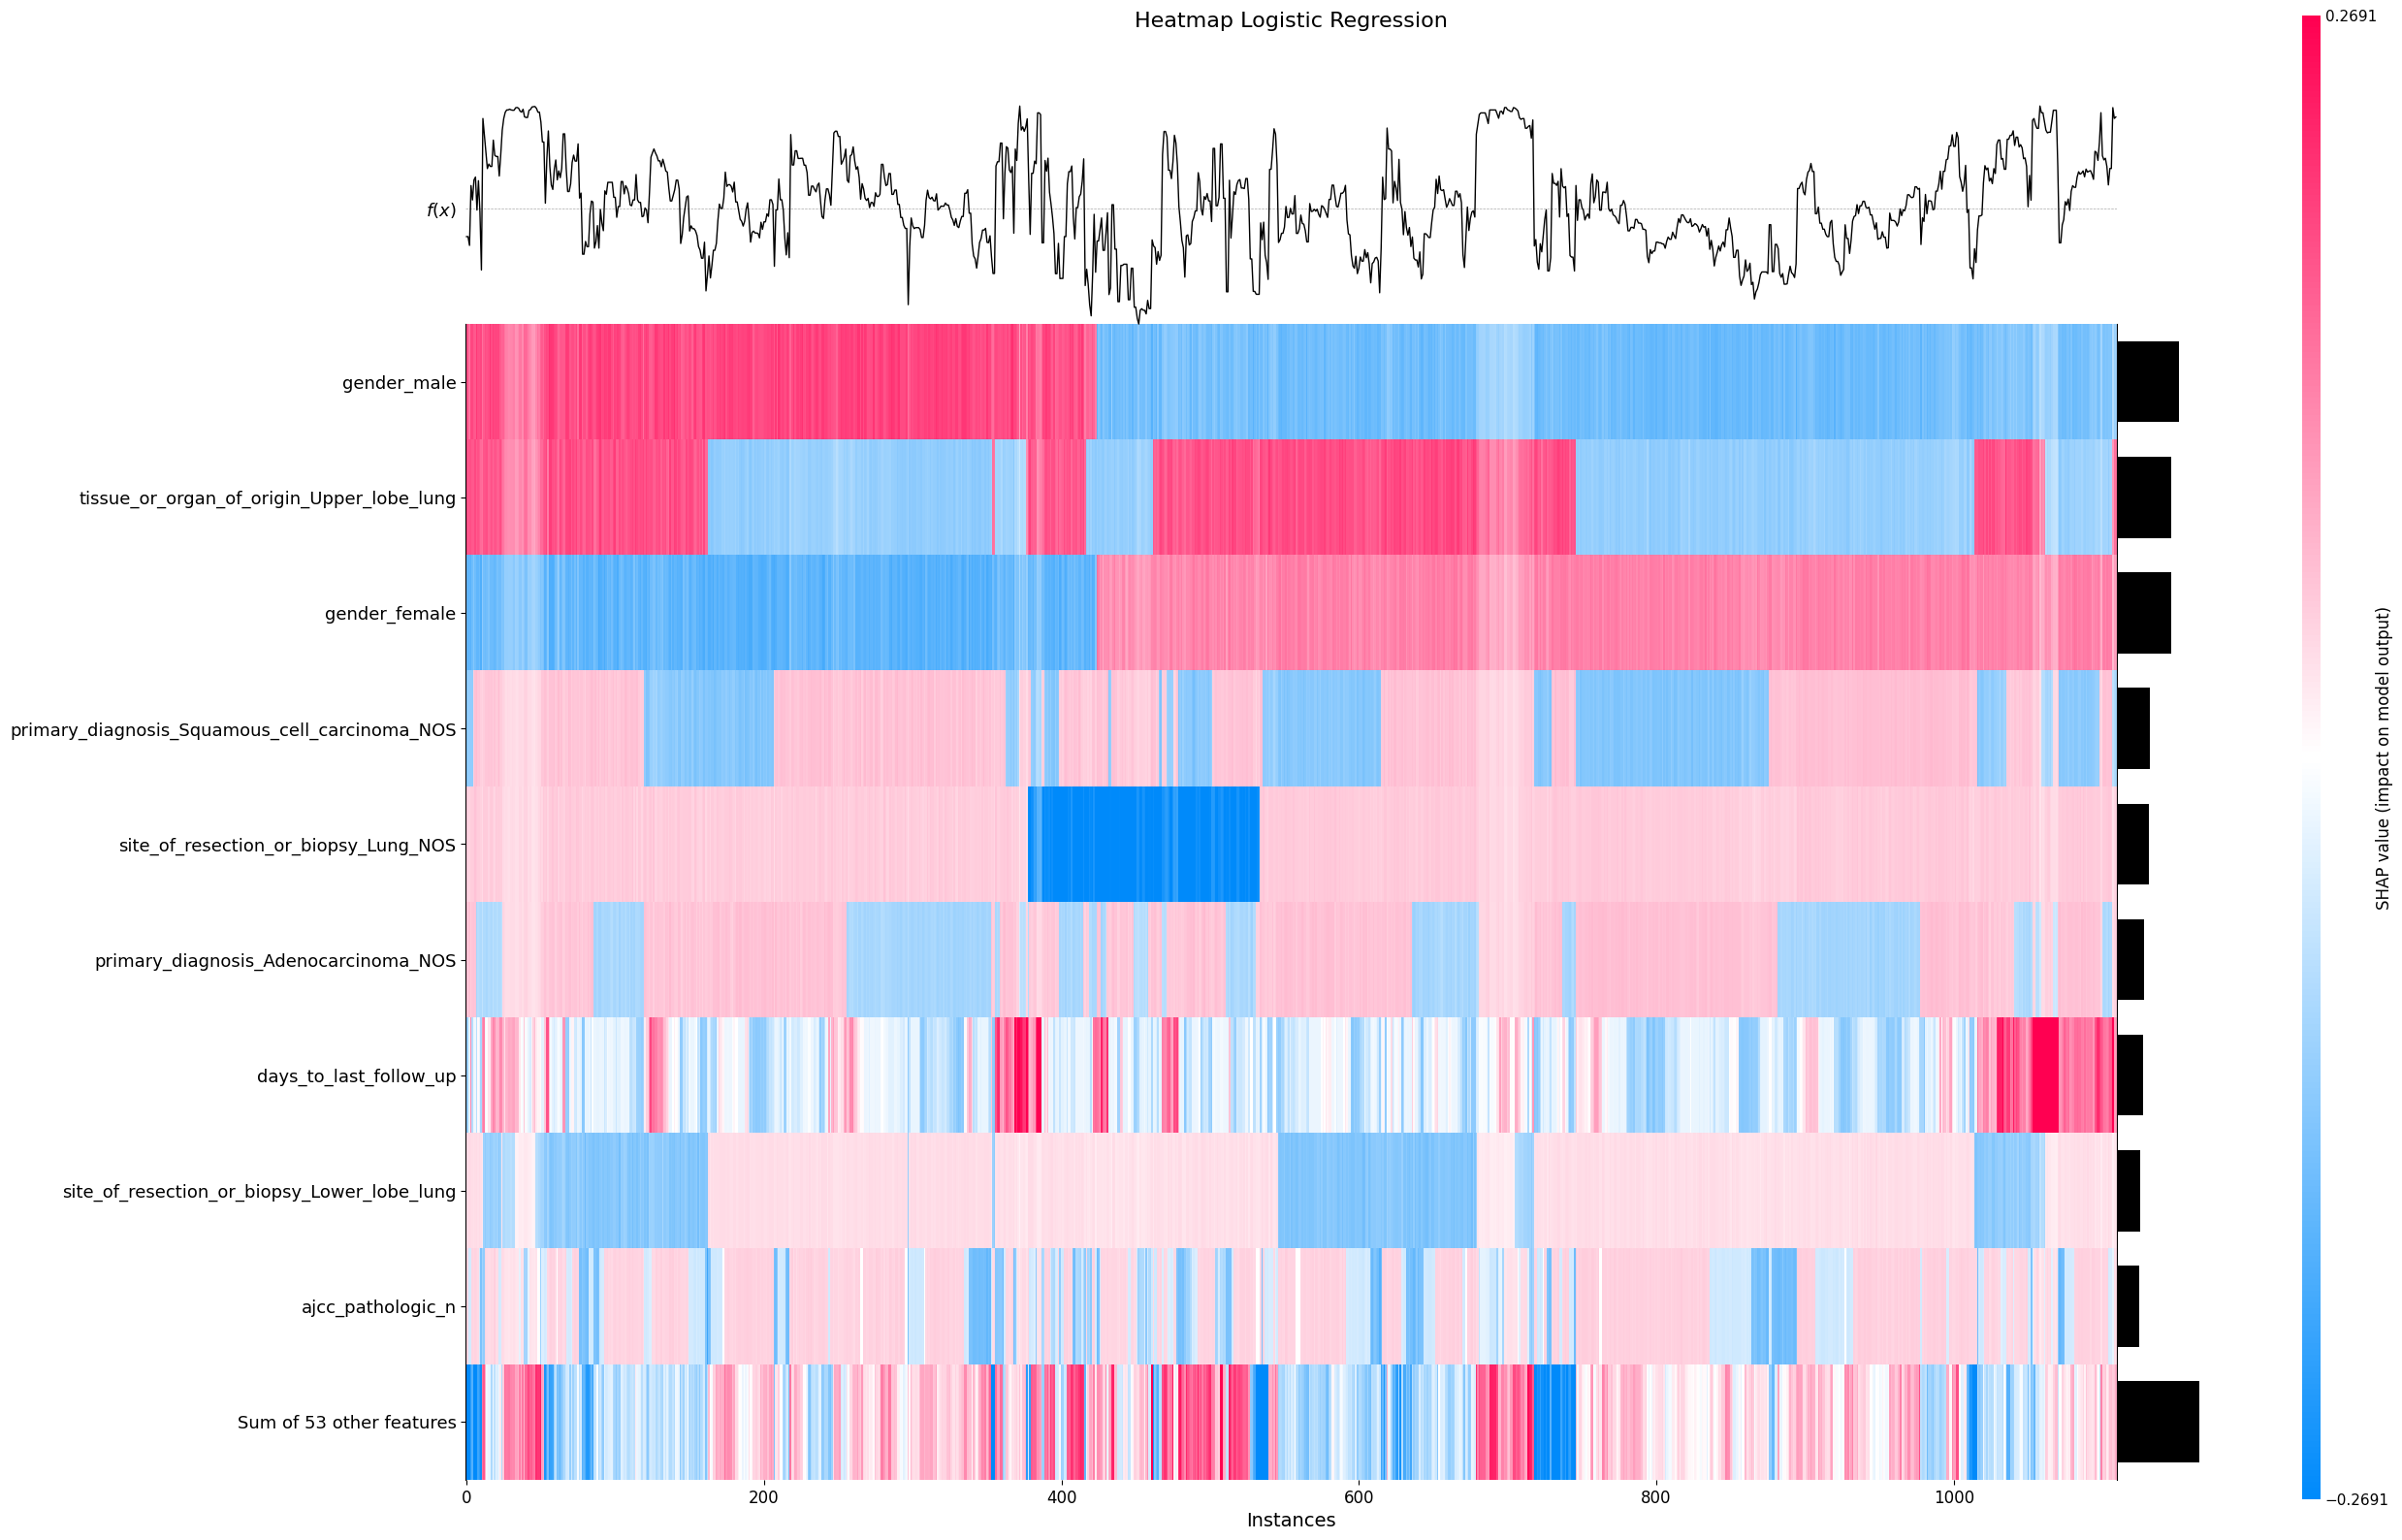

In [106]:
shap.plots.heatmap(shap_values_lr_class1, show=False)
plt.title("Heatmap Logistic Regression")
plt.gcf().set_size_inches(25, 25)
plt.show()

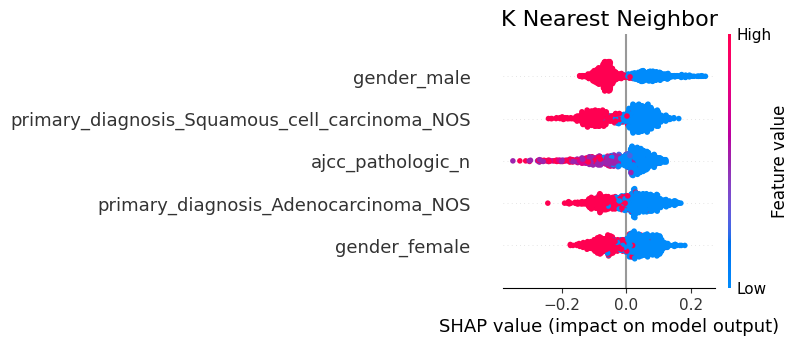

In [107]:
shap.summary_plot(shap_values_knn_class1, x_teste_norm, show=False, max_display=5)

# Ajustar o tamanho e o título do gráfico
plt.title("K Nearest Neighbor")  # Define o título e o tamanho da fonte

# Exibir o gráfico ajustado
plt.show()

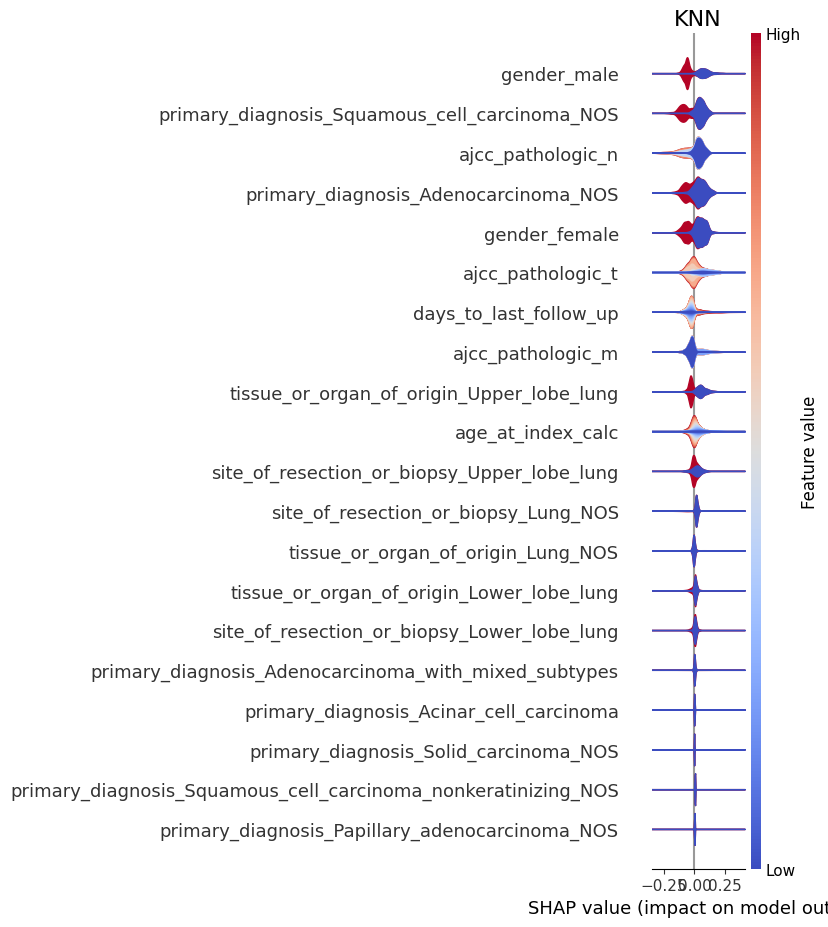

In [108]:
# Violin plot
shap.plots.violin(shap_values_knn_class1, features=x_teste_norm, feature_names=feature_names, plot_type="layered_violin", show=False)
plt.title("KNN")
plt.show()

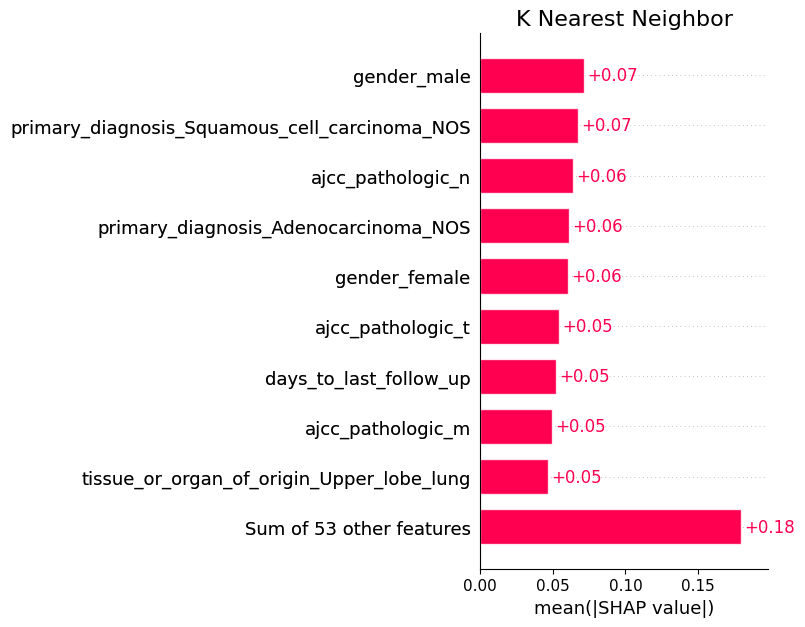

In [109]:
# importância das variáveis
shap.plots.bar(shap_values_knn_class1, show=False)
plt.title("K Nearest Neighbor")
plt.show()

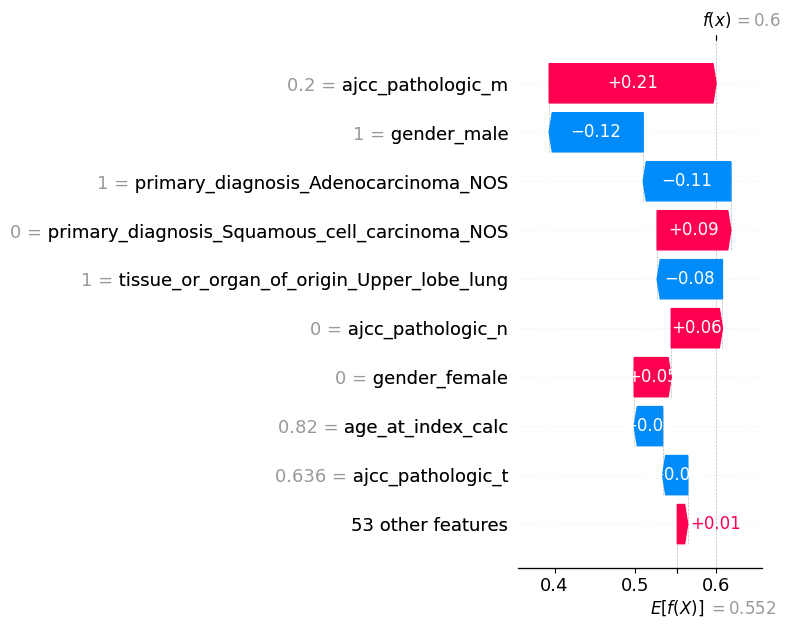

In [110]:
# Explica uma instância específica (índice)
shap.plots.waterfall(shap_values_knn_class1[3])

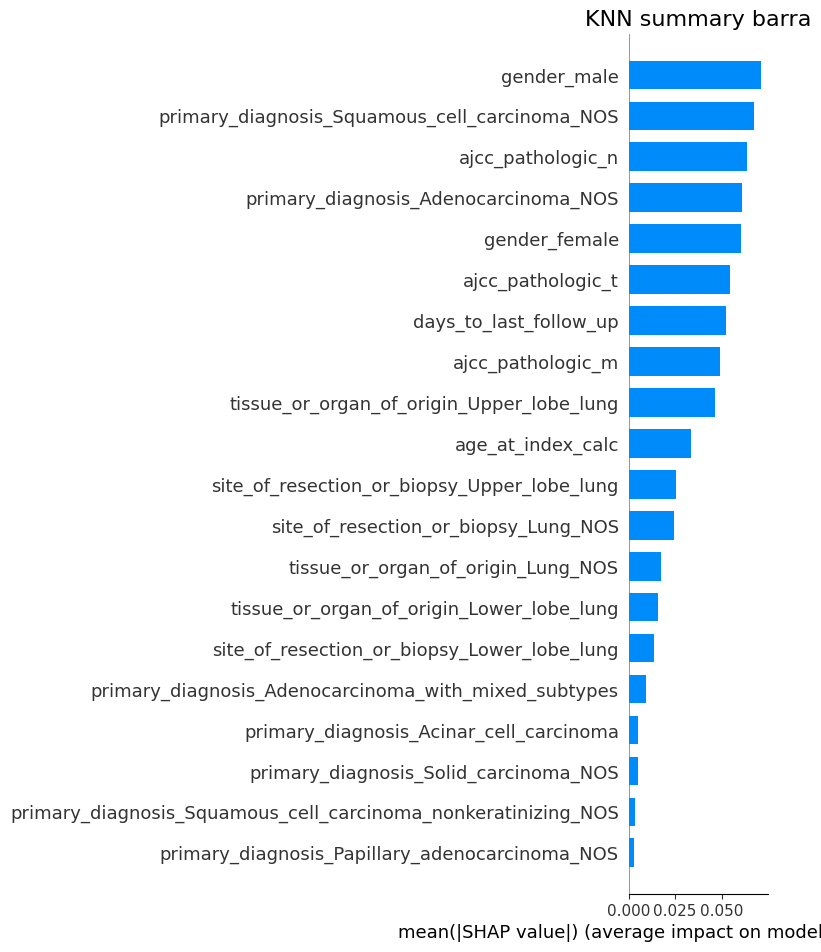

In [111]:
shap.summary_plot(shap_values_knn_class1, x_teste_norm, plot_type="bar", show=False)
plt.title("KNN summary barra")
plt.show()

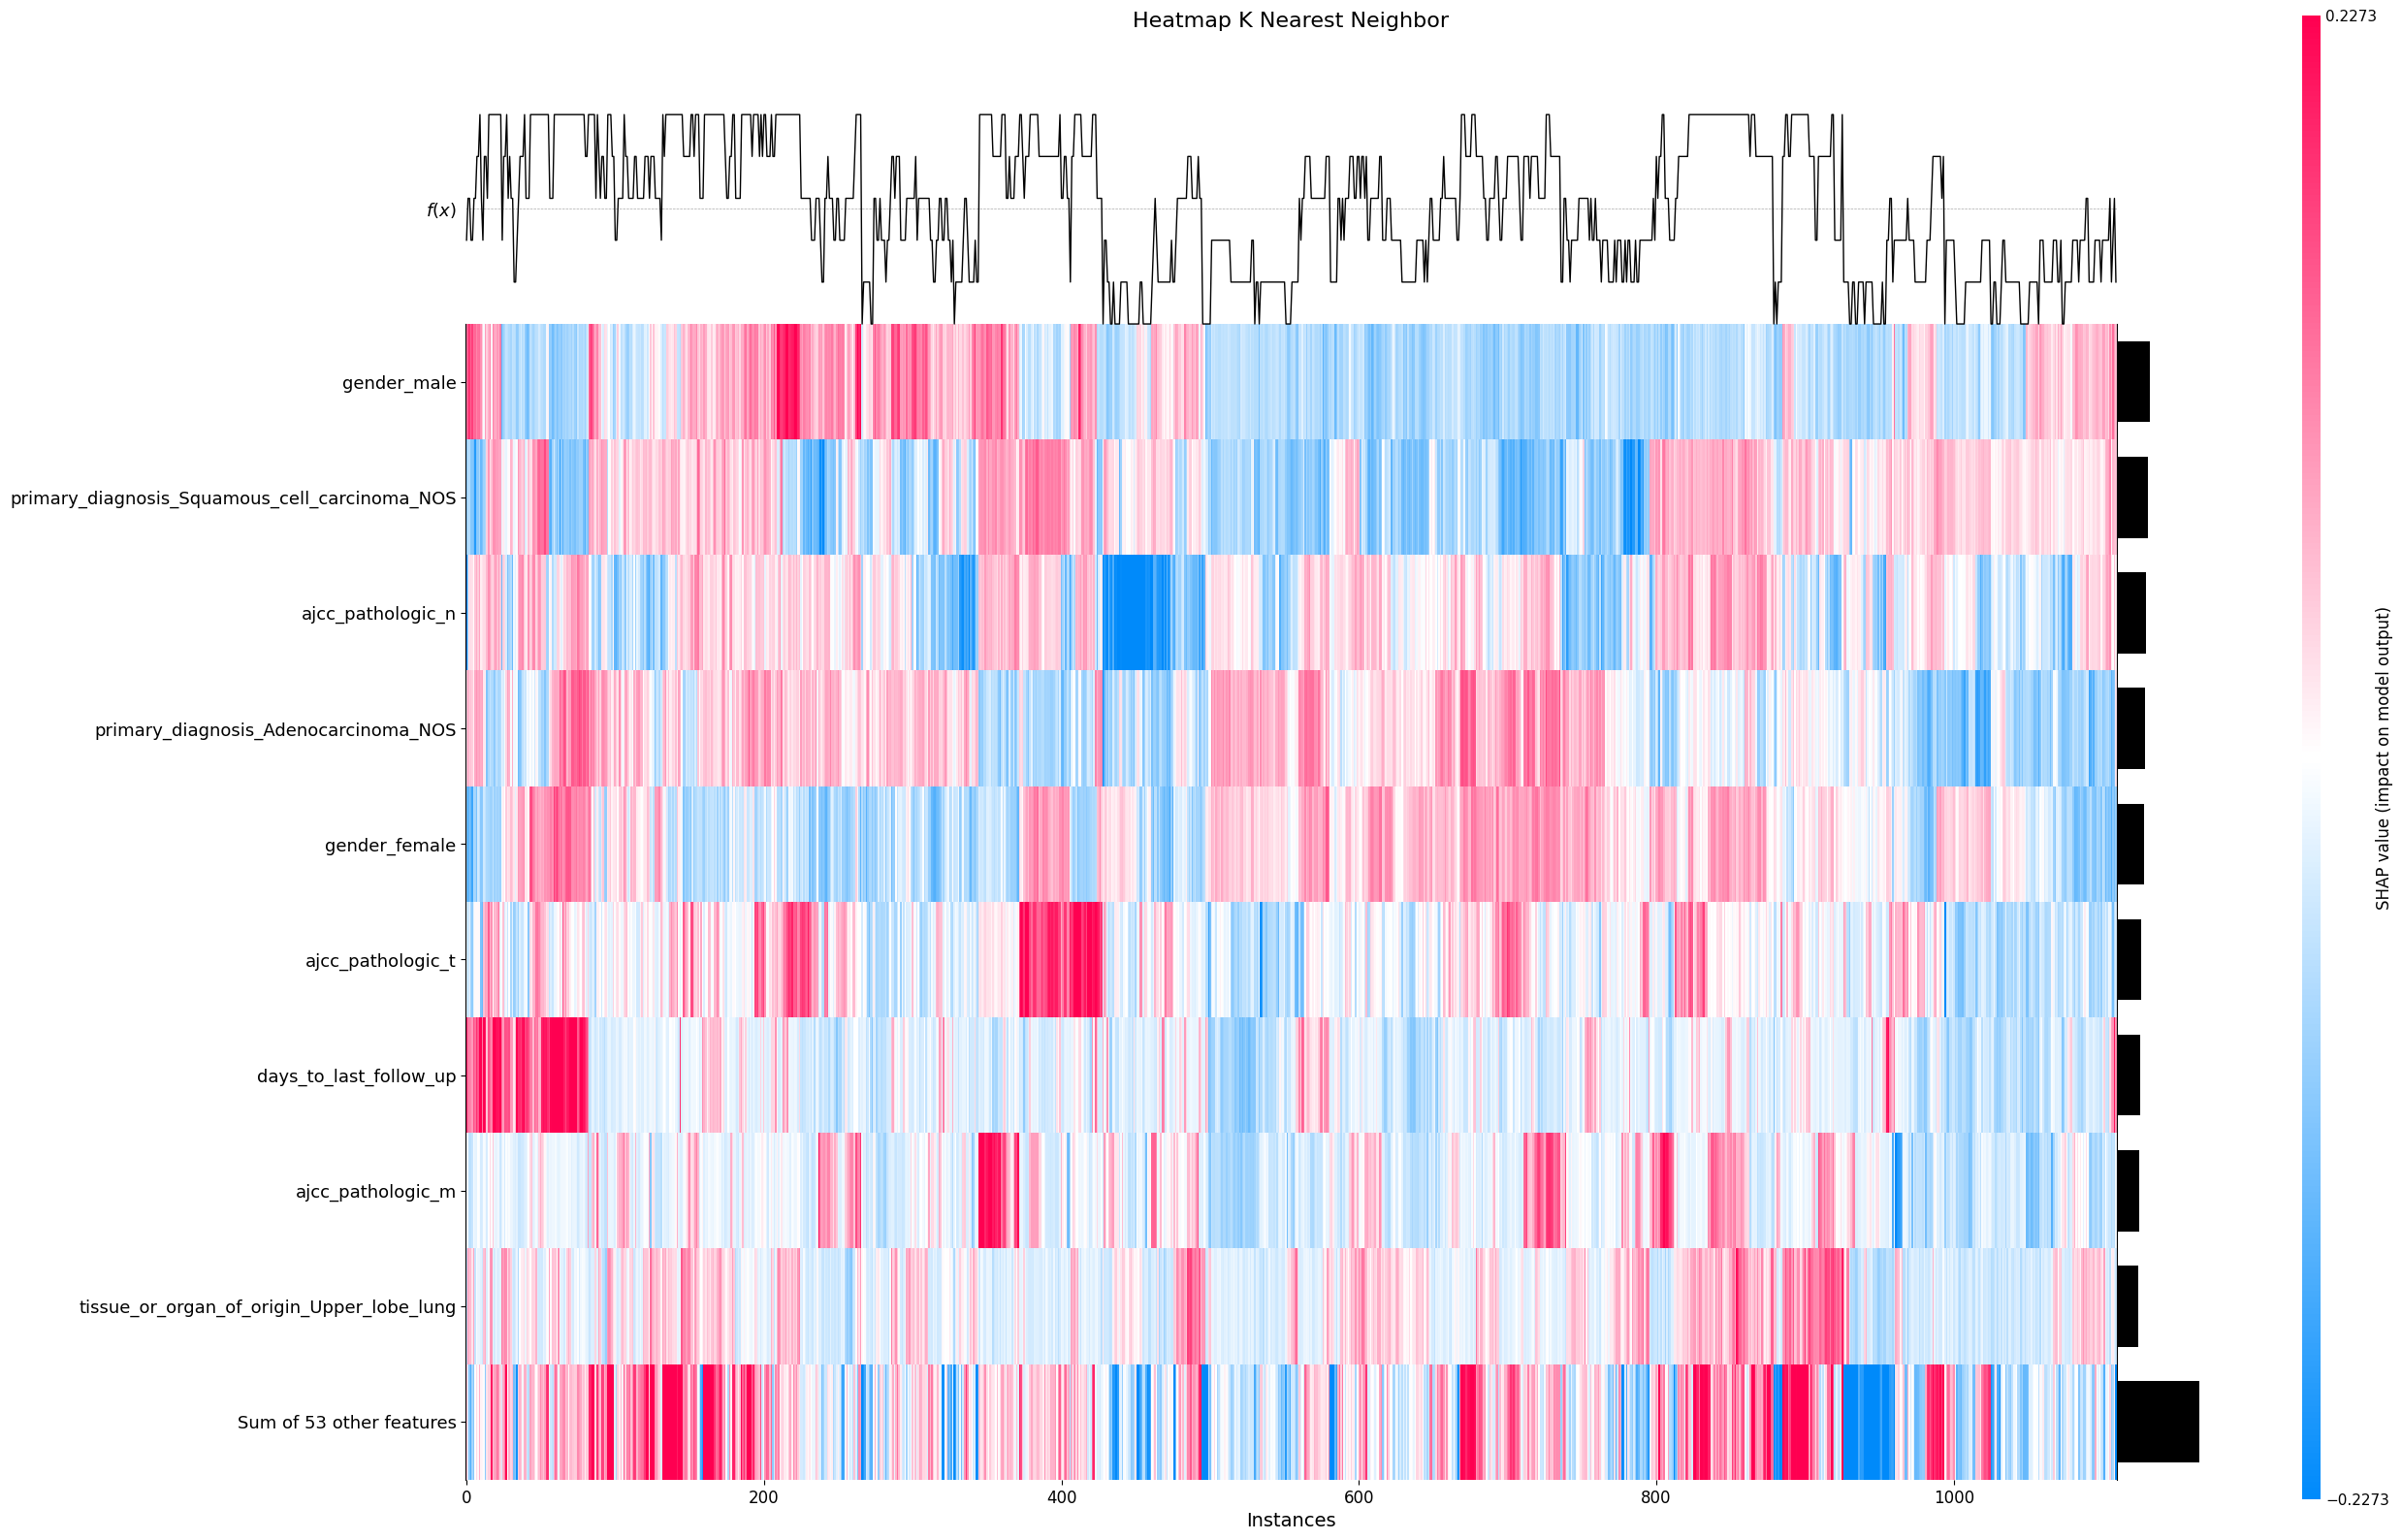

In [112]:
shap.plots.heatmap(shap_values_knn_class1, show=False)
plt.title("Heatmap K Nearest Neighbor")
plt.gcf().set_size_inches(25, 25)
plt.show()

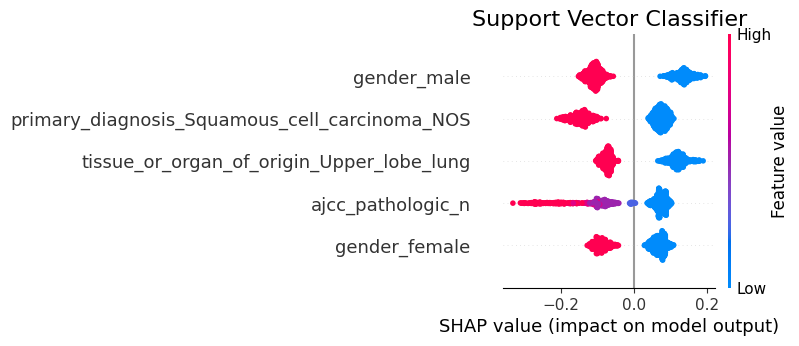

In [113]:
shap.summary_plot(shap_values_svc_class1, x_teste_norm, show=False, max_display=5)

# Ajustar o tamanho e o título do gráfico
plt.title("Support Vector Classifier")  # Define o título e o tamanho da fonte

# Exibir o gráfico ajustado
plt.show()

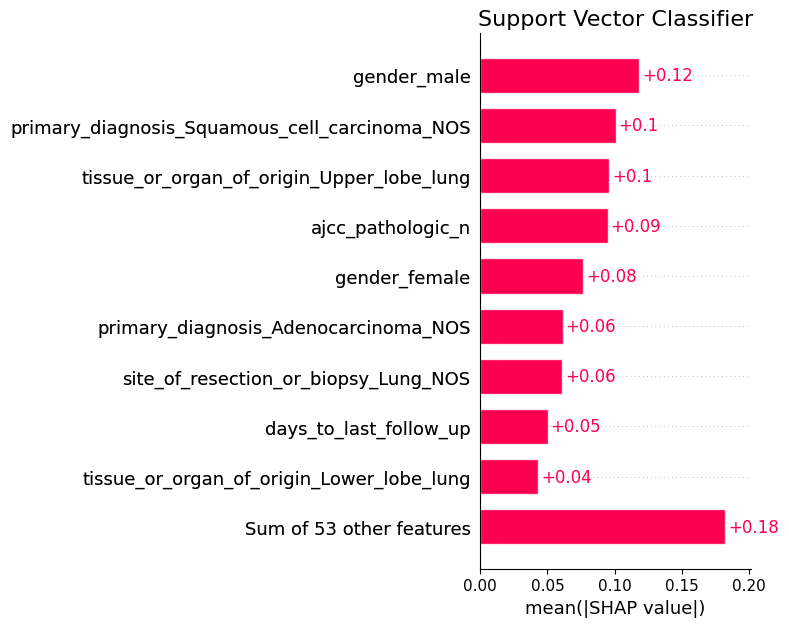

In [114]:
# importância das variáveis
shap.plots.bar(shap_values_svc_class1, show=False)
plt.title("Support Vector Classifier")
plt.show()

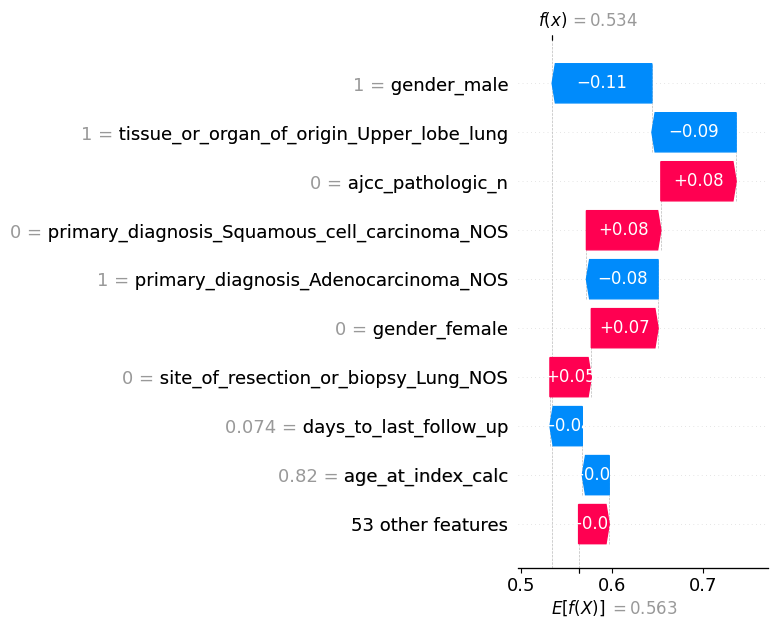

In [115]:
# Explica uma instância específica (índice)
shap.plots.waterfall(shap_values_svc_class1[3])

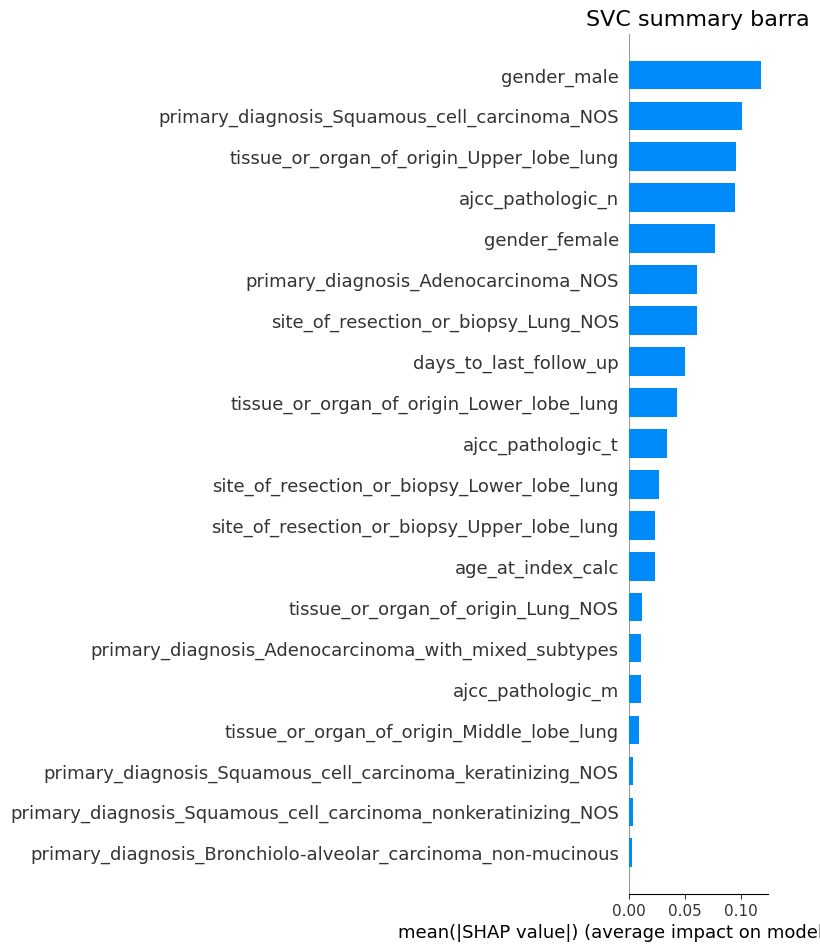

In [116]:
shap.summary_plot(shap_values_svc_class1, x_teste_norm, plot_type="bar", show=False)
plt.title("SVC summary barra")
plt.show()

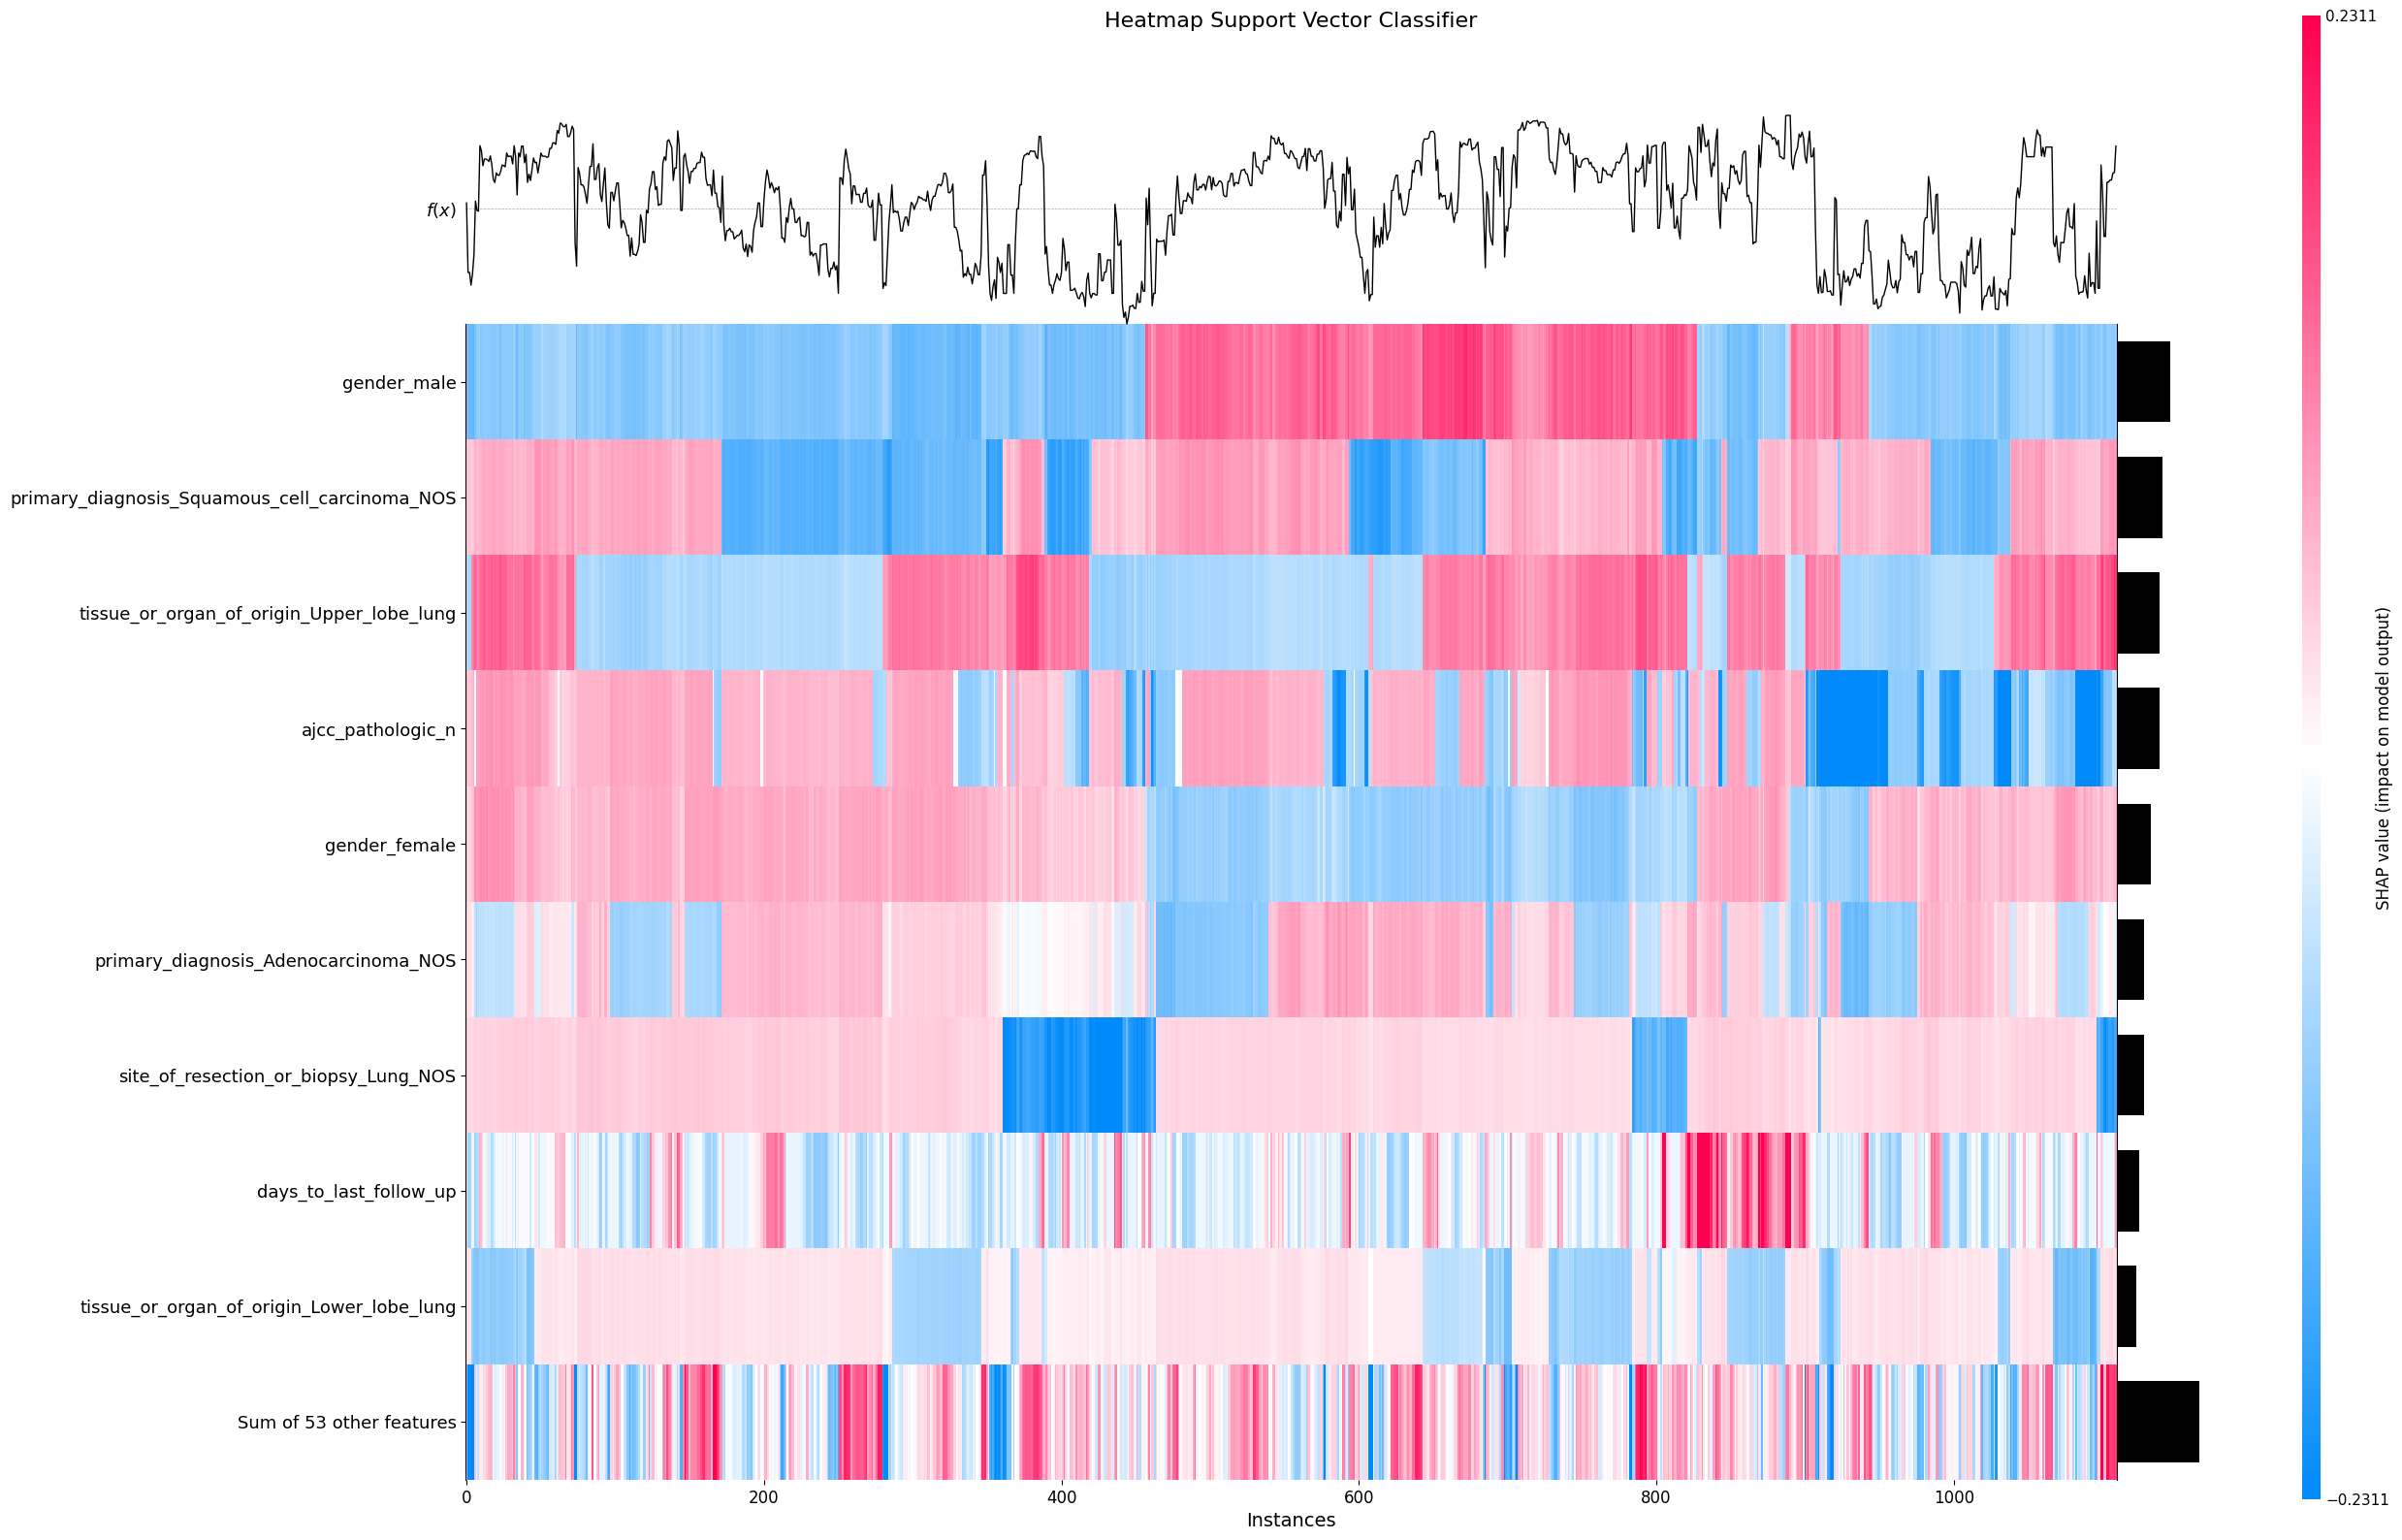

In [117]:
shap.plots.heatmap(shap_values_svc_class1, show=False)
plt.title("Heatmap Support Vector Classifier")
plt.gcf().set_size_inches(25, 25)
plt.show()

# 9. Curva de aprendizado

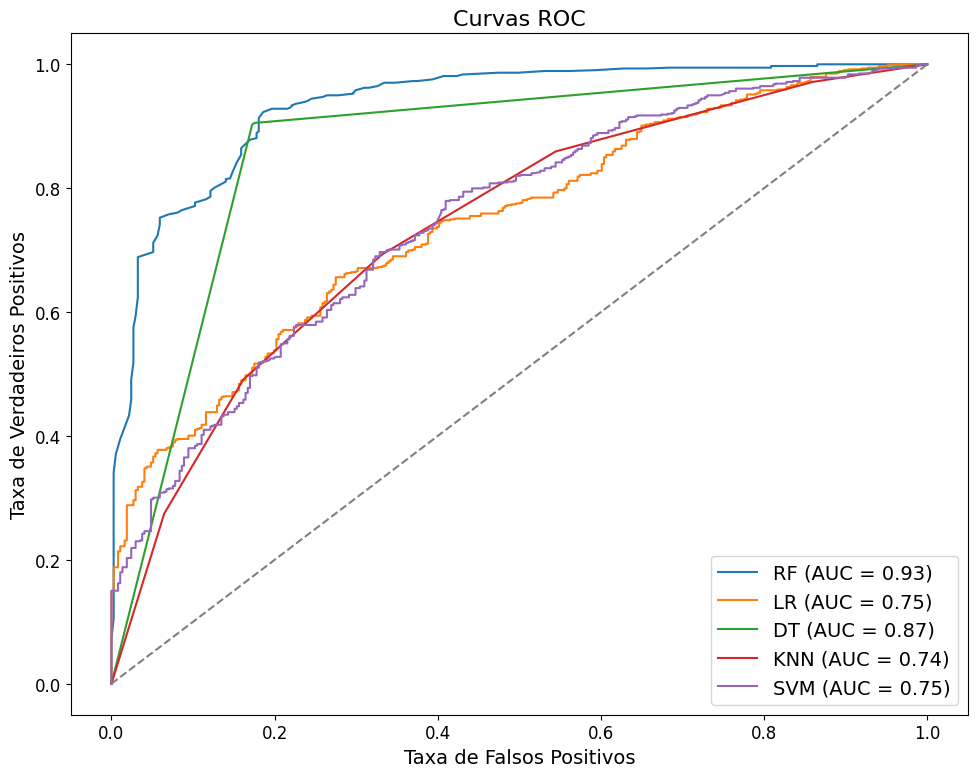

In [145]:
from sklearn.metrics import roc_curve, auc

portugues = True

# Inicializar os classificadores
classifiers = {
    "RF": clf,
    "LR": reglog,
    "DT": dt,
    "KNN": knn,
    "SVM": svm  # SVC com probabilidade para calcular ROC
}

# Plotar a Curva ROC para cada classificador
plt.figure(figsize=(10, 8))

for name, modelo in classifiers.items():
    # Treinar o modelo
    modelo.fit(x_treino_norm, y_treino)
    
    # Obter as probabilidades de predição para a classe positiva
    y_prob = modelo.predict_proba(x_teste_norm)[:, 1]
    
    # Calcular a curva ROC
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    
    # Calcular a AUC
    roc_auc = auc(fpr, tpr)
    
    # Plotar a curva ROC
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')

# Plotar a linha diagonal (modelo aleatório)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')

if portugues:
    # Definir título e rótulos
    plt.title('Curvas ROC')
    plt.xlabel('Taxa de Falsos Positivos')
    plt.ylabel('Taxa de Verdadeiros Positivos')
else:
    plt.title('ROC Curves')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

plt.legend(loc="lower right")

# Exibir o gráfico
plt.show()